# Beta Band Regressions
Created: 07/30/24 \
Updated: 07/31/2024 \
*Run for NYC Neuromod Conf

In [47]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm



import warnings
warnings.filterwarnings('ignore')




In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir   = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir  = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'
save_dir   = f'{base_dir}ephys_analysis/results/regression_data/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)

07312024


In [50]:
import sys
sys.path.append(f'{base_dir}ephys_analysis/LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *

In [51]:
subj_ids = list(pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


In [52]:
bdi_list = pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
subj_info_df = pd.DataFrame({'subj_id':subj_ids,'bdi':bdi_list})
subj_info_df



subj_id  bdi
0    MS002   14
1    MS003    8
2    MS009   16
3    MS011   13
4    MS015   26
5    MS016   10
6    MS017   26
7    MS019   12
8    MS022   10
9    MS024   16
10   MS025   10
11   MS026    9
12   MS027   22
13   MS028   13
14   MS029   32
15   MS030   19
16   MS033   39
17   MS035   15
18   MS041   10
19   MS043   23
20   MS048   19
21   MS050    9
22     DA8   13
23   DA023   14
24   DA026   19
25   DA037    4
26   DA039   22

In [53]:
#### set theme for all plots
# %matplotlib inline
# from matplotlib import rc
# rc('text', usetex=False)

sns.set_theme(style='ticks') 
sns.set_context("poster")



In [54]:
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm


# saez_cmap colors = org,yellow, sagegreen, darker green, blue, purple 

# 671351
saez_colors    = ['#ffb243','#FCE27C','#6a9752','#1d5d2a','#00467e','#561C46']
saez_hex_cmap  = ListedColormap(saez_colors)
saez_rgb       = [mpl.colors.to_rgb(hex) for hex in saez_colors]
saez_full_cmap = LinearSegmentedColormap.from_list('saez_full_cmap',saez_rgb,N=10)
#plot_palette = saez_linear_cmap.resampled(lutsize=30)
expanded_cmap  = [mpl.colors.rgb2hex(saez_full_cmap(c)[:3]) for c in range(saez_full_cmap.N)]


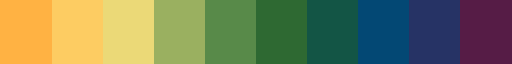

In [55]:
saez_full_cmap

# Load beta power data 

In [ ]:
# #### Try Beta Power 
# all_subj_beta_power = {}
# all_subj_metadata   = {}

# beta_range = [13,30]

# # load pow epochs data 
# for subj_id in subj_ids: 
#     # load power epochs for single subject 
#     power_epochs = mne.time_frequency.read_tfrs(f'{neural_dir}{subj_id}/{subj_id}_CpeOnset-tfr.h5')[0]
#     all_subj_metadata[subj_id] = power_epochs.metadata.copy()
    
#     # extract power df with mean beta power for each epoch for each elec 
#     power_df = power_epochs.to_data_frame()
#     del power_epochs 
#     beta_power_df = power_df[(power_df.freq >= beta_range[0])&(power_df.freq <= beta_range[1])].groupby(['epoch']).agg('mean').reset_index()
#     del power_df 
#     all_subj_beta_power[subj_id] = beta_power_df
#     del beta_power_df
    
    
# # create a binary pickle file 
# pickle.dump(all_subj_beta_power,open(f'{save_dir}all_subj_beta_power_nocrop.pkl',"wb"))
# pickle.dump(all_subj_metadata,open(f'{save_dir}all_subj_metadata.pkl',"wb"))

    

# Make Beta Regression DF

1. Update metadata vars - add t+1 vars, normalize vecs by 2std
2. Aggregate metadata, power data, ROI info, bdi info into one master df 

In [56]:
beta_df = pd.read_csv(f'{save_dir}beta_master_df.csv')
beta_df.subj_id.unique()

array(['MS002', 'MS003', 'MS009', 'MS011', 'MS015', 'MS016', 'MS017',
       'MS019', 'MS022', 'MS024', 'MS025', 'MS026', 'MS027', 'MS028',
       'MS029', 'MS030', 'MS033', 'MS035', 'MS041', 'MS043', 'MS048',
       'MS050', 'DA8', 'DA023', 'DA026', 'DA037', 'DA039'], dtype=object)

In [57]:
roi_reref_labels_master_df = pd.read_csv(glob(f'{base_dir}ephys_analysis/results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




In [58]:
roi_reref_labels_master_df.roi.value_counts()

dmpfc            216
ofc              202
acc              193
sts              155
hpc              135
amy              113
dlpfc            107
stg              105
vlpfc             82
ains              71
smg               66
pins              60
thalamus          58
mtg               57
temporal pole     31
mcc               28
motor             25
phg               25
parietal          24
vmpfc             23
fusiform          19
occipital         19
itg               15
angular           14
somat             11
premotor           9
caudate            8
pcc                1
Name: roi, dtype: int64

In [59]:
#### filter df by rois with electrode counts >= 50 *** updated to >15
keep_rois = roi_reref_labels_master_df.roi.value_counts().index[roi_reref_labels_master_df.roi.value_counts(
).values>=20].tolist()

# keep_rois = roi_reref_labels_master_df.roi.value_counts().index[
#     roi_reref_labels_master_df.roi.value_counts().values>=50].tolist()
# keep_rois = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','hpc','amy','mtg']     
# keep_rois


In [60]:
####### NEW DATA FRAME 
beta_reg_df = beta_df.copy()
beta_reg_df = beta_reg_df[beta_reg_df.roi.isin(keep_rois)]
len(beta_reg_df)

244136

In [61]:
np.max(beta_reg_df.band_pow)

6.032583972049991

# Beta ~ Outcome Vars Regressions

In [62]:
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'

In [63]:
final_vars   = ['C(GambleChoice)', 'TotalProfit', 'decisionCPE']
final_fit = fit_mixed_model(beta_reg_df,final_vars,outcome_var,rand_eff_var,reml=False)
print(final_fit.summary())
final_fit.bic  

                        Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          band_pow  
No. Observations:            244112           Method:                      ML        
No. Groups:                  1776             Scale:                       0.0408    
Min. group size:             65               Log-Likelihood:              39057.2397
Max. group size:             148              Converged:                   Yes       
Mean group size:             137.5                                                   
-------------------------------------------------------------------------------------
                                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                 -0.053    0.003 -20.559 0.000 -0.058 -0.048
C(GambleChoice)[T.safe]                   -0.006    0.001  -4.528 0.000 -0.009

-77928.39857466736

In [ ]:
-77928.39857466736

In [64]:
final_vars   = ['C(TrialType)','TrialEV', 'TotalProfit', 'decisionCPE']
final_fit = fit_mixed_model(beta_reg_df,final_vars,outcome_var,rand_eff_var,reml=False)
print(final_fit.summary())
final_fit.bic    

                          Mixed Linear Model Regression Results
Model:                        MixedLM            Dependent Variable:            band_pow  
No. Observations:             244112             Method:                        ML        
No. Groups:                   1776               Scale:                         0.0411    
Min. group size:              65                 Log-Likelihood:                38547.8147
Max. group size:              148                Converged:                     Yes       
Mean group size:              137.5                                                       
------------------------------------------------------------------------------------------
                                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                      -0.054    0.003 -21.404 0.000 -0.059 -0.049
C(TrialType)[T.loss]      

-76748.27878718339

In [65]:
final_vars   = ['C(GambleChoice)', 'TrialEV','TotalProfit', 'decisionCPE']
final_fit = fit_mixed_model(beta_reg_df,final_vars,outcome_var,rand_eff_var,reml=False)
print(final_fit.summary())


                        Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          band_pow  
No. Observations:            244112           Method:                      ML        
No. Groups:                  1776             Scale:                       0.0408    
Min. group size:             65               Log-Likelihood:              39073.2571
Max. group size:             148              Converged:                   Yes       
Mean group size:             137.5                                                   
-------------------------------------------------------------------------------------
                                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                 -0.053    0.003 -20.722 0.000 -0.058 -0.048
C(GambleChoice)[T.safe]                   -0.005    0.001  -3.626 0.000 -0.008

In [66]:
final_fit.bic

-77886.00117049165

In [67]:
final_vars   = ['C(GambleChoice)', 'TrialEV', 'decisionCPE']
final_fit = fit_mixed_model(beta_reg_df,final_vars,outcome_var,rand_eff_var,reml=False)
print(final_fit.summary())
final_fit.bic  

                        Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          band_pow  
No. Observations:            244112           Method:                      ML        
No. Groups:                  1776             Scale:                       0.0412    
Min. group size:             65               Log-Likelihood:              38674.3712
Max. group size:             148              Converged:                   Yes       
Mean group size:             137.5                                                   
-------------------------------------------------------------------------------------
                                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                 -0.053    0.003 -20.750 0.000 -0.059 -0.048
C(GambleChoice)[T.safe]                   -0.005    0.001  -3.362 0.001 -0.008

-77162.6616648732

In [68]:
final_vars   = ['TrialEV', 'TotalProfit', 'decisionCPE']
final_fit = fit_mixed_model(beta_reg_df,final_vars,outcome_var,rand_eff_var,reml=False)
print(final_fit.summary())
final_fit.bic  

                  Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      band_pow  
No. Observations:        244112       Method:                  ML        
No. Groups:              1776         Scale:                   0.0413    
Min. group size:         65           Log-Likelihood:          38465.1715
Max. group size:         148          Converged:               Yes       
Mean group size:         137.5                                           
-------------------------------------------------------------------------
                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                     -0.055    0.002 -22.447 0.000 -0.060 -0.050
TrialEV                        0.005    0.001   5.810 0.000  0.004  0.007
TotalProfit                    0.005    0.001   4.226 0.000  0.003  0.008
decisionCPE                    0.005    0.001   5.704 0.

-76744.26232072695

In [69]:
final_vars   = ['C(GambleChoice)', 'decisionCPE']
final_fit = fit_mixed_model(beta_reg_df,final_vars,outcome_var,rand_eff_var,reml=False)
print(final_fit.summary())
final_fit.bic  

                        Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          band_pow  
No. Observations:            244112           Method:                      ML        
No. Groups:                  1776             Scale:                       0.0412    
Min. group size:             65               Log-Likelihood:              38656.6641
Max. group size:             148              Converged:                   Yes       
Mean group size:             137.5                                                   
-------------------------------------------------------------------------------------
                                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                 -0.053    0.003 -20.586 0.000 -0.058 -0.048
C(GambleChoice)[T.safe]                   -0.006    0.001  -4.273 0.000 -0.009

-77189.27434340885

In [70]:
final_vars   = ['TotalProfit', 'decisionCPE']
final_fit = fit_mixed_model(beta_reg_df,final_vars,outcome_var,rand_eff_var,reml=False)
print(final_fit.summary())
final_fit.bic  

                  Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      band_pow  
No. Observations:        244112       Method:                  ML        
No. Groups:              1776         Scale:                   0.0414    
Min. group size:         65           Log-Likelihood:          38398.0126
Max. group size:         148          Converged:               Yes       
Mean group size:         137.5                                           
-------------------------------------------------------------------------
                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                     -0.055    0.002 -22.451 0.000 -0.060 -0.050
TotalProfit                    0.005    0.001   4.349 0.000  0.003  0.008
decisionCPE                    0.005    0.001   5.702 0.000  0.003  0.007
Group Var                      0.010    0.002           

-76671.9713105091

In [71]:
final_vars   = ['TrialEV', 'decisionCPE']
final_fit = fit_mixed_model(beta_reg_df,final_vars,outcome_var,rand_eff_var,reml=False)
print(final_fit.summary())
final_fit.bic  

                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     band_pow  
No. Observations:      244112      Method:                 ML        
No. Groups:            1776        Scale:                  0.0416    
Min. group size:       65          Log-Likelihood:         38085.5041
Max. group size:       148         Converged:              Yes       
Mean group size:       137.5                                         
---------------------------------------------------------------------
                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                 -0.055    0.002 -22.447 0.000 -0.060 -0.050
TrialEV                    0.005    0.001   5.768 0.000  0.004  0.007
decisionCPE                0.006    0.001   5.996 0.000  0.004  0.007
Group Var                  0.010    0.002                            
Group x TrialEV Cov       -0.000    

-76046.95446374474

In [438]:
final_fit.pvalues['decisionCPE']

9.594285781446883e-09

In [439]:
# final_fit.t_test_pairwise('C(TrialType)',
#                           factor_labels=[ 'TrialEV', 'TotalProfit', 'decisionCPE'])
# final_fit.model.data.design_info.term_names.index(term_name)

In [440]:
mixed_effects_ftest_ttest(final_fit)

(        coef   std err         t         P>|t|  Conf. Int. Low  \
 c0 -0.005212  0.001437 -3.626488  2.873602e-04       -0.008028   
 c1  0.003587  0.000893  4.017565  5.882021e-05        0.001837   
 c2  0.005397  0.001216  4.439001  9.041700e-06        0.003014   
 c3  0.005305  0.000925  5.737750  9.605580e-09        0.003493   
 
     Conf. Int. Upp.  
 c0        -0.002395  
 c1         0.005336  
 c2         0.007780  
 c3         0.007117  ,
 <class 'statsmodels.stats.contrast.ContrastResults'>
 <F test: F=79.4926909539725, p=2.563358755409826e-308, df_denom=2.44e+05, df_num=19>)

In [441]:
fe_param_names = list(final_fit.fe_params.index[1:])
fe_param_names

['C(GambleChoice)[T.safe]', 'TrialEV', 'TotalProfit', 'decisionCPE']

In [442]:
plot_data = pd.concat([pd.DataFrame(
    {**{'subj_id':elec_id.split('_')[0],'reref_ch_names':elec_id.split('_')[1]},'unique_reref_ch':elec_id,
     **{f'raw_{param}':final_fit.random_effects[elec_id][param] for param in list(
            final_fit.random_effects[elec_id].index)}},index=[range(len(fe_param_names))])
        
    for elec_id in final_fit.random_effects.keys()]).reset_index(drop=True)

plot_data['roi'] = [beta_reg_df.roi[beta_reg_df.unique_reref_ch == row.unique_reref_ch].values[0]
                                for idx,row in plot_data.iterrows()]

plot_data['bdi'] = [subj_info_df.bdi[subj_info_df.subj_id == subj_id].values[0]
                                for subj_id in plot_data.subj_id]

In [443]:
plot_data

subj_id reref_ch_names      unique_reref_ch  raw_Group  \
0      DA023      lac1-lac2      DA023_lac1-lac2   0.057098   
1      DA023    lac10-lac11    DA023_lac10-lac11   0.054178   
2      DA023      lac2-lac3      DA023_lac2-lac3   0.059921   
3      DA023      lac3-lac4      DA023_lac3-lac4   0.057624   
4      DA023      lac4-lac5      DA023_lac4-lac5   0.076251   
...      ...            ...                  ...        ...   
1771   MS050  rmoif4-rmoif5  MS050_rmoif4-rmoif5   0.027975   
1772   MS050  rmoif5-rmoif6  MS050_rmoif5-rmoif6   0.042911   
1773   MS050  rmoif6-rmoif7  MS050_rmoif6-rmoif7   0.057173   
1774   MS050  rmoif7-rmoif8  MS050_rmoif7-rmoif8   0.062100   
1775   MS050  rmoif8-rmoif9  MS050_rmoif8-rmoif9   0.082714   

      raw_C(GambleChoice)[T.safe]  raw_TrialEV  raw_TotalProfit  \
0                       -0.028357     0.001019        -0.021870   
1                       -0.016549    -0.001598         0.038374   
2                       -0.008565    -0.002481         0.010328   
3                       -0.006791    -0.001627        -0.001180   
4                       -0.040879    -0.000931         0.009905   
...                           ...          ...              ...   
1771                     0.045353    -0.001460         0.024782   
1772                     0.046843     0.001067         0.003481   
1773                     0.032173     0.001294         0.003393   
1774                     0.005052     0.010630        -0.012329   
1775                    -0.017544     0.002066        -0.005327   

      raw_decisionCPE    roi  bdi  
0            0.007724    acc   14  
1           -0.000944  dmpfc   14  
2           -0.003126    acc   14  
3           -0.000939    acc   14  
4            0.003899  dmpfc   14  
...               ...    ...  ...  
1771        -0.005722    ofc    9  
1772         0.001927    ofc    9  
1773         0.004197    ofc    9  
1774         0.031159    ofc    9  
1775         0.010870  vlpfc    9  

[1776 rows x 10 columns]

In [444]:
#### Get all results for Figs!!!!

fe_intercept   = final_fit.params['Intercept']
fe_cpe_beta    = final_fit.params['decisionCPE']
fe_cpe_beta


0.005304963491903207

In [445]:
#### add fixed effects data to all_elec_plot_data
plot_data['elec_b0']   = np.add(plot_data.raw_Group,fe_intercept)
plot_data['elec_bCPE'] = np.add(plot_data.raw_decisionCPE,fe_cpe_beta)
plot_data = plot_data[~plot_data.roi.isnull()]

In [446]:
plot_data

subj_id reref_ch_names      unique_reref_ch  raw_Group  \
0      DA023      lac1-lac2      DA023_lac1-lac2   0.057098   
1      DA023    lac10-lac11    DA023_lac10-lac11   0.054178   
2      DA023      lac2-lac3      DA023_lac2-lac3   0.059921   
3      DA023      lac3-lac4      DA023_lac3-lac4   0.057624   
4      DA023      lac4-lac5      DA023_lac4-lac5   0.076251   
...      ...            ...                  ...        ...   
1771   MS050  rmoif4-rmoif5  MS050_rmoif4-rmoif5   0.027975   
1772   MS050  rmoif5-rmoif6  MS050_rmoif5-rmoif6   0.042911   
1773   MS050  rmoif6-rmoif7  MS050_rmoif6-rmoif7   0.057173   
1774   MS050  rmoif7-rmoif8  MS050_rmoif7-rmoif8   0.062100   
1775   MS050  rmoif8-rmoif9  MS050_rmoif8-rmoif9   0.082714   

      raw_C(GambleChoice)[T.safe]  raw_TrialEV  raw_TotalProfit  \
0                       -0.028357     0.001019        -0.021870   
1                       -0.016549    -0.001598         0.038374   
2                       -0.008565    -0.002481         0.010328   
3                       -0.006791    -0.001627        -0.001180   
4                       -0.040879    -0.000931         0.009905   
...                           ...          ...              ...   
1771                     0.045353    -0.001460         0.024782   
1772                     0.046843     0.001067         0.003481   
1773                     0.032173     0.001294         0.003393   
1774                     0.005052     0.010630        -0.012329   
1775                    -0.017544     0.002066        -0.005327   

      raw_decisionCPE    roi  bdi   elec_b0  elec_bCPE  
0            0.007724    acc   14  0.003810   0.013029  
1           -0.000944  dmpfc   14  0.000891   0.004361  
2           -0.003126    acc   14  0.006633   0.002179  
3           -0.000939    acc   14  0.004336   0.004366  
4            0.003899  dmpfc   14  0.022964   0.009204  
...               ...    ...  ...       ...        ...  
1771        -0.005722    ofc    9 -0.025313  -0.000417  
1772         0.001927    ofc    9 -0.010377   0.007232  
1773         0.004197    ofc    9  0.003886   0.009502  
1774         0.031159    ofc    9  0.008812   0.036464  
1775         0.010870  vlpfc    9  0.029426   0.016175  

[1776 rows x 12 columns]

In [447]:
raw_roi_stats = {f'{roi}':ttest_1samp(plot_data.raw_decisionCPE[plot_data.roi == roi].unique(),
                 popmean=0) for roi in plot_data.roi.unique().tolist()}
raw_roi_stats

{'acc': TtestResult(statistic=2.3322903411420524, pvalue=0.020721904859575316, df=192),
 'dmpfc': TtestResult(statistic=0.6389922832452991, pvalue=0.523508113703727, df=215),
 'hpc': TtestResult(statistic=-3.6105518990805794, pvalue=0.0004306348480203191, df=134),
 'sts': TtestResult(statistic=0.2691690094078876, pvalue=0.7881599191474239, df=154),
 'amy': TtestResult(statistic=-2.3828234154897947, pvalue=0.01886436306528478, df=112),
 'parietal': TtestResult(statistic=0.223817694157621, pvalue=0.8248753105807956, df=23),
 'stg': TtestResult(statistic=-2.627892938944307, pvalue=0.009891598608038885, df=104),
 'mcc': TtestResult(statistic=-2.0088441911039956, pvalue=0.05464980261488871, df=27),
 'mtg': TtestResult(statistic=-1.5985033866000125, pvalue=0.11555868297512688, df=56),
 'smg': TtestResult(statistic=-1.2023642943418087, pvalue=0.23358428650132093, df=65),
 'phg': TtestResult(statistic=-2.897957555012466, pvalue=0.0078979961969152, df=24),
 'temporal pole': TtestResult(statisti

In [448]:
roi_stats = {f'{roi}':ttest_1samp(plot_data.elec_bCPE[plot_data.roi == roi].unique(),
                 popmean=0) for roi in plot_data.roi.unique().tolist()}
roi_stats

{'acc': TtestResult(statistic=11.65215177617631, pvalue=4.466139187940707e-24, df=192),
 'dmpfc': TtestResult(statistic=9.195325995086598, pvalue=3.318887981226534e-17, df=215),
 'hpc': TtestResult(statistic=2.401273720929009, pvalue=0.01771059772873454, df=134),
 'sts': TtestResult(statistic=5.939626792130748, pvalue=1.8324646876824052e-08, df=154),
 'amy': TtestResult(statistic=3.5595693306038467, pvalue=0.0005462731031589922, df=112),
 'parietal': TtestResult(statistic=3.591215011550472, pvalue=0.0015428917662361826, df=23),
 'stg': TtestResult(statistic=3.5048414439944056, pvalue=0.0006753857992440227, df=104),
 'mcc': TtestResult(statistic=0.5616608436142876, pvalue=0.5789799843150649, df=27),
 'mtg': TtestResult(statistic=1.7787112375234997, pvalue=0.08071521024359916, df=56),
 'smg': TtestResult(statistic=3.789811637484393, pvalue=0.00033231064361210924, df=65),
 'phg': TtestResult(statistic=1.8204965471721781, pvalue=0.081176738276117, df=24),
 'temporal pole': TtestResult(stat

In [449]:
pairwise_ains_vals = plot_data.elec_bCPE[plot_data.roi == 'ains'].unique()

pairwise_roi_stats = {f'ains={roi}':ttest_ind(pairwise_ains_vals,plot_data.elec_bCPE[plot_data.roi == roi].unique(),
                 ) for roi in plot_data.roi.unique().tolist()}
pairwise_roi_stats


{'ains=acc': TtestResult(statistic=3.302614767805256, pvalue=0.0010912100099943487, df=262.0),
 'ains=dmpfc': TtestResult(statistic=3.7843599325167183, pvalue=0.00018785982308295096, df=285.0),
 'ains=hpc': TtestResult(statistic=5.664846261964686, pvalue=4.962601194258025e-08, df=204.0),
 'ains=sts': TtestResult(statistic=3.112105150834034, pvalue=0.002099327620325328, df=224.0),
 'ains=amy': TtestResult(statistic=5.03538236087966, pvalue=1.1416643997886755e-06, df=182.0),
 'ains=parietal': TtestResult(statistic=2.200636943891159, pvalue=0.030237814809658613, df=93.0),
 'ains=stg': TtestResult(statistic=5.257504877939079, pvalue=4.241854639347833e-07, df=174.0),
 'ains=mcc': TtestResult(statistic=4.135046192353501, pvalue=7.547936335512295e-05, df=97.0),
 'ains=mtg': TtestResult(statistic=4.028238391655016, pvalue=9.650642885511134e-05, df=126.0),
 'ains=smg': TtestResult(statistic=4.092781554692784, pvalue=7.295920244686247e-05, df=135.0),
 'ains=phg': TtestResult(statistic=4.07427621

In [450]:
pairwise_ains_vals = plot_data.elec_bCPE[plot_data.roi == 'ains'].unique()

pairwise_roi_stats_greater = {f'ains={roi}':ttest_ind(pairwise_ains_vals,plot_data.elec_bCPE[plot_data.roi == roi].unique(),
                 alternative='greater') for roi in plot_data.roi.unique().tolist()}
pairwise_roi_stats_greater

{'ains=acc': TtestResult(statistic=3.302614767805256, pvalue=0.0005456050049971743, df=262.0),
 'ains=dmpfc': TtestResult(statistic=3.7843599325167183, pvalue=9.392991154147548e-05, df=285.0),
 'ains=hpc': TtestResult(statistic=5.664846261964686, pvalue=2.4813005971290126e-08, df=204.0),
 'ains=sts': TtestResult(statistic=3.112105150834034, pvalue=0.001049663810162664, df=224.0),
 'ains=amy': TtestResult(statistic=5.03538236087966, pvalue=5.708321998943377e-07, df=182.0),
 'ains=parietal': TtestResult(statistic=2.200636943891159, pvalue=0.015118907404829306, df=93.0),
 'ains=stg': TtestResult(statistic=5.257504877939079, pvalue=2.1209273196739164e-07, df=174.0),
 'ains=mcc': TtestResult(statistic=4.135046192353501, pvalue=3.773968167756148e-05, df=97.0),
 'ains=mtg': TtestResult(statistic=4.028238391655016, pvalue=4.825321442755567e-05, df=126.0),
 'ains=smg': TtestResult(statistic=4.092781554692784, pvalue=3.647960122343124e-05, df=135.0),
 'ains=phg': TtestResult(statistic=4.07427621

In [451]:
pairwise_ains_vals = plot_data.elec_bCPE[plot_data.roi == 'ains'].unique()

pairwise_roi_stats_less = {f'ains={roi}':ttest_ind(pairwise_ains_vals,plot_data.elec_bCPE[plot_data.roi == roi].unique(),
                 alternative='less') for roi in plot_data.roi.unique().tolist()}
pairwise_roi_stats_less

{'ains=acc': TtestResult(statistic=3.302614767805256, pvalue=0.9994543949950029, df=262.0),
 'ains=dmpfc': TtestResult(statistic=3.7843599325167183, pvalue=0.9999060700884586, df=285.0),
 'ains=hpc': TtestResult(statistic=5.664846261964686, pvalue=0.999999975186994, df=204.0),
 'ains=sts': TtestResult(statistic=3.112105150834034, pvalue=0.9989503361898373, df=224.0),
 'ains=amy': TtestResult(statistic=5.03538236087966, pvalue=0.9999994291678, df=182.0),
 'ains=parietal': TtestResult(statistic=2.200636943891159, pvalue=0.9848810925951708, df=93.0),
 'ains=stg': TtestResult(statistic=5.257504877939079, pvalue=0.9999997879072681, df=174.0),
 'ains=mcc': TtestResult(statistic=4.135046192353501, pvalue=0.9999622603183225, df=97.0),
 'ains=mtg': TtestResult(statistic=4.028238391655016, pvalue=0.9999517467855724, df=126.0),
 'ains=smg': TtestResult(statistic=4.092781554692784, pvalue=0.9999635203987766, df=135.0),
 'ains=phg': TtestResult(statistic=4.074276216997836, pvalue=0.9999518158115879

In [452]:
bonferr_alpha = 0.05/(len(plot_data.roi.unique().tolist()))
bonferr_alpha

0.0025

In [453]:
print('sig ROIs after multiple comp correction: ',[(roi,raw_roi_stats[roi].pvalue) for roi in raw_roi_stats.keys()
                                                   if raw_roi_stats[roi].pvalue< bonferr_alpha])
# print('sig ROI pvals: ',roi_stats.roi_cpe_pval[roi_beta_results.roi_cpe_pval<=bonferr_alpha].unique().tolist())

sig_raw = [(roi,raw_roi_stats[roi].pvalue) for roi in raw_roi_stats.keys()
                                                   if raw_roi_stats[roi].pvalue< bonferr_alpha]

sig_raw_rois = list(zip(*sig_raw))[0]

sig ROIs after multiple comp correction:  [('hpc', 0.0004306348480203191), ('ains', 2.9489950829275173e-05)]


In [454]:
sig_raw_rois

('hpc', 'ains')

In [455]:
print('sig ROIs after multiple comp correction: ',[(roi,roi_stats[roi].pvalue) for roi in roi_stats.keys()
                                                   if roi_stats[roi].pvalue< bonferr_alpha])
# print('sig ROI pvals: ',roi_stats.roi_cpe_pval[roi_beta_results.roi_cpe_pval<=bonferr_alpha].unique().tolist())
sig_bcpe = [(roi,roi_stats[roi].pvalue) for roi in roi_stats.keys()
                                                   if roi_stats[roi].pvalue< bonferr_alpha]

sig_bcpe_rois = list(zip(*sig_bcpe))[0]

sig ROIs after multiple comp correction:  [('acc', 4.466139187940707e-24), ('dmpfc', 3.318887981226534e-17), ('sts', 1.8324646876824052e-08), ('amy', 0.0005462731031589922), ('parietal', 0.0015428917662361826), ('stg', 0.0006753857992440227), ('smg', 0.00033231064361210924), ('dlpfc', 1.295772308396758e-09), ('pins', 1.2296064895674807e-06), ('motor', 0.001600795621760743), ('ofc', 1.3825571719568902e-13), ('ains', 2.3854241777514987e-13), ('vlpfc', 2.0443006704242476e-09), ('thalamus', 3.998984483579347e-09)]


In [456]:
list(zip(*sig_bcpe))[0]

('acc',
 'dmpfc',
 'sts',
 'amy',
 'parietal',
 'stg',
 'smg',
 'dlpfc',
 'pins',
 'motor',
 'ofc',
 'ains',
 'vlpfc',
 'thalamus')

In [457]:
print('sig ROIs after multiple comp correction: ',[(roi,pairwise_roi_stats_greater[roi].pvalue) for 
                                                   roi in pairwise_roi_stats_greater.keys()
                                                   if pairwise_roi_stats_greater[roi].pvalue< bonferr_alpha])
# print('sig ROI pvals: ',roi_stats.roi_cpe_pval[roi_beta_results.roi_cpe_pval<=bonferr_alpha].unique().tolist())
sig_bcpe = [(roi,pairwise_roi_stats_greater[roi].pvalue) for roi in pairwise_roi_stats_greater.keys()
                                                   if pairwise_roi_stats_greater[roi].pvalue< bonferr_alpha]

sig_bcpe_rois = list(zip(*sig_bcpe))[0]

sig ROIs after multiple comp correction:  [('ains=acc', 0.0005456050049971743), ('ains=dmpfc', 9.392991154147548e-05), ('ains=hpc', 2.4813005971290126e-08), ('ains=sts', 0.001049663810162664), ('ains=amy', 5.708321998943377e-07), ('ains=stg', 2.1209273196739164e-07), ('ains=mcc', 3.773968167756148e-05), ('ains=mtg', 4.825321442755567e-05), ('ains=smg', 3.647960122343124e-05), ('ains=phg', 4.818418841210485e-05), ('ains=temporal pole', 0.00029732087765328393), ('ains=ofc', 1.7791285482963197e-05), ('ains=vmpfc', 0.0021014916770356194)]


In [458]:
sig_bcpe_rois 

('ains=acc',
 'ains=dmpfc',
 'ains=hpc',
 'ains=sts',
 'ains=amy',
 'ains=stg',
 'ains=mcc',
 'ains=mtg',
 'ains=smg',
 'ains=phg',
 'ains=temporal pole',
 'ains=ofc',
 'ains=vmpfc')

In [459]:
print('sig ROIs after multiple comp correction: ',[(roi,pairwise_roi_stats_less[roi].pvalue) for 
                                                   roi in pairwise_roi_stats_less.keys()
                                                   if pairwise_roi_stats_less[roi].pvalue< bonferr_alpha])
# print('sig ROI pvals: ',roi_stats.roi_cpe_pval[roi_beta_results.roi_cpe_pval<=bonferr_alpha].unique().tolist())
# sig_bcpe = [(roi,pairwise_roi_stats_less[roi].pvalue) for roi in pairwise_roi_stats_less.keys()
#                                                    if pairwise_roi_stats_less[roi].pvalue< bonferr_alpha]

# sig_bcpe_rois = list(zip(*sig_bcpe))[0]

sig ROIs after multiple comp correction:  []


In [460]:
print('sig ROIs after multiple comp correction: ',[(roi,pairwise_roi_stats[roi].pvalue) for 
                                                   roi in pairwise_roi_stats.keys()
                                                   if pairwise_roi_stats[roi].pvalue< bonferr_alpha])

sig_bcpe = [(roi,pairwise_roi_stats[roi].pvalue) for roi in pairwise_roi_stats.keys()
                                                   if pairwise_roi_stats[roi].pvalue< bonferr_alpha]

sig_bcpe_rois = list(zip(*sig_bcpe))[0]

sig ROIs after multiple comp correction:  [('ains=acc', 0.0010912100099943487), ('ains=dmpfc', 0.00018785982308295096), ('ains=hpc', 4.962601194258025e-08), ('ains=sts', 0.002099327620325328), ('ains=amy', 1.1416643997886755e-06), ('ains=stg', 4.241854639347833e-07), ('ains=mcc', 7.547936335512295e-05), ('ains=mtg', 9.650642885511134e-05), ('ains=smg', 7.295920244686247e-05), ('ains=phg', 9.63683768242097e-05), ('ains=temporal pole', 0.0005946417553065679), ('ains=ofc', 3.558257096592639e-05)]


In [461]:
sig_bcpe_rois

('ains=acc',
 'ains=dmpfc',
 'ains=hpc',
 'ains=sts',
 'ains=amy',
 'ains=stg',
 'ains=mcc',
 'ains=mtg',
 'ains=smg',
 'ains=phg',
 'ains=temporal pole',
 'ains=ofc')

In [462]:
len([(roi,roi_stats[roi].pvalue) for roi in roi_stats.keys()
                                                   if roi_stats[roi].pvalue< bonferr_alpha])

14

In [463]:
roi_stats.keys()

dict_keys(['acc', 'dmpfc', 'hpc', 'sts', 'amy', 'parietal', 'stg', 'mcc', 'mtg', 'smg', 'phg', 'temporal pole', 'dlpfc', 'pins', 'motor', 'ofc', 'ains', 'vlpfc', 'vmpfc', 'thalamus'])

In [464]:
# roi_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','hpc','amy','mtg','motor','thalamus']
roi_order = ['dlpfc','vlpfc','ofc','ains','pins','acc','hpc','amy']

In [465]:
roi_plot_data = plot_data.copy()
roi_plot_data = roi_plot_data[roi_plot_data.roi.isin(roi_order)]

# roi_plot_names = {'thalamus':'THAL','hpc':'HPC','amy':'AMY','acc':'ACC','ofc':'OFC','ains':'aINS',
#                   'pins':'pINS','dmpfc':'dmPFC','dlpfc':'dlPFC','vlpfc':'vlPFC'}


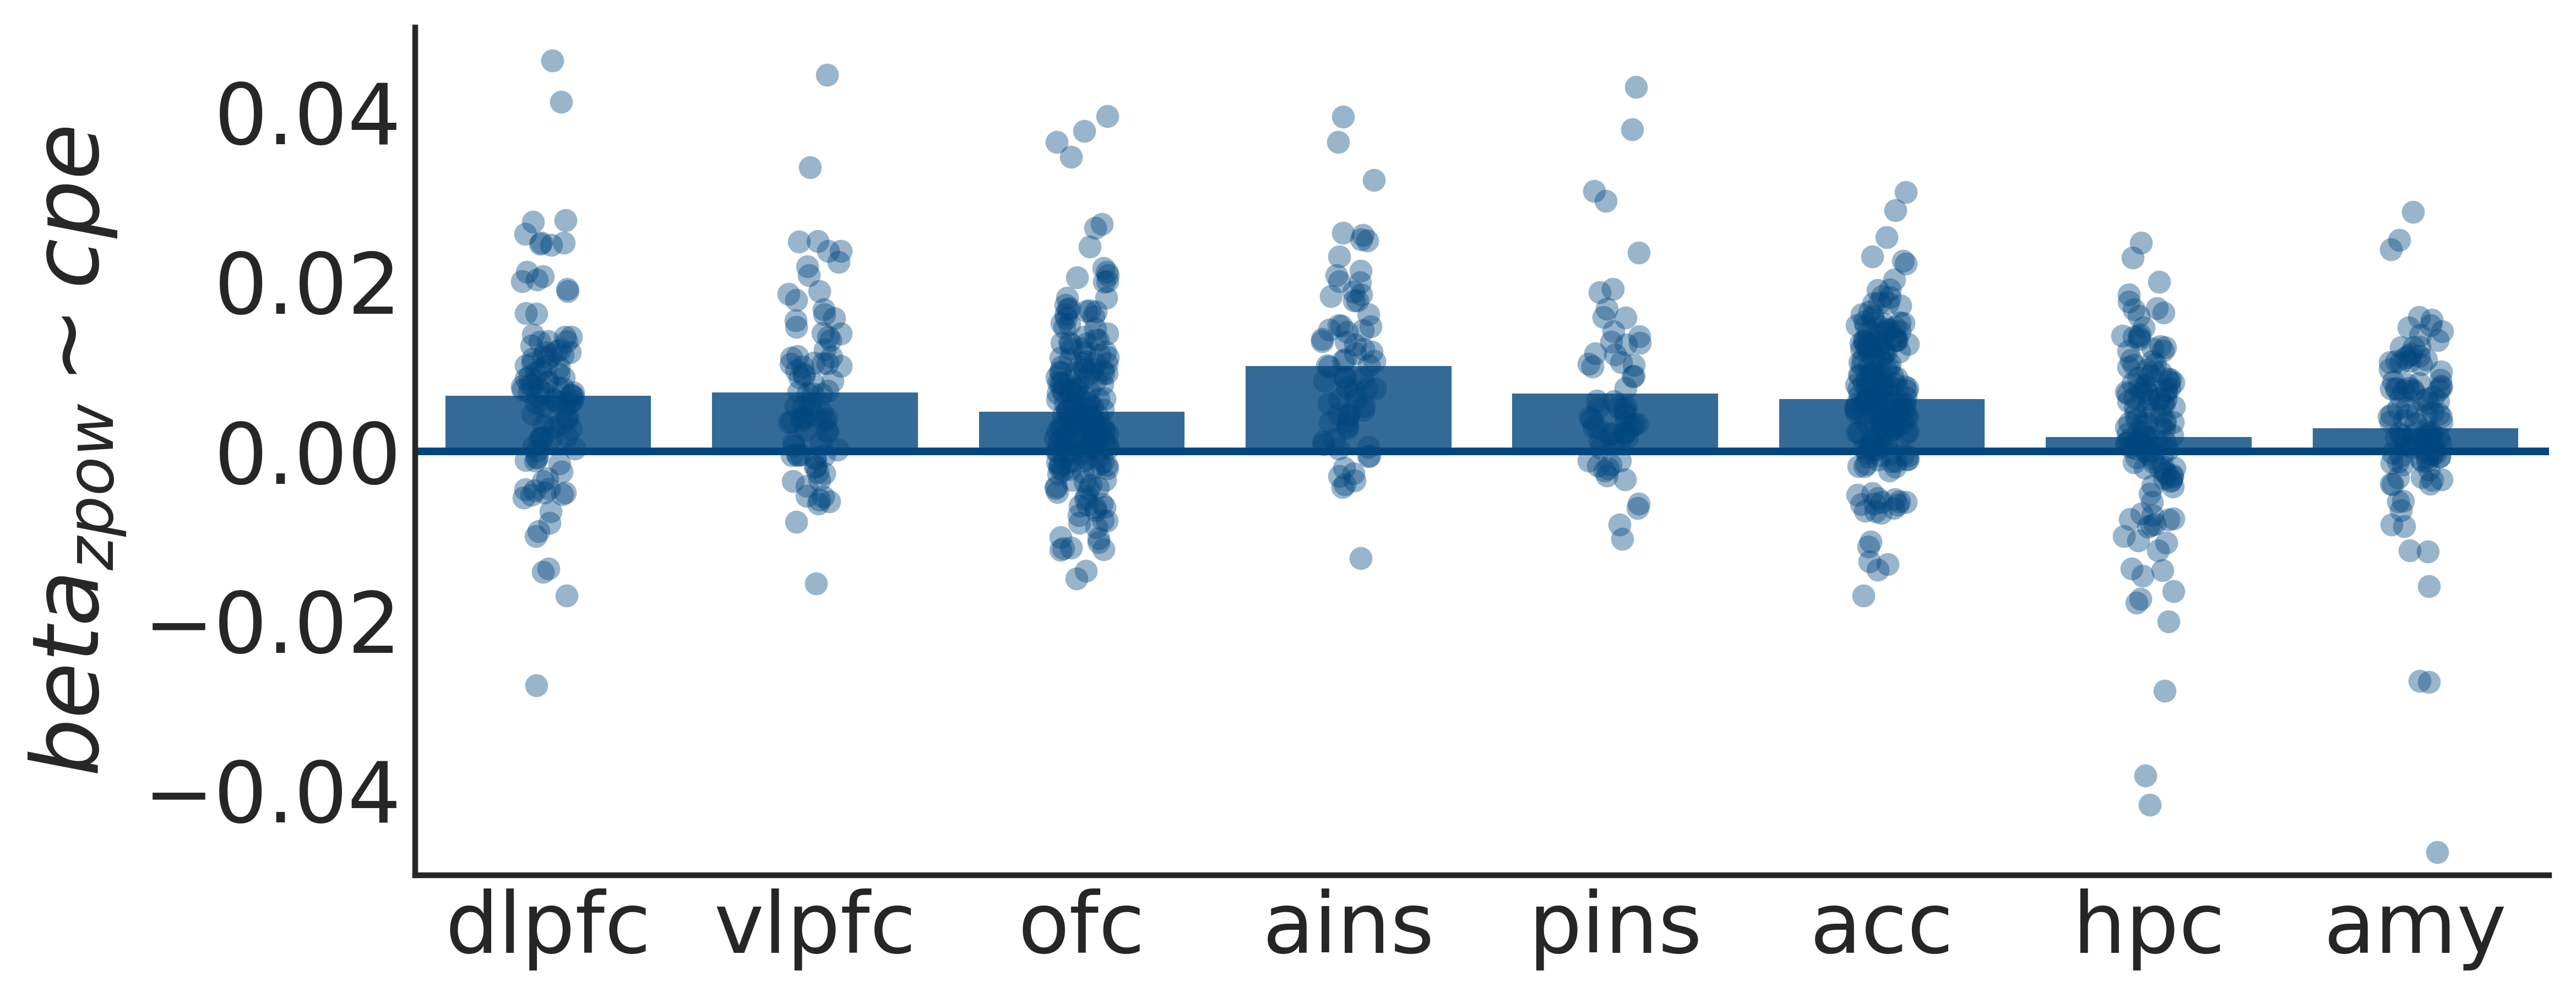

In [466]:
sns.set_context("poster",rc={'axes.linewidth': 1.5})
fig,ax = plt.subplots(figsize=(10, 4),dpi=500)

fig_save_dir = f'{base_dir}ephys_analysis/figs/beta_regressions/'
os.makedirs(fig_save_dir,exist_ok=True)

sns.barplot(data = roi_plot_data,
            x = 'roi',
            y = 'elec_bCPE',
#             y='raw_decisionCPE',
#             color = '#561C46',
#             color = '#00467e',
#             color = '#346a97',
            color = '#346a97',
            saturation=1,
            order=roi_order,
            errorbar=None) 


sns.stripplot(data = roi_plot_data,
            x = 'roi',
            y = 'elec_bCPE',
#               y='raw_decisionCPE',
#               color='#78496b', 
              color = '#00467e',
              alpha=.4,
              dodge=True,
              order=roi_order,
              size = 6)

ax.axhline(y=0,color='#00467e',linewidth=2)
plt.tick_params(length=0 )#,grid_linewidth=1)

plt.ylim([-0.05,0.05])
ax.set(xlabel=None)
# plt.ylabel('CPE Encoding in Beta Power (z)')
# plt.ylabel('beta(z) cpe encoding')
# plt.ylabel(r'$beta_{{{zpow}}}$'+ ' cpe encoding')
# plt.ylabel(r'$beta_{{{zpow}}}$'+ ' cpe encoding')
plt.ylabel(r'$beta_{{{zpow}}} \sim cpe$')
# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) 
# plt.locator_params(axis='y', nbins=5,tight=True)


sns.despine()
    
plt.savefig(f'{fig_save_dir}/Bpow_CPE_barplot_{date}.pdf', format='pdf', metadata=None,
bbox_inches=None, pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)


In [467]:
roi_plot_data.roi.unique().tolist()

['acc', 'hpc', 'amy', 'dlpfc', 'pins', 'ofc', 'ains', 'vlpfc']

In [468]:
bonferr_alpha

0.0025

In [469]:
rho_data = []
sig_rho = []

# bonferr_alpha = 0.05/len(roi_plot_data.roi.unique().tolist())
# bonferr_alpha = 0.05/9
bonferr_alpha = 0.01

# BDI CORRELATIONS
for roi in roi_plot_data.roi.unique().tolist()[:]:
    roi_temp_data = roi_plot_data[roi_plot_data.roi==roi]
    rho,rho_p     = spearmanr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
    rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':rho_p},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
#     if rho_p < bonferr_alpha:
    if rho_p < 0.05:
        sig_rho.append((roi,rho,rho_p))
    print(f'{roi} pearsonr',rho,rho_p)
rho_data = pd.concat(rho_data).reset_index(drop=True)


acc pearsonr -0.20394271228132785 0.004443671919227792
hpc pearsonr -0.21060985682971747 0.0142113240083365
amy pearsonr -0.2390614771355237 0.01076945132075288
dlpfc pearsonr -0.21053681370059868 0.029503723388177867
pins pearsonr 0.022953378421721852 0.8618034831395742
ofc pearsonr -0.26621200932066164 0.00012843657676767393
ains pearsonr -0.25490193924278953 0.031929497188770285
vlpfc pearsonr -0.17314471728859798 0.1198041102952722


In [470]:
rho_data

roi       rho     rho_p
0    acc -0.203943  0.004444
1    hpc -0.210610  0.014211
2    amy -0.239061  0.010769
3  dlpfc -0.210537  0.029504
4   pins  0.022953  0.861803
5    ofc -0.266212  0.000128
6   ains -0.254902  0.031929
7  vlpfc -0.173145  0.119804

In [471]:
sig_rho

[('acc', -0.20394271228132785, 0.004443671919227792),
 ('hpc', -0.21060985682971747, 0.0142113240083365),
 ('amy', -0.2390614771355237, 0.01076945132075288),
 ('dlpfc', -0.21053681370059868, 0.029503723388177867),
 ('ofc', -0.26621200932066164, 0.00012843657676767393),
 ('ains', -0.25490193924278953, 0.031929497188770285)]

In [472]:
rho_data['round_rho'] = np.round(rho_data.rho,2)
rho_data['round_p']   = np.round(rho_data.rho_p,2)
rho_data['round_p'][rho_data.roi == 'acc'] = 0.01
rho_data['round_p'][rho_data.roi == 'ofc'] = 0.01
rho_data

roi       rho     rho_p  round_rho  round_p
0    acc -0.203943  0.004444      -0.20     0.01
1    hpc -0.210610  0.014211      -0.21     0.01
2    amy -0.239061  0.010769      -0.24     0.01
3  dlpfc -0.210537  0.029504      -0.21     0.03
4   pins  0.022953  0.861803       0.02     0.86
5    ofc -0.266212  0.000128      -0.27     0.01
6   ains -0.254902  0.031929      -0.25     0.03
7  vlpfc -0.173145  0.119804      -0.17     0.12

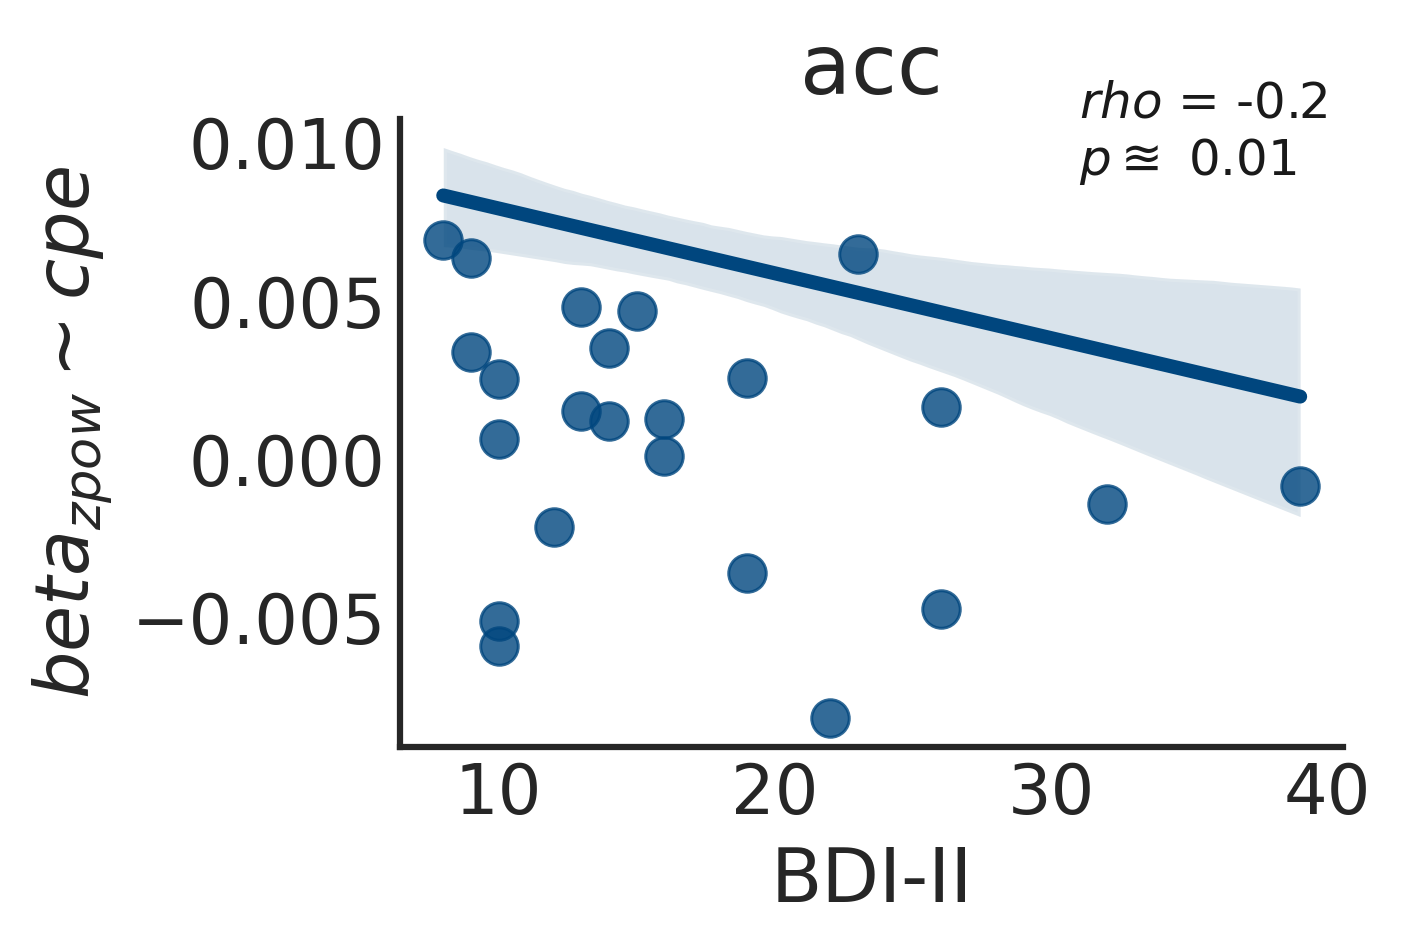

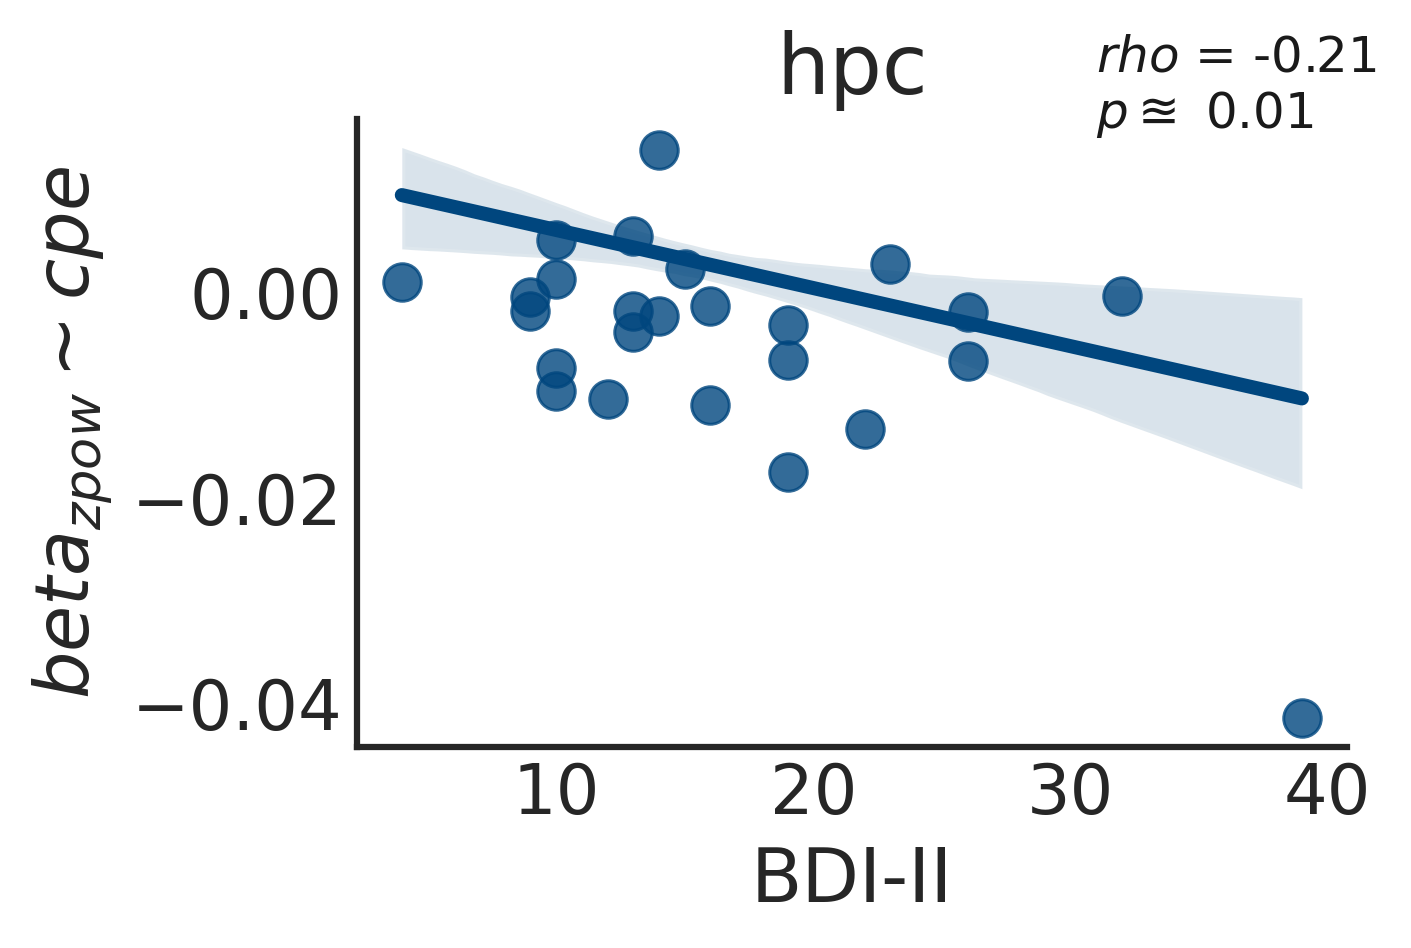

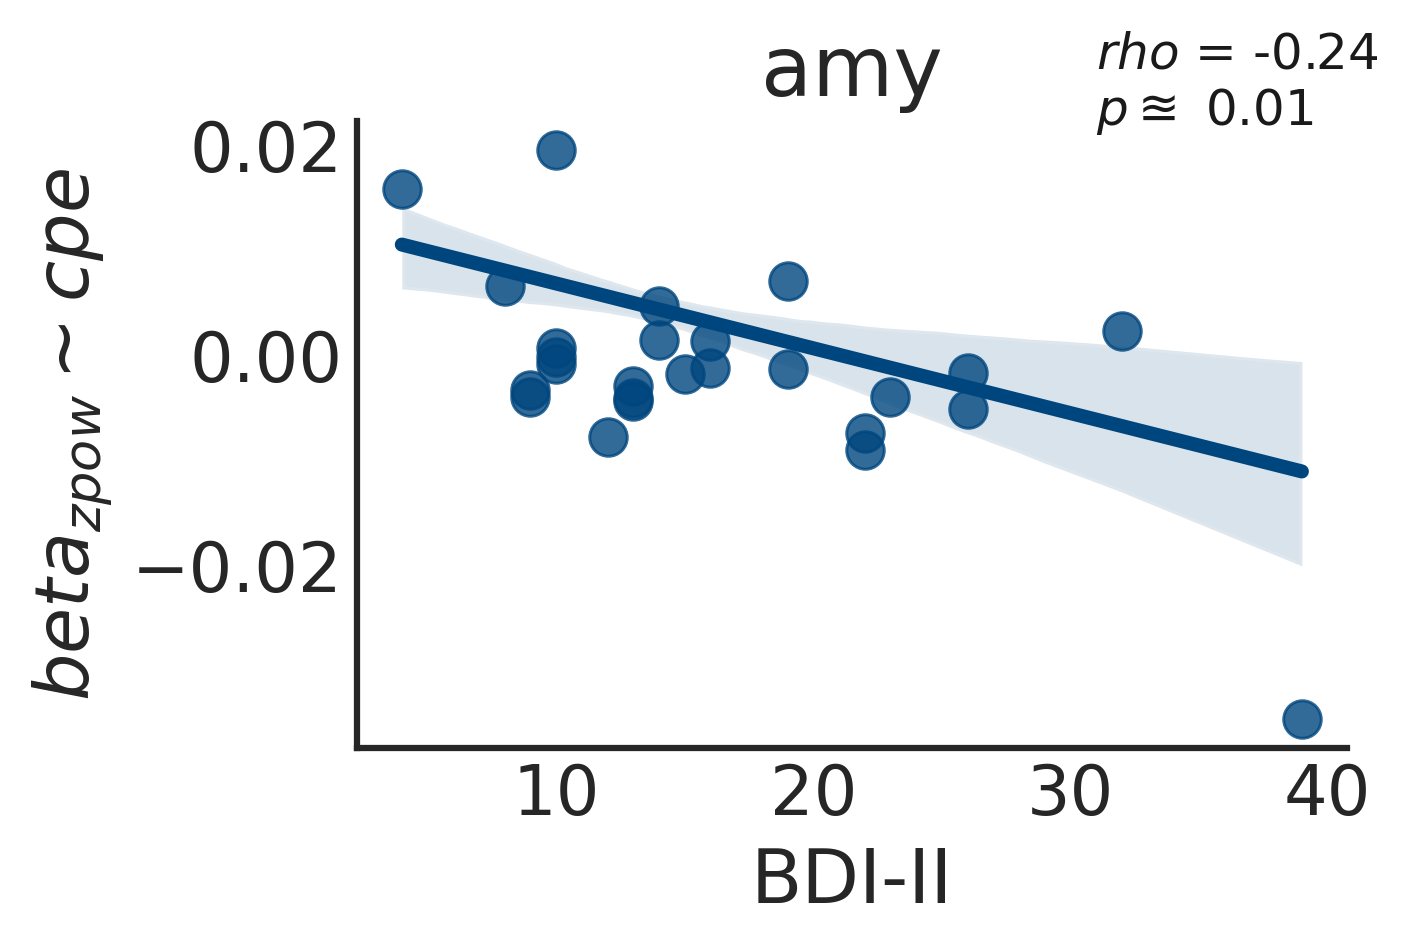

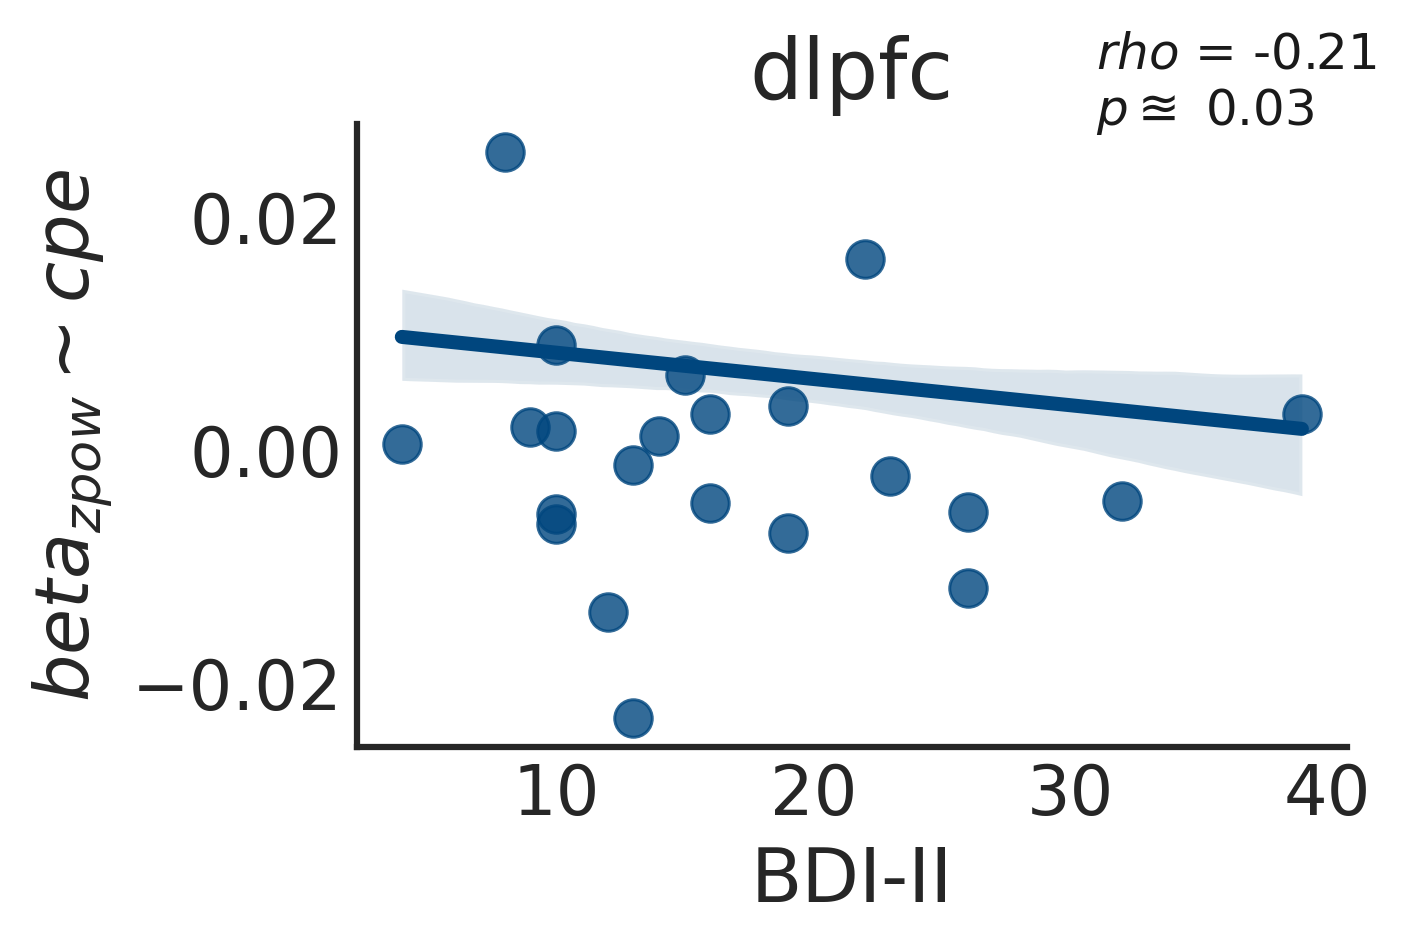

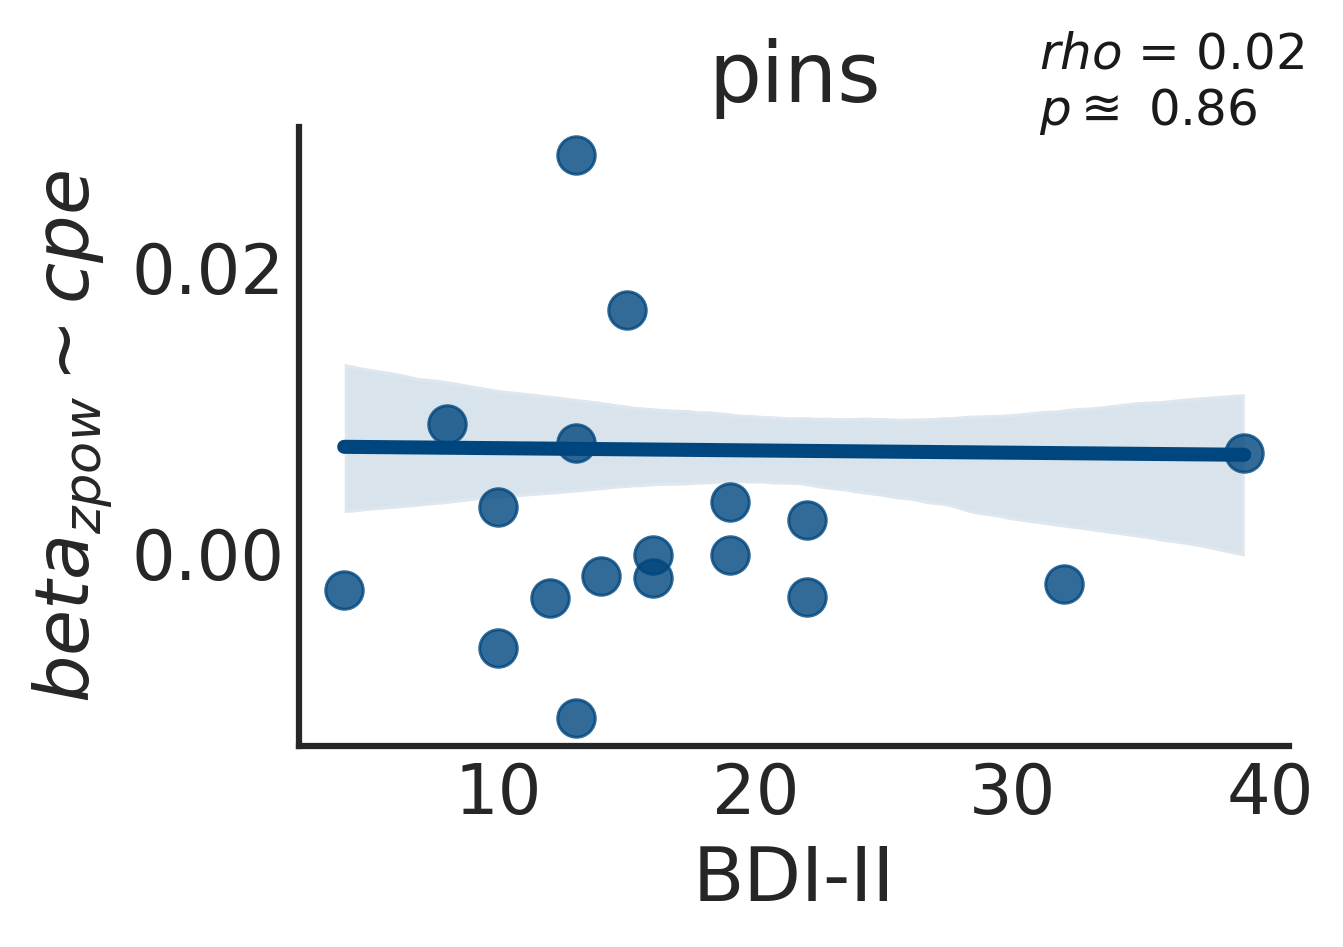

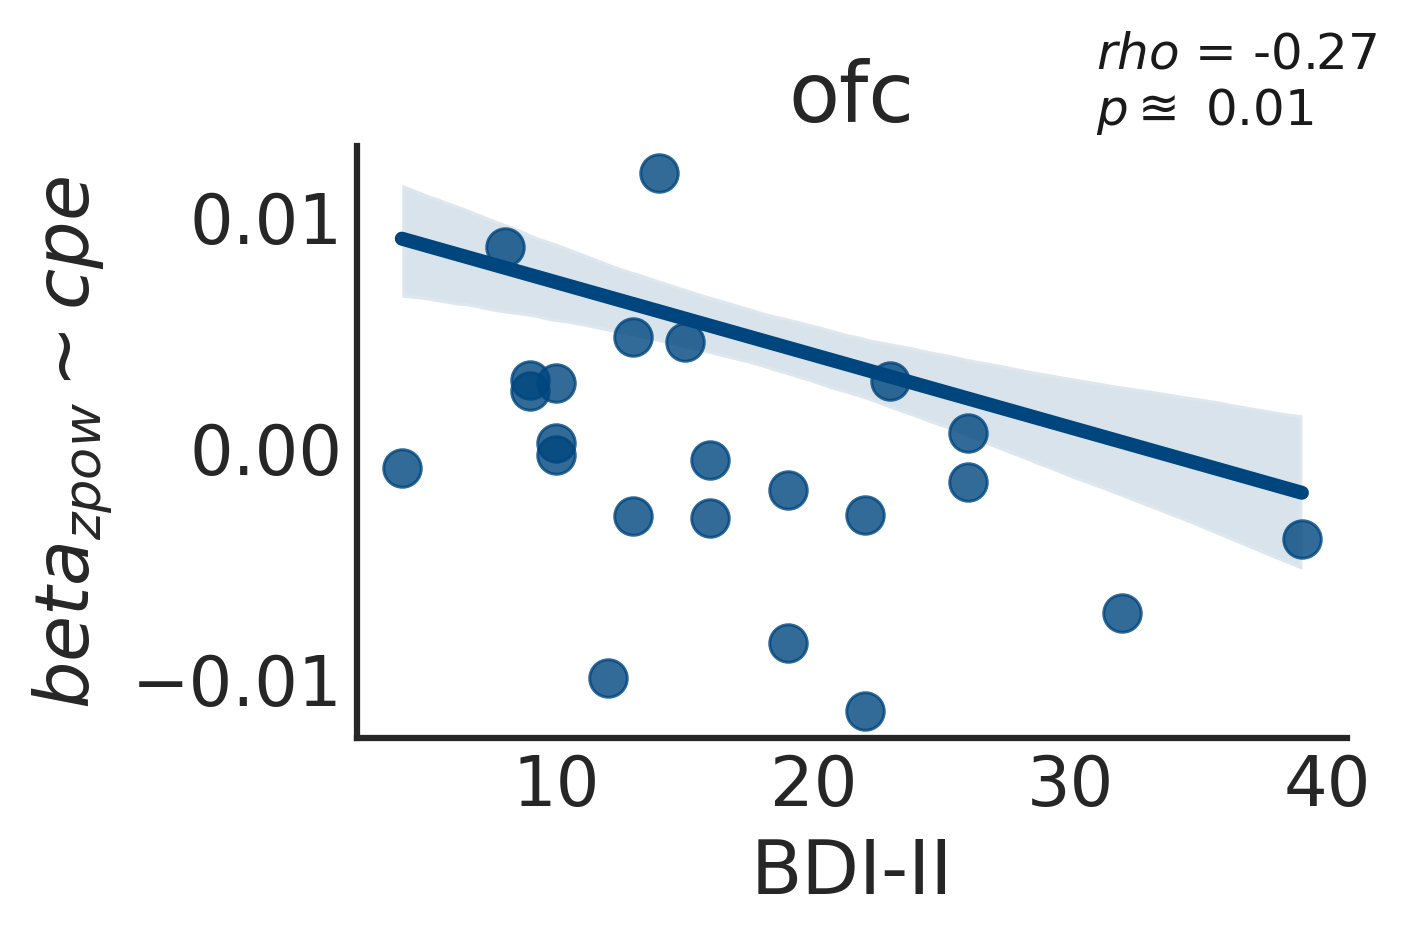

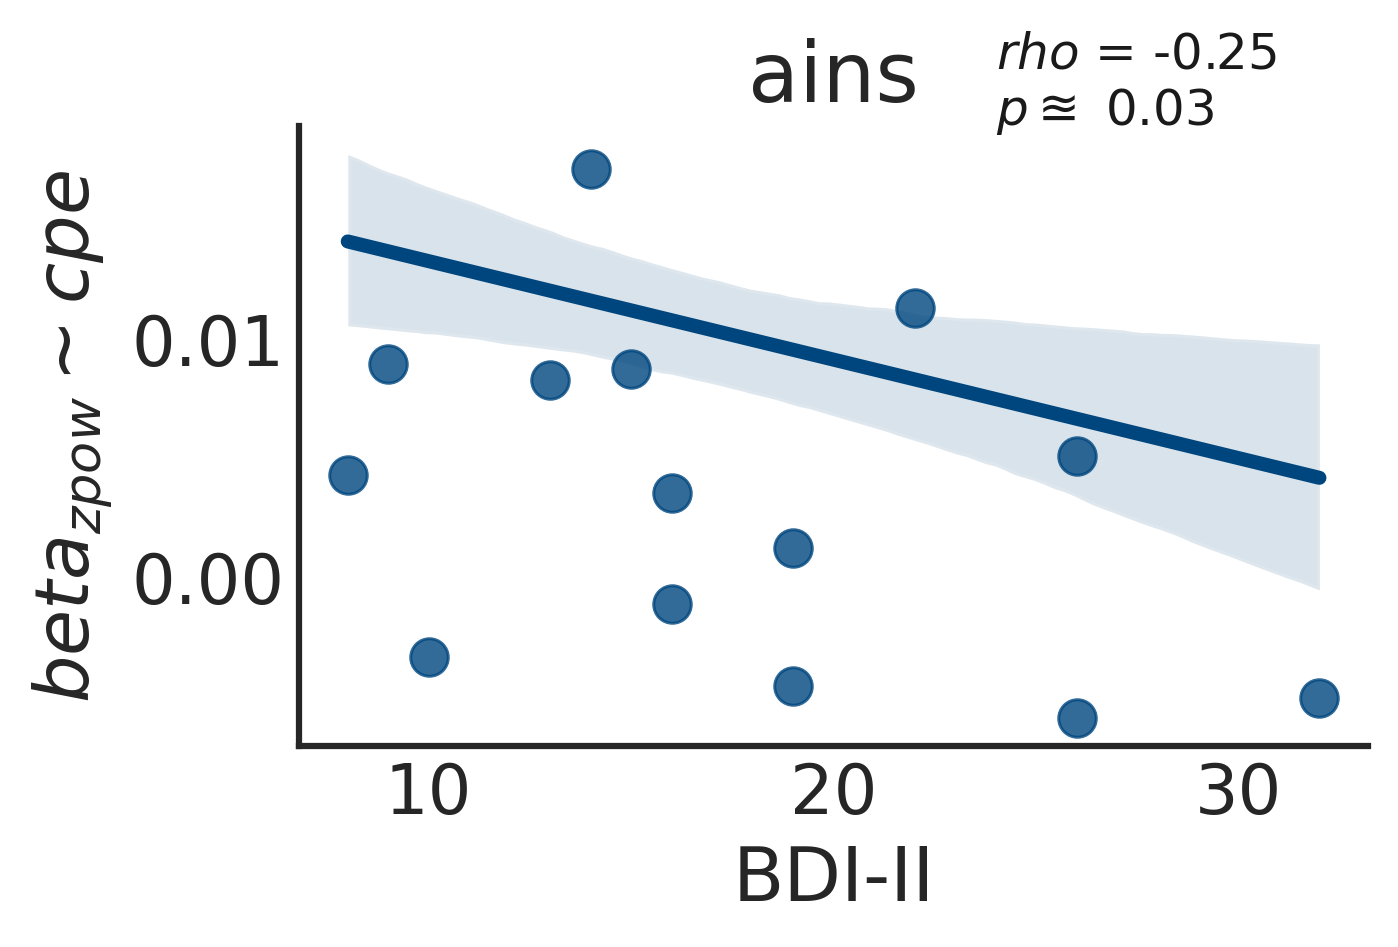

In [473]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in roi_plot_data.roi.unique().tolist()[:-1]:
    roi_temp_data = roi_plot_data[roi_plot_data.roi==roi]

    rho   = rho_data[rho_data.roi == roi].round_rho.values[0]
    rho_p = rho_data[rho_data.roi == roi].round_p.values[0]
    
        
    fig,ax = plt.subplots(1,1,figsize=(5,3.5),dpi=300)

    sns.regplot(data=roi_temp_data,x='bdi',y='elec_bCPE',scatter=False,ci=95,
                fit_reg=True,color = '#00467e') #034975
    
    sns.scatterplot(data = roi_temp_data.groupby(['subj_id']).agg('mean'),x='bdi',
                    y='raw_decisionCPE',color = '#00467e',edgecolor=None,alpha=0.8)
    
#     plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
    plt.xlabel('BDI-II')
#     plt.xlim([0,40])
    
    plt.tick_params(length=0) 
#     plt.ylabel('beta'+r'$beta_{{{zpow}}}$'+' cpe encoding')
    plt.ylabel(r'$beta_{{{zpow}}} \sim cpe$')

    plt.text(np.max(roi_temp_data.bdi)-8,
             np.round(np.max(roi_temp_data.groupby(['subj_id']).agg('mean').elec_bCPE),3)-0.003,
             r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',color='k',fontsize=12)
#              color='#00467e',fontsize=16)
#     plt.text(0.8,0.8,r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',
#             verticalalignment='top', horizontalalignment='right',
#             color='k',fontsize=16)

    plt.title(f'{roi}',fontsize=20)
    plt.tight_layout()


    
    sns.despine()
    
    plt.savefig(f'{fig_save_dir}/{roi}_{rho}_{rho_p}_roi_bdi_beta-cpe-slope.pdf', format='pdf', metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=300,
        facecolor='auto', edgecolor='auto',
        backend=None)
    

# Beta x BDI Interaction
- Rerun final mixed effects model on each ROI separately
- Correlate random effects slopes for each regressor with BDI

In [474]:
rand_eff_var = 'unique_reref_ch'


In [475]:
beta_reg_df

Unnamed: 0 subj_id  bdi reref_ch_names      unique_reref_ch  epoch  \
0                0   MS002   14  lacas1-lacas2  MS002_lacas1-lacas2      0   
1                1   MS002   14  lacas2-lacas3  MS002_lacas2-lacas3      0   
2                2   MS002   14  lacas3-lacas4  MS002_lacas3-lacas4      0   
3                3   MS002   14  lacas4-lacas5  MS002_lacas4-lacas5      0   
4                4   MS002   14  lacas5-lacas6  MS002_lacas5-lacas6      0   
...            ...     ...  ...            ...                  ...    ...   
258468      258468   DA039   22      rtp6-rtp7      DA039_rtp6-rtp7    148   
258469      258469   DA039   22      rtp7-rtp8      DA039_rtp7-rtp8    148   
258470      258470   DA039   22  rsgcc6-rsgcc7  DA039_rsgcc6-rsgcc7    148   
258471      258471   DA039   22  rsgcc7-rsgcc8  DA039_rsgcc7-rsgcc8    148   
258472      258472   DA039   22  rvmot6-rvmot7  DA039_rvmot6-rvmot7    148   

             freq  band  band_pow            roi  ...   SafeBet GambleChoice  \
0       20.743342  beta -0.123971            acc  ... -0.007878         safe   
1       20.743342  beta -0.186139            acc  ... -0.007878         safe   
2       20.743342  beta -0.235353            acc  ... -0.007878         safe   
3       20.743342  beta -0.086471            acc  ... -0.007878         safe   
4       20.743342  beta -0.145393            acc  ... -0.007878         safe   
...           ...   ...       ...            ...  ...       ...          ...   
258468  20.743342  beta -0.198057  temporal pole  ... -0.047267         safe   
258469  20.743342  beta -0.240000  temporal pole  ... -0.047267         safe   
258470  20.743342  beta -0.199545          vlpfc  ... -0.047267         safe   
258471  20.743342  beta -0.294459          vlpfc  ... -0.047267         safe   
258472  20.743342  beta  0.047316          motor  ... -0.047267         safe   

       GambleChoice_t1   TrialEV    Profit  TotalProfit       RPE  \
0               gamble -0.437011 -0.032900    -1.028523 -0.008746   
1               gamble -0.437011 -0.032900    -1.028523 -0.008746   
2               gamble -0.437011 -0.032900    -1.028523 -0.008746   
3               gamble -0.437011 -0.032900    -1.028523 -0.008746   
4               gamble -0.437011 -0.032900    -1.028523 -0.008746   
...                ...       ...       ...          ...       ...   
258468          gamble -0.359505 -0.042732     0.993053  0.022985   
258469          gamble -0.359505 -0.042732     0.993053  0.022985   
258470          gamble -0.359505 -0.042732     0.993053  0.022985   
258471          gamble -0.359505 -0.042732     0.993053  0.022985   
258472          gamble -0.359505 -0.042732     0.993053  0.022985   

        decisionCPE  decisionRegret decisionRelief  
0         -0.395746       -0.287638      -0.392122  
1         -0.395746       -0.287638      -0.392122  
2         -0.395746       -0.287638      -0.392122  
3         -0.395746       -0.287638      -0.392122  
4         -0.395746       -0.287638      -0.392122  
...             ...             ...            ...  
258468    -0.272392       -0.115665      -0.334244  
258469    -0.272392       -0.115665      -0.334244  
258470    -0.272392       -0.115665      -0.334244  
258471    -0.272392       -0.115665      -0.334244  
258472    -0.272392       -0.115665      -0.334244  

[244136 rows x 33 columns]

In [476]:
bdi_vars    = ['decisionCPE','bdi','decisionCPE:bdi']
outcome_var = 'band_pow'

bdi_fit = fit_mixed_model(beta_reg_df,bdi_vars,outcome_var,rand_eff_var,reml=False)
print(bdi_fit.summary())
    

                   Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       band_pow  
No. Observations:         244112        Method:                   ML        
No. Groups:               1776          Scale:                    0.0415    
Min. group size:          65            Log-Likelihood:           37351.5334
Max. group size:          148           Converged:                No        
Mean group size:          137.5                                             
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         -0.040    0.008 -4.975 0.000 -0.055 -0.024
decisionCPE                        0.019    0.006  3.244 0.001  0.008  0.031
bdi                               -0.001    0.000 -2.403 0.016 -0.002 -0.000
decisionCPE:bdi    

In [477]:
fe_param_names = list(bdi_fit.fe_params.index[1:])
fe_param_names

['decisionCPE', 'bdi', 'decisionCPE:bdi']

In [478]:
bdi_plot_data = pd.concat([pd.DataFrame(
    {**{'subj_id':elec_id.split('_')[0],'reref_ch_names':elec_id.split('_')[1]},'unique_reref_ch':elec_id,
     **{f'raw_{param}':bdi_fit.random_effects[elec_id][param] for param in list(
            bdi_fit.random_effects[elec_id].index)}},index=[range(len(fe_param_names))])
        
    for elec_id in bdi_fit.random_effects.keys()]).reset_index(drop=True)

bdi_plot_data['roi'] = [beta_reg_df.roi[beta_reg_df.unique_reref_ch == row.unique_reref_ch].values[0]
                                for idx,row in bdi_plot_data.iterrows()]

bdi_plot_data['bdi'] = [subj_info_df.bdi[subj_info_df.subj_id == subj_id].values[0]
                                for subj_id in bdi_plot_data.subj_id]

In [479]:
bdi_plot_data

subj_id reref_ch_names      unique_reref_ch  raw_Group  raw_decisionCPE  \
0      DA023      lac1-lac2      DA023_lac1-lac2   0.065379         0.095221   
1      DA023    lac10-lac11    DA023_lac10-lac11   0.068762        -0.091462   
2      DA023      lac2-lac3      DA023_lac2-lac3   0.082994        -0.059390   
3      DA023      lac3-lac4      DA023_lac3-lac4   0.081076        -0.022485   
4      DA023      lac4-lac5      DA023_lac4-lac5   0.084265        -0.046192   
...      ...            ...                  ...        ...              ...   
1771   MS050  rmoif4-rmoif5  MS050_rmoif4-rmoif5   0.069076        -0.029413   
1772   MS050  rmoif5-rmoif6  MS050_rmoif5-rmoif6   0.092680         0.062687   
1773   MS050  rmoif6-rmoif7  MS050_rmoif6-rmoif7   0.103229         0.055187   
1774   MS050  rmoif7-rmoif8  MS050_rmoif7-rmoif8   0.089559         0.295374   
1775   MS050  rmoif8-rmoif9  MS050_rmoif8-rmoif9   0.103732         0.070728   

       raw_bdi  raw_decisionCPE:bdi    roi  bdi  
0    -0.001619            -0.005295    acc   14  
1    -0.001609             0.005232  dmpfc   14  
2    -0.001967             0.003440    acc   14  
3    -0.001939             0.001358    acc   14  
4    -0.002004             0.002698  dmpfc   14  
...        ...                  ...    ...  ...  
1771 -0.002600             0.001732    ofc    9  
1772 -0.003504            -0.003492    ofc    9  
1773 -0.003901            -0.003056    ofc    9  
1774 -0.003422            -0.016740    ofc    9  
1775 -0.003922            -0.003940  vlpfc    9  

[1776 rows x 9 columns]

In [480]:
#### Get all results for Figs!!!!

fe_intercept   = bdi_fit.params['Intercept']
fe_cpe_beta    = bdi_fit.params['decisionCPE:bdi']
fe_cpe_beta


-0.0008891784608647811

In [481]:
#### add fixed effects data to all_elec_plot_data
bdi_plot_data['elec_b0']   = np.add(bdi_plot_data.raw_Group,fe_intercept)
bdi_plot_data['elec_bCPE'] = np.add(bdi_plot_data['raw_decisionCPE:bdi'],fe_cpe_beta)
bdi_plot_data = bdi_plot_data[~bdi_plot_data.roi.isnull()]

In [482]:
bdi_plot_data

subj_id reref_ch_names      unique_reref_ch  raw_Group  raw_decisionCPE  \
0      DA023      lac1-lac2      DA023_lac1-lac2   0.065379         0.095221   
1      DA023    lac10-lac11    DA023_lac10-lac11   0.068762        -0.091462   
2      DA023      lac2-lac3      DA023_lac2-lac3   0.082994        -0.059390   
3      DA023      lac3-lac4      DA023_lac3-lac4   0.081076        -0.022485   
4      DA023      lac4-lac5      DA023_lac4-lac5   0.084265        -0.046192   
...      ...            ...                  ...        ...              ...   
1771   MS050  rmoif4-rmoif5  MS050_rmoif4-rmoif5   0.069076        -0.029413   
1772   MS050  rmoif5-rmoif6  MS050_rmoif5-rmoif6   0.092680         0.062687   
1773   MS050  rmoif6-rmoif7  MS050_rmoif6-rmoif7   0.103229         0.055187   
1774   MS050  rmoif7-rmoif8  MS050_rmoif7-rmoif8   0.089559         0.295374   
1775   MS050  rmoif8-rmoif9  MS050_rmoif8-rmoif9   0.103732         0.070728   

       raw_bdi  raw_decisionCPE:bdi    roi  bdi   elec_b0  elec_bCPE  
0    -0.001619            -0.005295    acc   14  0.025644  -0.006184  
1    -0.001609             0.005232  dmpfc   14  0.029027   0.004343  
2    -0.001967             0.003440    acc   14  0.043259   0.002551  
3    -0.001939             0.001358    acc   14  0.041341   0.000468  
4    -0.002004             0.002698  dmpfc   14  0.044530   0.001808  
...        ...                  ...    ...  ...       ...        ...  
1771 -0.002600             0.001732    ofc    9  0.029341   0.000842  
1772 -0.003504            -0.003492    ofc    9  0.052945  -0.004381  
1773 -0.003901            -0.003056    ofc    9  0.063494  -0.003945  
1774 -0.003422            -0.016740    ofc    9  0.049823  -0.017629  
1775 -0.003922            -0.003940  vlpfc    9  0.063997  -0.004829  

[1776 rows x 11 columns]

In [483]:
# raw_bdi

raw_roi_stats = {f'{roi}':ttest_1samp(bdi_plot_data['raw_bdi'][bdi_plot_data.roi == roi].unique(),
                 popmean=0) for roi in bdi_plot_data.roi.unique().tolist()}
raw_roi_stats

{'acc': TtestResult(statistic=-3.3943871643529873, pvalue=0.0008356057255968282, df=192),
 'dmpfc': TtestResult(statistic=0.8619981246044465, pvalue=0.3896489537313055, df=215),
 'hpc': TtestResult(statistic=1.9645171466404916, pvalue=0.05153934672907866, df=134),
 'sts': TtestResult(statistic=2.7338319980454115, pvalue=0.006993730443049036, df=154),
 'amy': TtestResult(statistic=1.2114093238618684, pvalue=0.22828833575193477, df=112),
 'parietal': TtestResult(statistic=-1.2126478205781426, pvalue=0.23757355065538666, df=23),
 'stg': TtestResult(statistic=2.7448144836513886, pvalue=0.007133919798280198, df=104),
 'mcc': TtestResult(statistic=0.6785897648933251, pvalue=0.503173167995083, df=27),
 'mtg': TtestResult(statistic=0.3775128577607533, pvalue=0.7072195332376368, df=56),
 'smg': TtestResult(statistic=2.151445606039197, pvalue=0.03516233928166317, df=65),
 'phg': TtestResult(statistic=2.732978577068174, pvalue=0.011593977408506076, df=24),
 'temporal pole': TtestResult(statistic=

In [484]:
raw_roi_stats = {f'{roi}':ttest_1samp(bdi_plot_data['raw_decisionCPE:bdi'][bdi_plot_data.roi == roi].unique(),
                 popmean=0) for roi in bdi_plot_data.roi.unique().tolist()}
raw_roi_stats

{'acc': TtestResult(statistic=0.4021978405928195, pvalue=0.687985820205302, df=192),
 'dmpfc': TtestResult(statistic=1.7222560584813458, pvalue=0.08646123354527187, df=215),
 'hpc': TtestResult(statistic=-1.1669309979441091, pvalue=0.24531068361445377, df=134),
 'sts': TtestResult(statistic=2.4753305794747993, pvalue=0.01439459121650219, df=154),
 'amy': TtestResult(statistic=0.6346521987158567, pvalue=0.5269495766878889, df=112),
 'parietal': TtestResult(statistic=-1.4795219734611118, pvalue=0.15256840047920653, df=23),
 'stg': TtestResult(statistic=-0.6566316271120811, pvalue=0.5128681525051407, df=104),
 'mcc': TtestResult(statistic=2.3301342119229314, pvalue=0.02751949643032271, df=27),
 'mtg': TtestResult(statistic=1.8832898600139207, pvalue=0.06485821478726463, df=56),
 'smg': TtestResult(statistic=-4.220745890672958, pvalue=7.718638190704016e-05, df=65),
 'phg': TtestResult(statistic=2.680407351882885, pvalue=0.013080508475952393, df=24),
 'temporal pole': TtestResult(statistic=

In [485]:
roi_stats = {f'{roi}':ttest_1samp(bdi_plot_data.elec_bCPE[bdi_plot_data.roi == roi].unique(),
                 popmean=0) for roi in bdi_plot_data.roi.unique().tolist()}
roi_stats

{'acc': TtestResult(statistic=-2.8428129655337977, pvalue=0.004955486988315224, df=192),
 'dmpfc': TtestResult(statistic=-1.3621760633273494, pvalue=0.17456770751048342, df=215),
 'hpc': TtestResult(statistic=-3.703218538020482, pvalue=0.0003101089048661257, df=134),
 'sts': TtestResult(statistic=0.7591295478422774, pvalue=0.44893544450402156, df=154),
 'amy': TtestResult(statistic=-1.960504832548367, pvalue=0.05242001166174339, df=112),
 'parietal': TtestResult(statistic=-2.409488271001184, pvalue=0.024377348036996732, df=23),
 'stg': TtestResult(statistic=-2.6575671898410067, pvalue=0.009112776187212646, df=104),
 'mcc': TtestResult(statistic=1.346582735959467, pvalue=0.18931063018133315, df=27),
 'mtg': TtestResult(statistic=0.3302124112572428, pvalue=0.742471659962576, df=56),
 'smg': TtestResult(statistic=-5.906924898093793, pvalue=1.3990470032288282e-07, df=65),
 'phg': TtestResult(statistic=0.8941499334310439, pvalue=0.38012124100664535, df=24),
 'temporal pole': TtestResult(sta

In [486]:
pairwise_ains_vals = bdi_plot_data.elec_bCPE[plot_data.roi == 'ains'].unique()

pairwise_roi_stats = {f'ains={roi}':ttest_ind(pairwise_ains_vals,bdi_plot_data.elec_bCPE[bdi_plot_data.roi == roi].unique(),
                 ) for roi in bdi_plot_data.roi.unique().tolist()}
pairwise_roi_stats


{'ains=acc': TtestResult(statistic=-2.8998224991709534, pvalue=0.004050342062077613, df=262.0),
 'ains=dmpfc': TtestResult(statistic=-3.3948743495858142, pvalue=0.0007841001987165019, df=285.0),
 'ains=hpc': TtestResult(statistic=-1.8162933926601308, pvalue=0.07079323145801238, df=204.0),
 'ains=sts': TtestResult(statistic=-3.2962002922652953, pvalue=0.0011394116102961306, df=224.0),
 'ains=amy': TtestResult(statistic=-2.720678555592301, pvalue=0.007146838520135845, df=182.0),
 'ains=parietal': TtestResult(statistic=-0.19233671623502188, pvalue=0.8478978274902482, df=93.0),
 'ains=stg': TtestResult(statistic=-1.763104555564681, pvalue=0.07963825291240341, df=174.0),
 'ains=mcc': TtestResult(statistic=-3.0750767610891314, pvalue=0.002733881120363267, df=97.0),
 'ains=mtg': TtestResult(statistic=-2.987511131390911, pvalue=0.0033813759848205223, df=126.0),
 'ains=smg': TtestResult(statistic=0.6441967587152478, pvalue=0.5205408688480562, df=135.0),
 'ains=phg': TtestResult(statistic=-2.520

In [487]:
pairwise_ains_vals = bdi_plot_data.elec_bCPE[plot_data.roi == 'ains'].unique()

pairwise_roi_stats_greater = {f'ains={roi}':ttest_ind(pairwise_ains_vals,bdi_plot_data.elec_bCPE[bdi_plot_data.roi == roi].unique(),
                 alternative='greater') for roi in bdi_plot_data.roi.unique().tolist()}
pairwise_roi_stats_greater

{'ains=acc': TtestResult(statistic=-2.8998224991709534, pvalue=0.9979748289689612, df=262.0),
 'ains=dmpfc': TtestResult(statistic=-3.3948743495858142, pvalue=0.9996079499006417, df=285.0),
 'ains=hpc': TtestResult(statistic=-1.8162933926601308, pvalue=0.9646033842709938, df=204.0),
 'ains=sts': TtestResult(statistic=-3.2962002922652953, pvalue=0.999430294194852, df=224.0),
 'ains=amy': TtestResult(statistic=-2.720678555592301, pvalue=0.9964265807399321, df=182.0),
 'ains=parietal': TtestResult(statistic=-0.19233671623502188, pvalue=0.576051086254876, df=93.0),
 'ains=stg': TtestResult(statistic=-1.763104555564681, pvalue=0.9601808735437983, df=174.0),
 'ains=mcc': TtestResult(statistic=-3.0750767610891314, pvalue=0.9986330594398184, df=97.0),
 'ains=mtg': TtestResult(statistic=-2.987511131390911, pvalue=0.9983093120075898, df=126.0),
 'ains=smg': TtestResult(statistic=0.6441967587152478, pvalue=0.2602704344240281, df=135.0),
 'ains=phg': TtestResult(statistic=-2.520543721167214, pvalu

In [488]:
pairwise_ains_vals = bdi_plot_data.elec_bCPE[bdi_plot_data.roi == 'ains'].unique()

pairwise_roi_stats_less = {f'ains={roi}':ttest_ind(pairwise_ains_vals,bdi_plot_data.elec_bCPE[bdi_plot_data.roi == roi].unique(),
                 alternative='less') for roi in bdi_plot_data.roi.unique().tolist()}
pairwise_roi_stats_less

{'ains=acc': TtestResult(statistic=-2.8998224991709534, pvalue=0.0020251710310388066, df=262.0),
 'ains=dmpfc': TtestResult(statistic=-3.3948743495858142, pvalue=0.00039205009935825097, df=285.0),
 'ains=hpc': TtestResult(statistic=-1.8162933926601308, pvalue=0.03539661572900619, df=204.0),
 'ains=sts': TtestResult(statistic=-3.2962002922652953, pvalue=0.0005697058051480653, df=224.0),
 'ains=amy': TtestResult(statistic=-2.720678555592301, pvalue=0.0035734192600679225, df=182.0),
 'ains=parietal': TtestResult(statistic=-0.19233671623502188, pvalue=0.4239489137451241, df=93.0),
 'ains=stg': TtestResult(statistic=-1.763104555564681, pvalue=0.039819126456201705, df=174.0),
 'ains=mcc': TtestResult(statistic=-3.0750767610891314, pvalue=0.0013669405601816336, df=97.0),
 'ains=mtg': TtestResult(statistic=-2.987511131390911, pvalue=0.0016906879924102611, df=126.0),
 'ains=smg': TtestResult(statistic=0.6441967587152478, pvalue=0.7397295655759719, df=135.0),
 'ains=phg': TtestResult(statistic=-

In [489]:
bonferr_alpha = 0.05/len(roi_order)
bonferr_alpha

0.00625

In [490]:
print('sig ROIs after multiple comp correction: ',[(roi,raw_roi_stats[roi].pvalue) for roi in raw_roi_stats.keys()
                                                   if raw_roi_stats[roi].pvalue< bonferr_alpha])
# print('sig ROI pvals: ',roi_stats.roi_cpe_pval[roi_beta_results.roi_cpe_pval<=bonferr_alpha].unique().tolist())

sig_raw = [(roi,raw_roi_stats[roi].pvalue) for roi in raw_roi_stats.keys()
                                                   if raw_roi_stats[roi].pvalue< bonferr_alpha]

sig_raw_rois = list(zip(*sig_raw))[0]

sig ROIs after multiple comp correction:  [('smg', 7.718638190704016e-05)]


In [491]:
sig_raw_rois

('smg',)

In [492]:
print('sig ROIs after multiple comp correction: ',[(roi,roi_stats[roi].pvalue) for roi in roi_stats.keys()
                                                   if roi_stats[roi].pvalue< bonferr_alpha])
# print('sig ROI pvals: ',roi_stats.roi_cpe_pval[roi_beta_results.roi_cpe_pval<=bonferr_alpha].unique().tolist())
sig_bcpe = [(roi,roi_stats[roi].pvalue) for roi in roi_stats.keys()
                                                   if roi_stats[roi].pvalue< bonferr_alpha]

sig_bcpe_rois = list(zip(*sig_bcpe))[0]

sig ROIs after multiple comp correction:  [('acc', 0.004955486988315224), ('hpc', 0.0003101089048661257), ('smg', 1.3990470032288282e-07), ('ofc', 0.0003089983603806593), ('ains', 0.0003673758299931852), ('vlpfc', 0.0044464619064377015)]


In [493]:
list(zip(*sig_bcpe))[0]

('acc', 'hpc', 'smg', 'ofc', 'ains', 'vlpfc')

In [494]:
print('sig ROIs after multiple comp correction: ',[(roi,pairwise_roi_stats_greater[roi].pvalue) for 
                                                   roi in pairwise_roi_stats_greater.keys()
                                                   if pairwise_roi_stats_greater[roi].pvalue< bonferr_alpha])
# print('sig ROI pvals: ',roi_stats.roi_cpe_pval[roi_beta_results.roi_cpe_pval<=bonferr_alpha].unique().tolist())
sig_bcpe = [(roi,pairwise_roi_stats_greater[roi].pvalue) for roi in pairwise_roi_stats_greater.keys()
                                                   if pairwise_roi_stats_greater[roi].pvalue< bonferr_alpha]

# sig_bcpe_rois = list(zip(*sig_bcpe))[0]

sig ROIs after multiple comp correction:  []


In [495]:
# sig_bcpe_rois 

In [496]:
print('sig ROIs after multiple comp correction: ',[(roi,pairwise_roi_stats_less[roi].pvalue) for 
                                                   roi in pairwise_roi_stats_less.keys()
                                                   if pairwise_roi_stats_less[roi].pvalue< bonferr_alpha])
# print('sig ROI pvals: ',roi_stats.roi_cpe_pval[roi_beta_results.roi_cpe_pval<=bonferr_alpha].unique().tolist())
sig_bcpe = [(roi,pairwise_roi_stats_less[roi].pvalue) for roi in pairwise_roi_stats_less.keys()
                                                   if pairwise_roi_stats_less[roi].pvalue< bonferr_alpha]

sig_bcpe_rois = list(zip(*sig_bcpe))[0]

sig ROIs after multiple comp correction:  [('ains=acc', 0.0020251710310388066), ('ains=dmpfc', 0.00039205009935825097), ('ains=sts', 0.0005697058051480653), ('ains=amy', 0.0035734192600679225), ('ains=mcc', 0.0013669405601816336), ('ains=mtg', 0.0016906879924102611)]


In [497]:
print('sig ROIs after multiple comp correction: ',[(roi,pairwise_roi_stats[roi].pvalue) for 
                                                   roi in pairwise_roi_stats.keys()
                                                   if pairwise_roi_stats[roi].pvalue< bonferr_alpha])

sig_bcpe = [(roi,pairwise_roi_stats[roi].pvalue) for roi in pairwise_roi_stats.keys()
                                                   if pairwise_roi_stats[roi].pvalue< bonferr_alpha]

sig_bcpe_rois = list(zip(*sig_bcpe))[0]

sig ROIs after multiple comp correction:  [('ains=acc', 0.004050342062077613), ('ains=dmpfc', 0.0007841001987165019), ('ains=sts', 0.0011394116102961306), ('ains=mcc', 0.002733881120363267), ('ains=mtg', 0.0033813759848205223)]


In [498]:
sig_bcpe_rois

('ains=acc', 'ains=dmpfc', 'ains=sts', 'ains=mcc', 'ains=mtg')

In [499]:
len([(roi,roi_stats[roi].pvalue) for roi in roi_stats.keys()
                                                   if roi_stats[roi].pvalue< bonferr_alpha])

6

In [500]:
roi_stats.keys()

dict_keys(['acc', 'dmpfc', 'hpc', 'sts', 'amy', 'parietal', 'stg', 'mcc', 'mtg', 'smg', 'phg', 'temporal pole', 'dlpfc', 'pins', 'motor', 'ofc', 'ains', 'vlpfc', 'vmpfc', 'thalamus'])

In [501]:
# roi_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','hpc','amy','mtg','motor','thalamus']
roi_order = ['dlpfc','vlpfc','ofc','ains','pins','acc','hpc','amy']

In [502]:
roi_plot_data = bdi_plot_data.copy()
roi_plot_data = roi_plot_data[roi_plot_data.roi.isin(roi_order)]

# roi_plot_names = {'thalamus':'THAL','hpc':'HPC','amy':'AMY','acc':'ACC','ofc':'OFC','ains':'aINS',
#                   'pins':'pINS','dmpfc':'dmPFC','dlpfc':'dlPFC','vlpfc':'vlPFC'}


In [505]:
bdi_plot_data.roi.unique()

array(['acc', 'dmpfc', 'hpc', 'sts', 'amy', 'parietal', 'stg', 'mcc',
       'mtg', 'smg', 'phg', 'temporal pole', 'dlpfc', 'pins', 'motor',
       'ofc', 'ains', 'vlpfc', 'vmpfc', 'thalamus'], dtype=object)

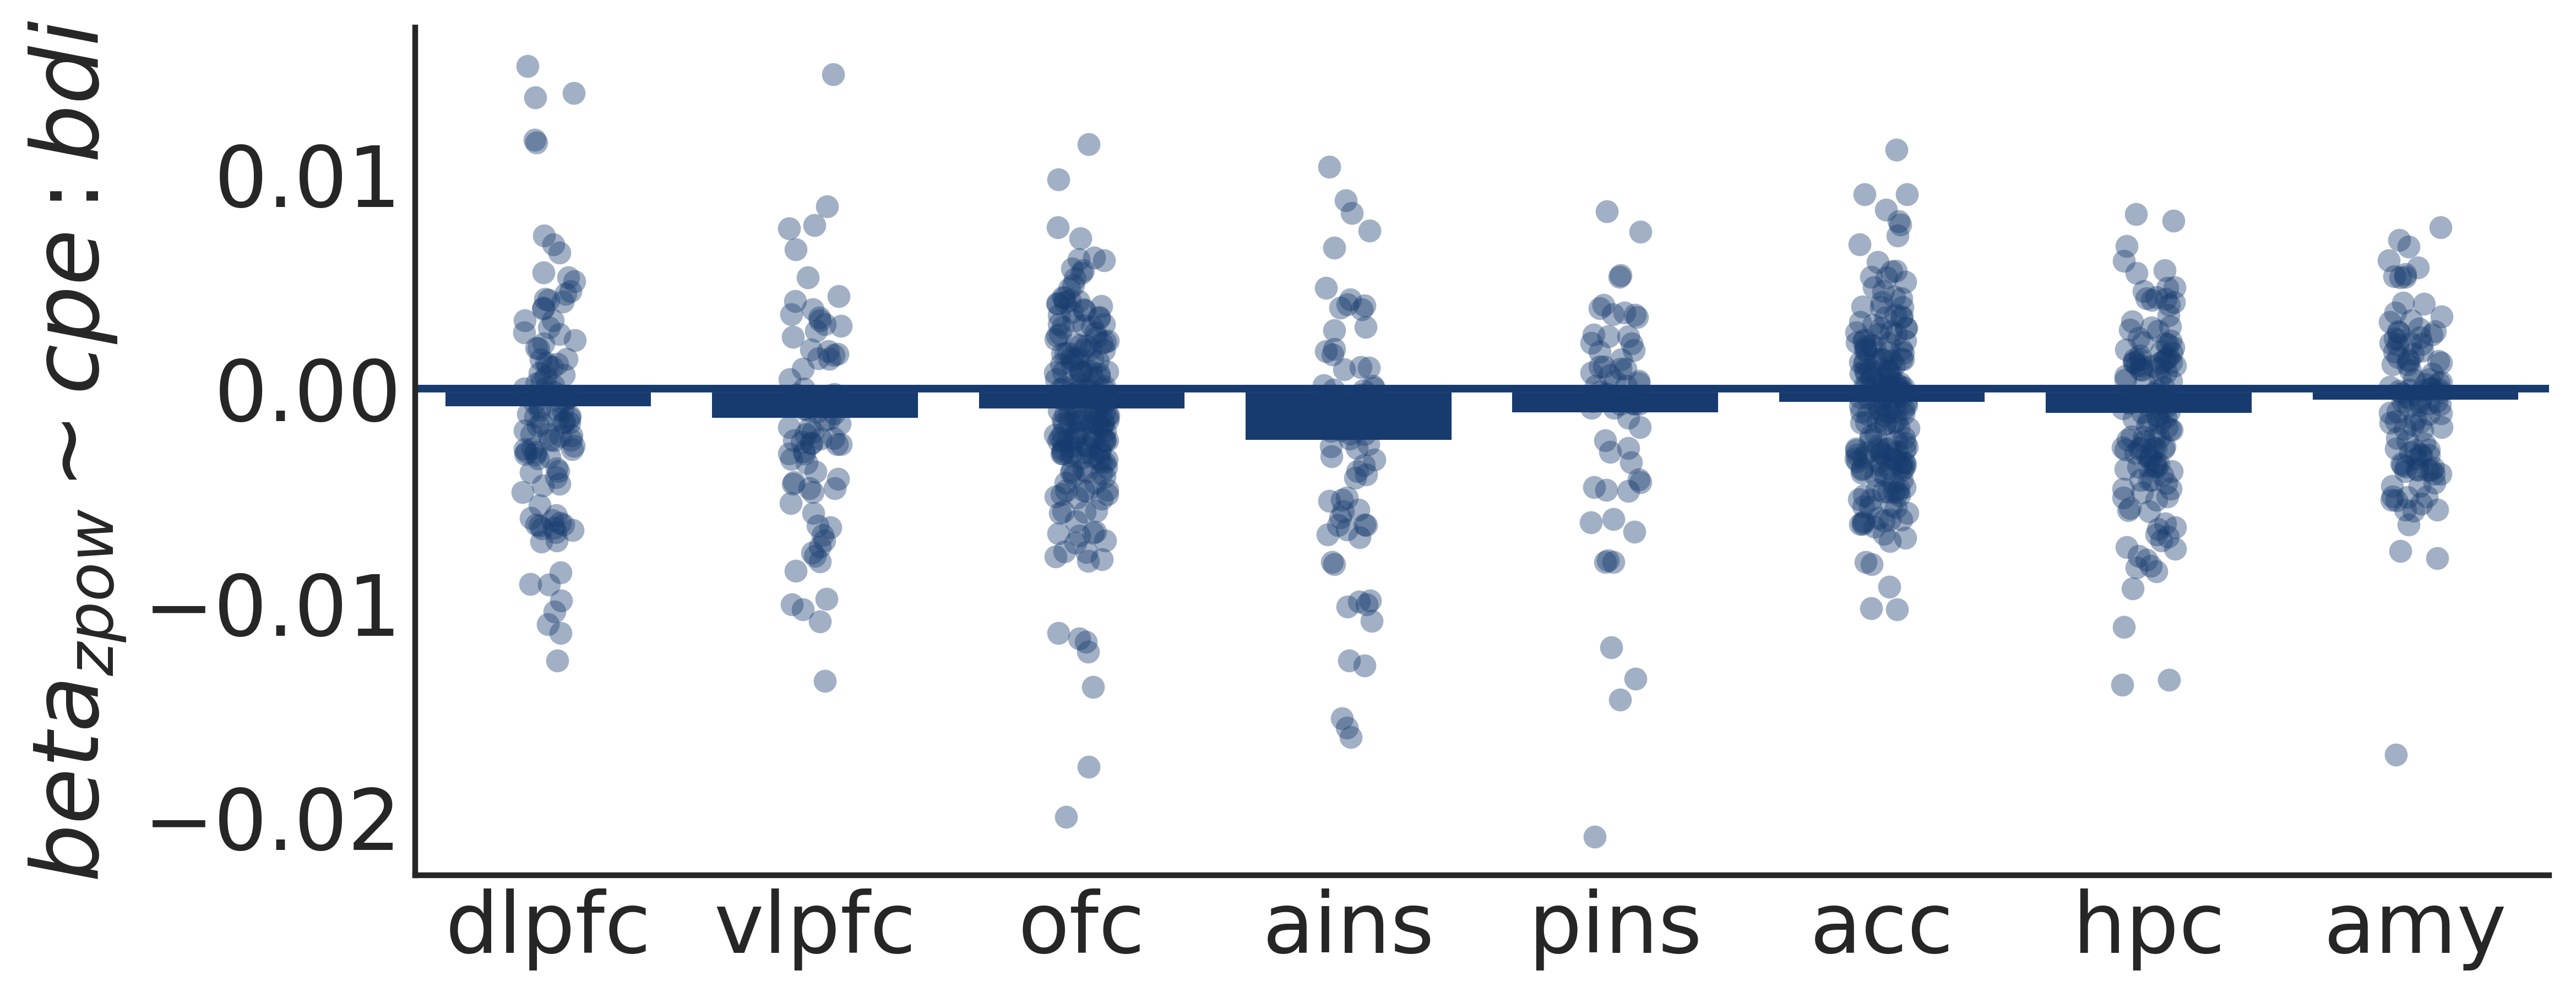

In [506]:
sns.set_context("poster",rc={'axes.linewidth': 1.5})
fig,ax = plt.subplots(figsize=(10, 4),dpi=500)

fig_save_dir = f'{base_dir}ephys_analysis/figs/beta_regressions/'
os.makedirs(fig_save_dir,exist_ok=True)

sns.barplot(data = bdi_plot_data,
            x = 'roi',
            y = 'elec_bCPE',
#             y='raw_decisionCPE',
#             color = '#561C46',
#             color = '#00467e',
#             color = '#346a97',
            color = '#173b6f',
            saturation=1,
            order=roi_order,
            errorbar=None) 


sns.stripplot(data = bdi_plot_data,
            x = 'roi',
            y = 'elec_bCPE',
#               y='raw_decisionCPE',
#               color='#78496b', 
              color = '#173b6f',
              alpha=.4,
              dodge=True,
              order=roi_order,
              size = 6)

ax.axhline(y=0,color='#173b6f',linewidth=2)
plt.tick_params(length=0 )#,grid_linewidth=1)

# plt.ylim([-0.05,0.05])
ax.set(xlabel=None)
# plt.ylabel('CPE Encoding in Beta Power (z)')
# plt.ylabel('beta(z) cpe encoding')
# plt.ylabel(r'$beta_{{{zpow}}}$'+ ' cpe encoding')
# plt.ylabel(r'$beta_{{{zpow}}}$'+ ' cpe encoding')
plt.ylabel(r'$beta_{{{zpow}}} \sim cpe:bdi$')
# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) 
# plt.locator_params(axis='y', nbins=5,tight=True)


sns.despine()
    
plt.savefig(f'{fig_save_dir}/Bpow_CPE:BDI_barplot_{date}.pdf', format='pdf', metadata=None,
bbox_inches=None, pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)


In [507]:
bdi_plot_data.roi.unique().tolist()

['acc',
 'dmpfc',
 'hpc',
 'sts',
 'amy',
 'parietal',
 'stg',
 'mcc',
 'mtg',
 'smg',
 'phg',
 'temporal pole',
 'dlpfc',
 'pins',
 'motor',
 'ofc',
 'ains',
 'vlpfc',
 'vmpfc',
 'thalamus']

In [334]:
bonferr_alpha

0.01

In [508]:
rho_data = []
sig_rho = []

# bonferr_alpha = 0.05/len(roi_plot_data.roi.unique().tolist())
# bonferr_alpha = 0.05/9
bonferr_alpha = 0.01

# BDI CORRELATIONS
for roi in roi_plot_data.roi.unique().tolist()[:]:
    roi_temp_data = roi_plot_data[roi_plot_data.roi==roi]
    rho,rho_p     = spearmanr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
    rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':rho_p},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
#     if rho_p < bonferr_alpha:
    if rho_p < 0.05:
        sig_rho.append((roi,rho,rho_p))
    print(f'{roi} pearsonr',rho,rho_p)
rho_data = pd.concat(rho_data).reset_index(drop=True)


acc pearsonr 0.07689516812988142 0.2878287104623355
hpc pearsonr 0.029455406922839794 0.7345102722399418
amy pearsonr -0.07299819762047612 0.4422617390826744
dlpfc pearsonr 0.22409545563021915 0.020317698193600055
pins pearsonr 0.221788779228294 0.08854710934514388
ofc pearsonr 0.10391145438338463 0.1411070343223994
ains pearsonr 0.3464730751091468 0.0030775819049579695
vlpfc pearsonr 0.15101269622152413 0.17565170063258165


In [509]:
rho_data

roi       rho     rho_p
0    acc  0.076895  0.287829
1    hpc  0.029455  0.734510
2    amy -0.072998  0.442262
3  dlpfc  0.224095  0.020318
4   pins  0.221789  0.088547
5    ofc  0.103911  0.141107
6   ains  0.346473  0.003078
7  vlpfc  0.151013  0.175652

In [510]:
sig_rho

[('dlpfc', 0.22409545563021915, 0.020317698193600055),
 ('ains', 0.3464730751091468, 0.0030775819049579695)]

In [511]:
rho_data['round_rho'] = np.round(rho_data.rho,2)
rho_data['round_p']   = np.round(rho_data.rho_p,3)
# rho_data['round_p'][rho_data.roi == 'acc'] = 0.01
# rho_data['round_p'][rho_data.roi == 'ofc'] = 0.01
rho_data

roi       rho     rho_p  round_rho  round_p
0    acc  0.076895  0.287829       0.08    0.288
1    hpc  0.029455  0.734510       0.03    0.735
2    amy -0.072998  0.442262      -0.07    0.442
3  dlpfc  0.224095  0.020318       0.22    0.020
4   pins  0.221789  0.088547       0.22    0.089
5    ofc  0.103911  0.141107       0.10    0.141
6   ains  0.346473  0.003078       0.35    0.003
7  vlpfc  0.151013  0.175652       0.15    0.176

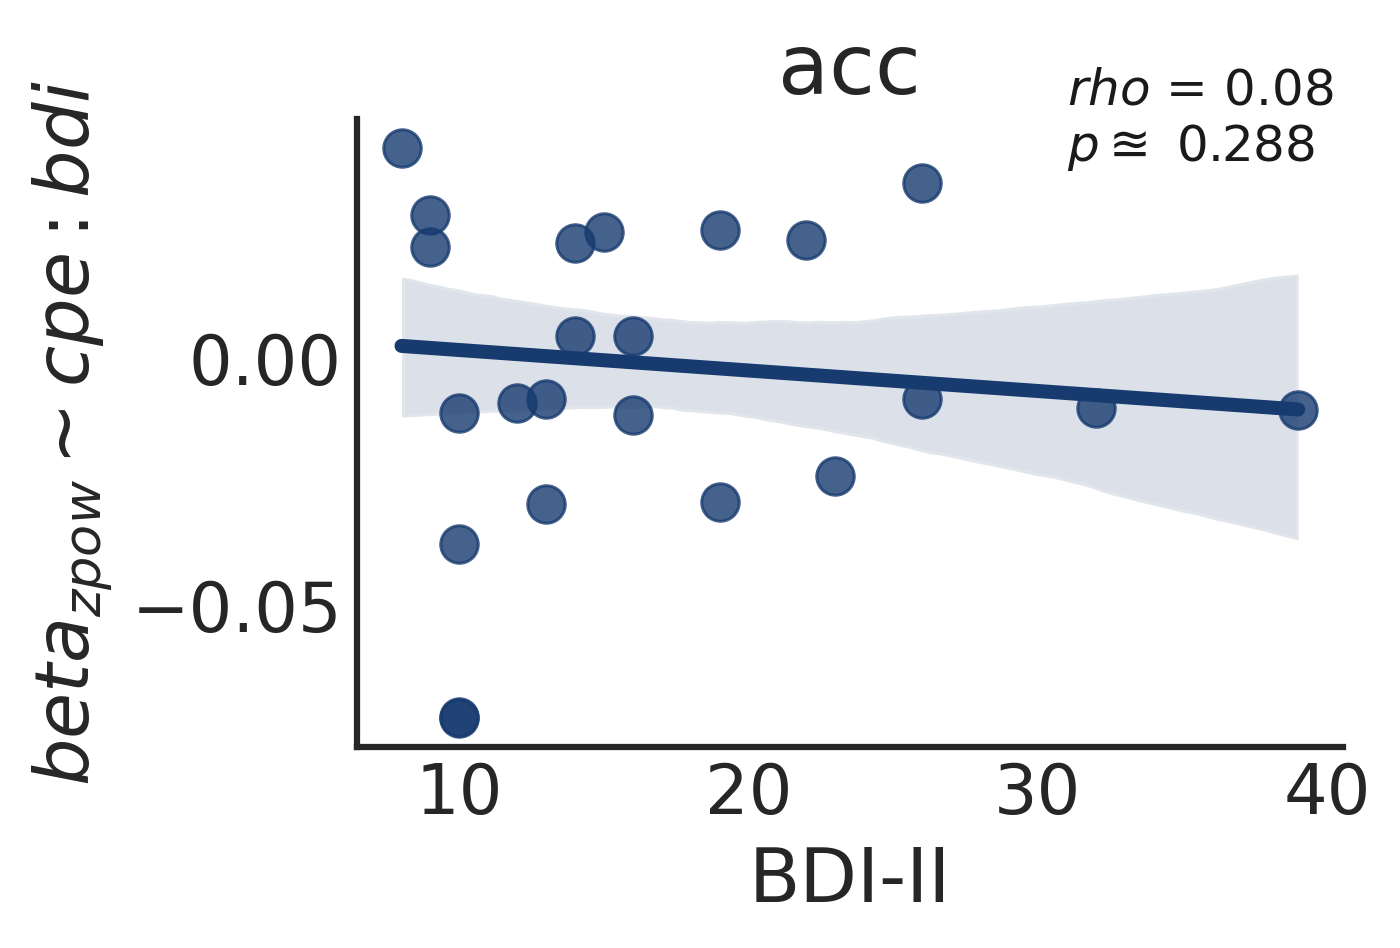

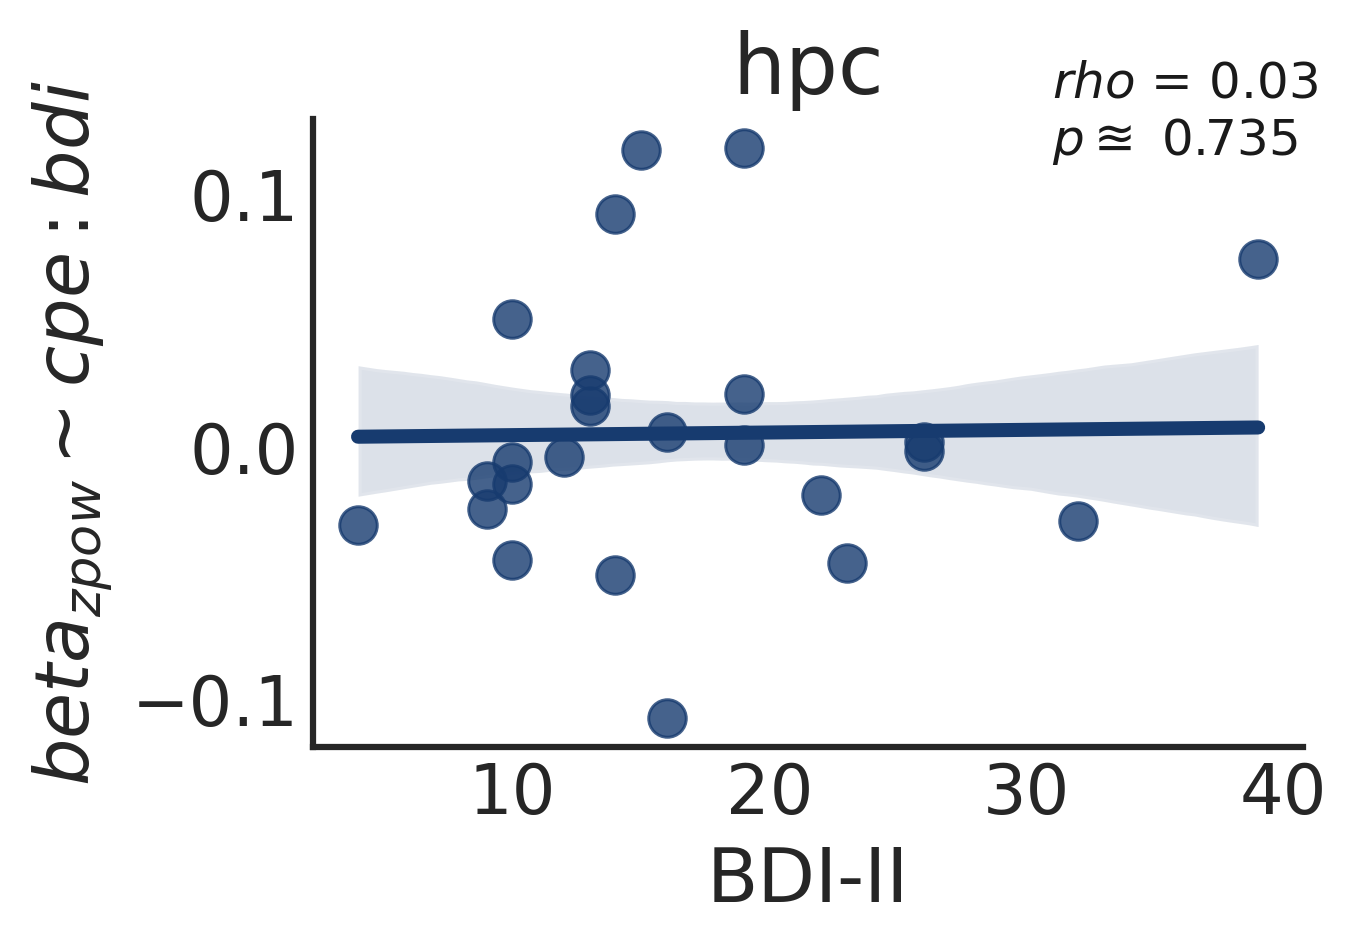

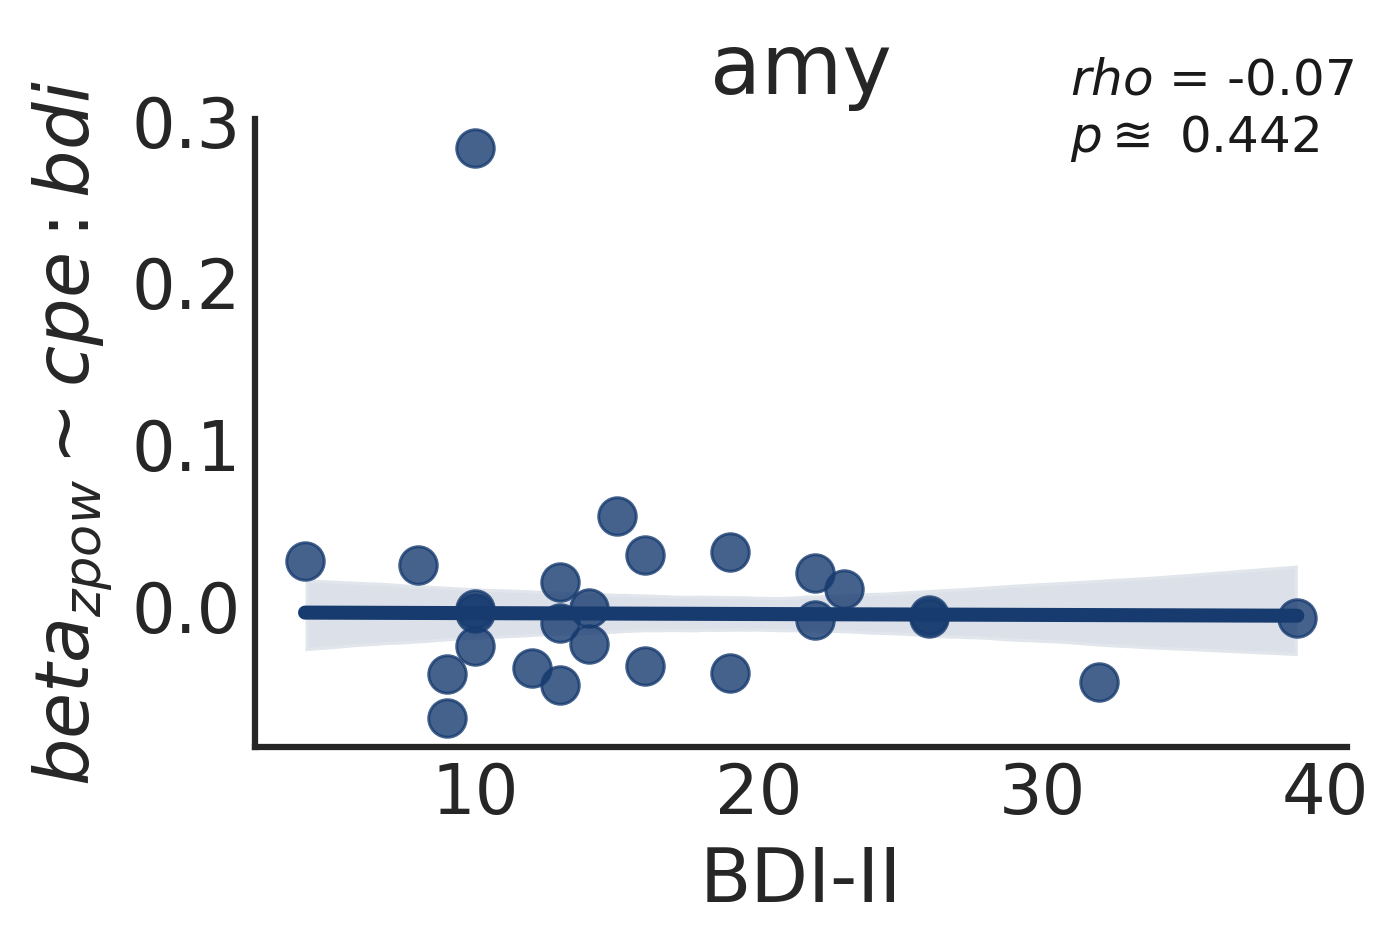

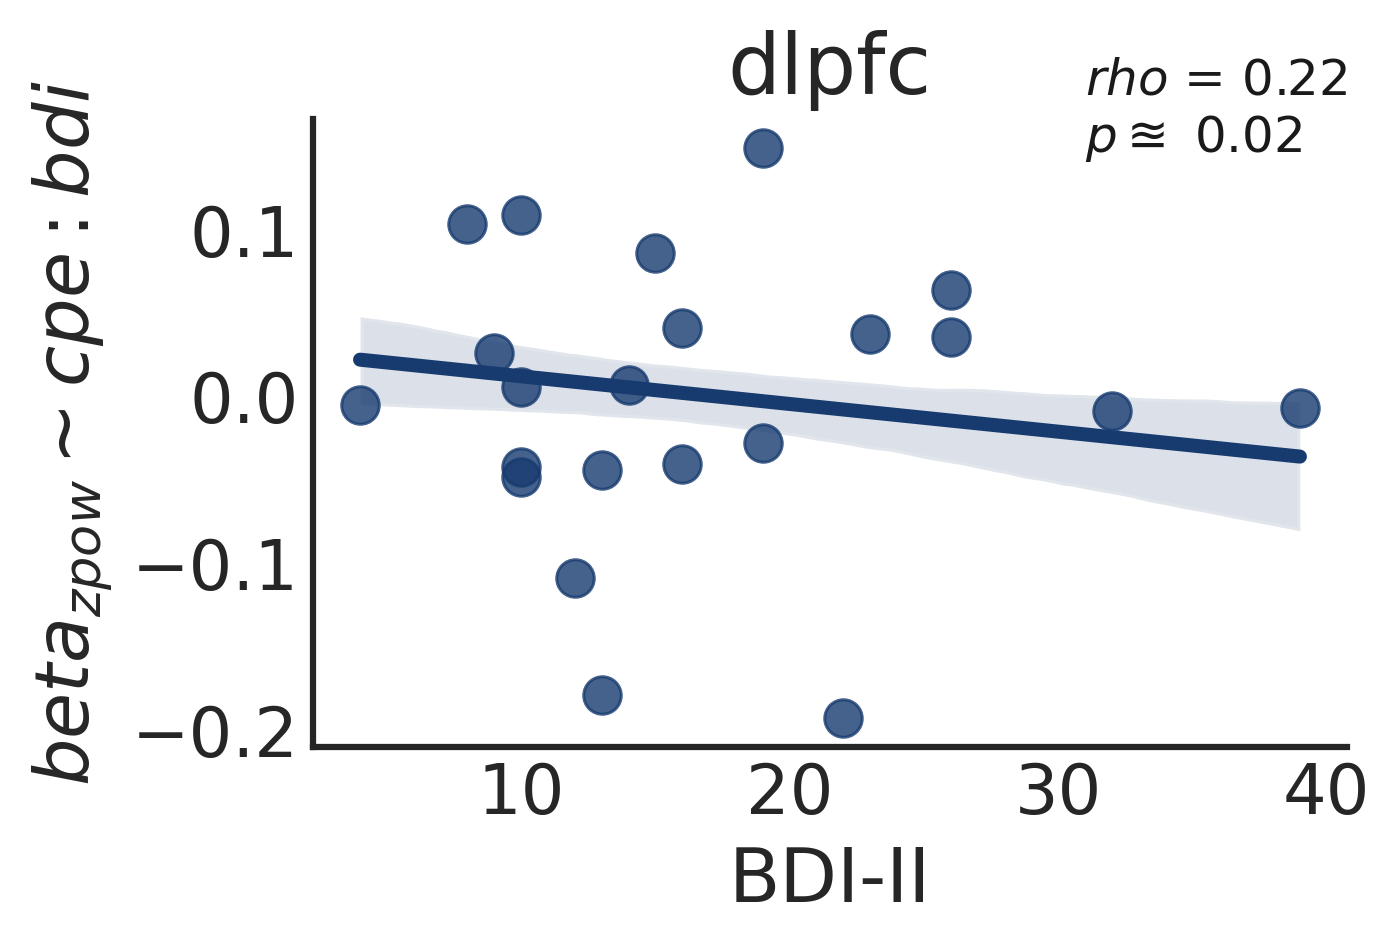

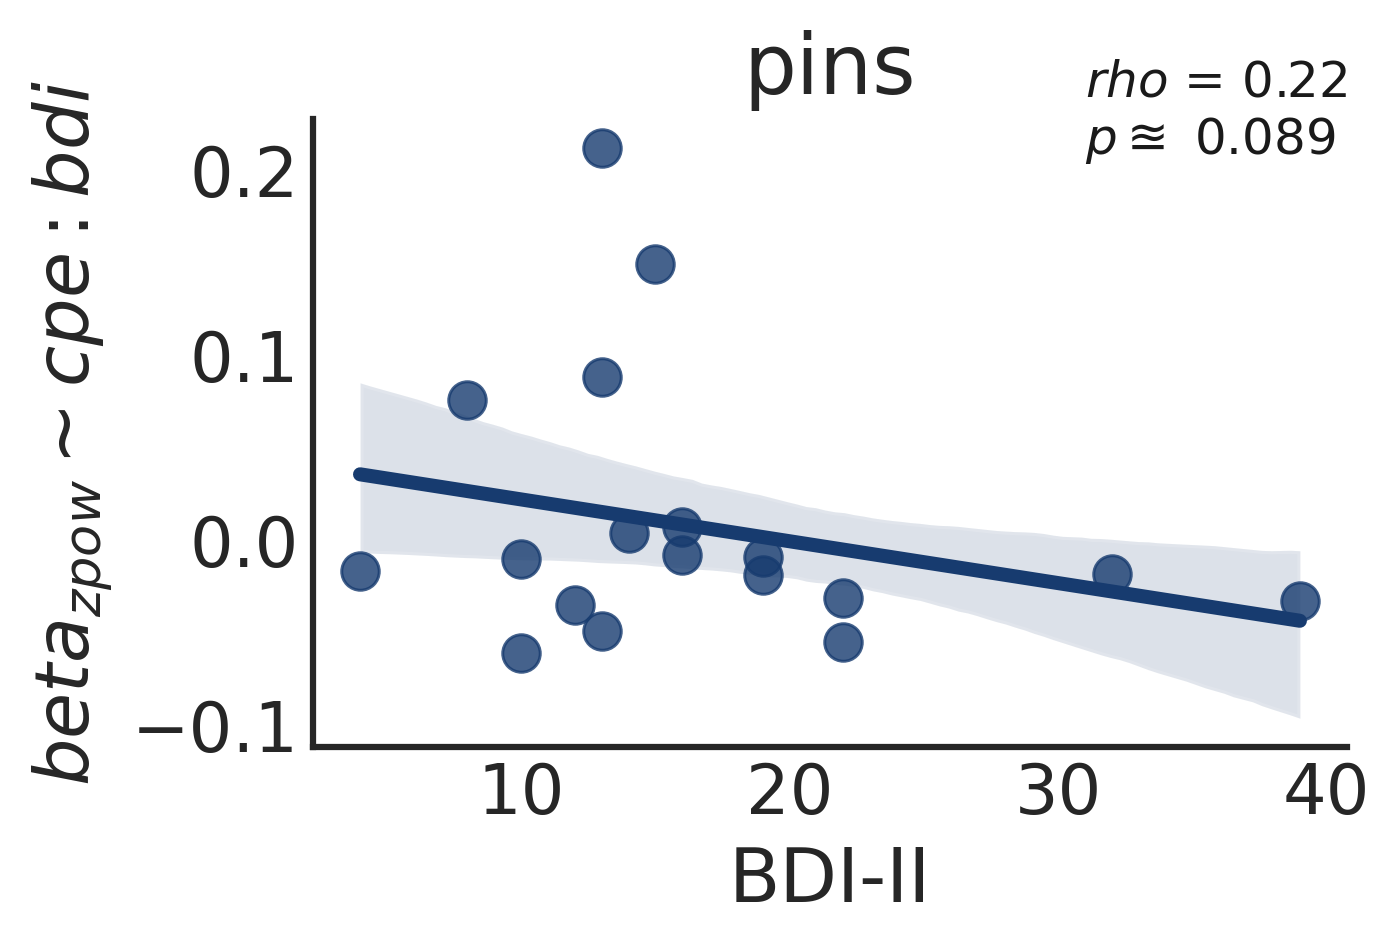

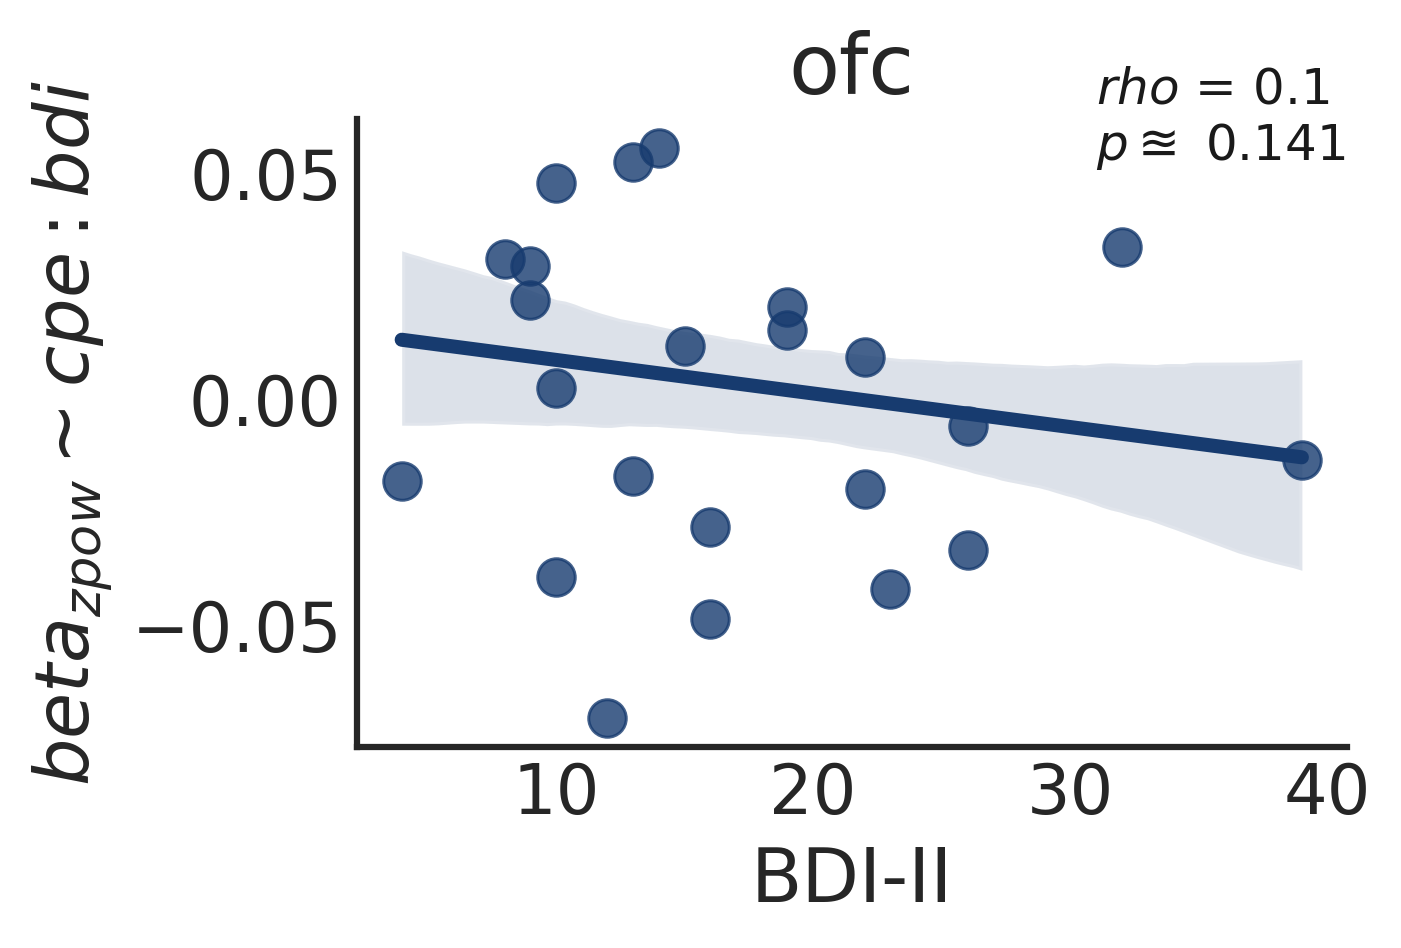

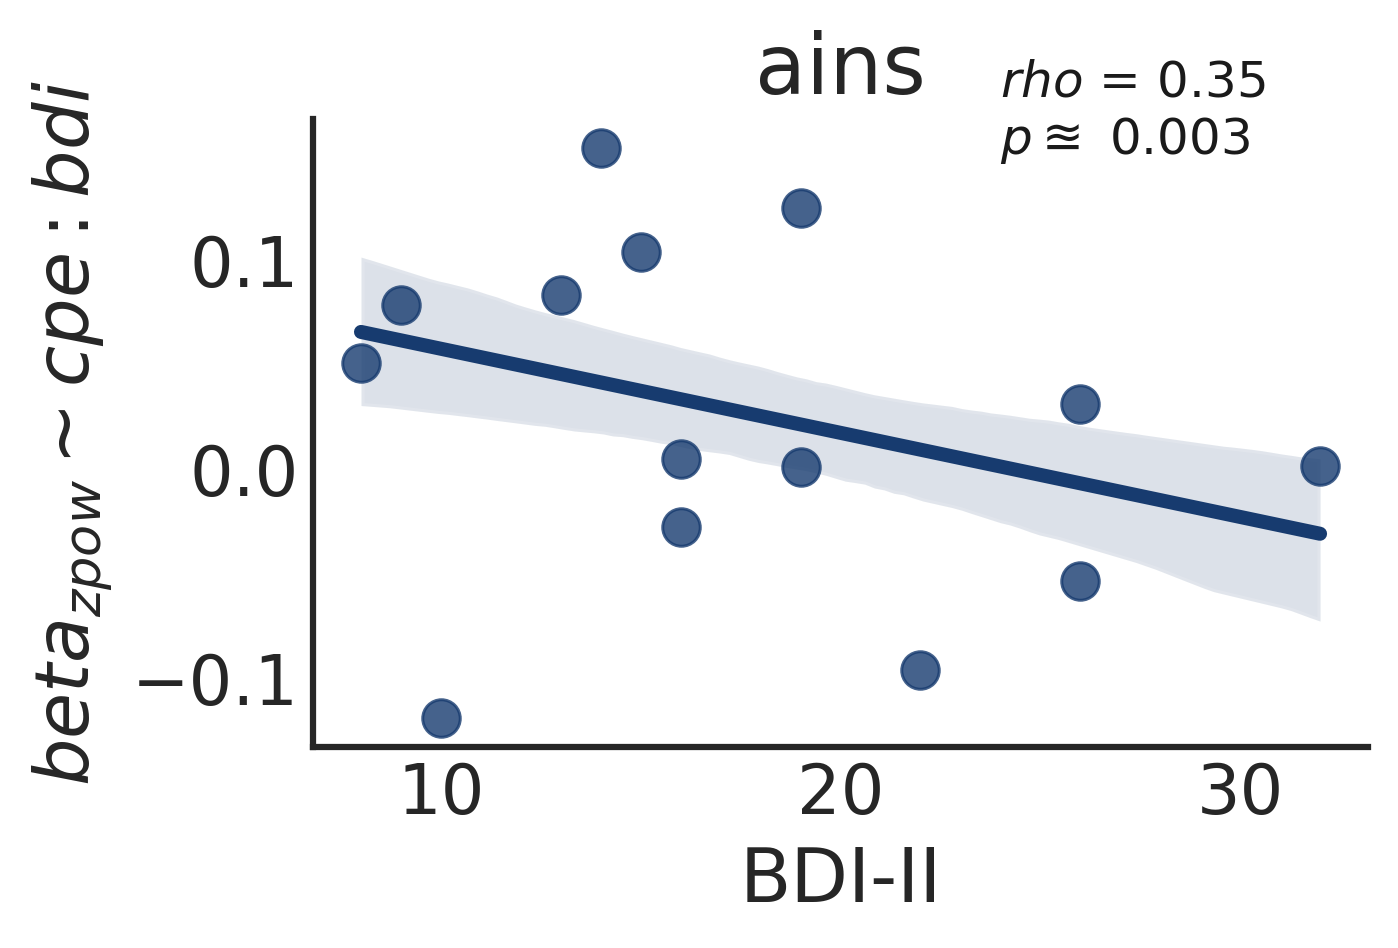

In [513]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in roi_plot_data.roi.unique().tolist()[:-1]:
    roi_temp_data = roi_plot_data[roi_plot_data.roi==roi]

    rho   = rho_data[rho_data.roi == roi].round_rho.values[0]
    rho_p = rho_data[rho_data.roi == roi].round_p.values[0]
    
        
    fig,ax = plt.subplots(1,1,figsize=(5,3.5),dpi=300)

    sns.regplot(data=roi_temp_data,x='bdi',y='raw_decisionCPE',scatter=False,ci=95,
                fit_reg=True,color = '#173b6f') #034975
    
    sns.scatterplot(data = roi_temp_data.groupby(['subj_id']).agg('mean'),x='bdi',
                    y='raw_decisionCPE',color = '#173b6f',edgecolor=None,alpha=0.8)
    
#     plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
    plt.xlabel('BDI-II')
#     plt.xlim([0,40])
    
    plt.tick_params(length=0) 
#     plt.ylabel('beta'+r'$beta_{{{zpow}}}$'+' cpe encoding')
    plt.ylabel(r'$beta_{{{zpow}}} \sim cpe:bdi$')

    plt.text(np.max(roi_temp_data.bdi)-8,
             np.round(np.max(roi_temp_data.groupby(['subj_id']).agg('mean').raw_decisionCPE),3)-0.003,
             r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',color='k',fontsize=12)
#              color='#00467e',fontsize=16)
#     plt.text(0.8,0.8,r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',
#             verticalalignment='top', horizontalalignment='right',
#             color='k',fontsize=16)

    plt.title(f'{roi}',fontsize=20)
    plt.tight_layout()
    


    
    sns.despine()
    
    plt.savefig(f'{fig_save_dir}/{roi}_{rho}_{rho_p}_roi_bdi_beta-cpe:bdi-slope.pdf', format='pdf', metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=300,
        facecolor='auto', edgecolor='auto',
        backend=None)
    

In [ ]:
beta_df

In [17]:
beta_reg_df

Unnamed: 0 subj_id  bdi reref_ch_names      unique_reref_ch  epoch  \
0                0   MS002   14  lacas1-lacas2  MS002_lacas1-lacas2      0   
1                1   MS002   14  lacas2-lacas3  MS002_lacas2-lacas3      0   
2                2   MS002   14  lacas3-lacas4  MS002_lacas3-lacas4      0   
3                3   MS002   14  lacas4-lacas5  MS002_lacas4-lacas5      0   
4                4   MS002   14  lacas5-lacas6  MS002_lacas5-lacas6      0   
...            ...     ...  ...            ...                  ...    ...   
258468      258468   DA039   22      rtp6-rtp7      DA039_rtp6-rtp7    148   
258469      258469   DA039   22      rtp7-rtp8      DA039_rtp7-rtp8    148   
258470      258470   DA039   22  rsgcc6-rsgcc7  DA039_rsgcc6-rsgcc7    148   
258471      258471   DA039   22  rsgcc7-rsgcc8  DA039_rsgcc7-rsgcc8    148   
258472      258472   DA039   22  rvmot6-rvmot7  DA039_rvmot6-rvmot7    148   

             freq  band  band_pow            roi  ...   SafeBet GambleChoice  \
0       20.743342  beta -0.123971            acc  ... -0.007878         safe   
1       20.743342  beta -0.186139            acc  ... -0.007878         safe   
2       20.743342  beta -0.235353            acc  ... -0.007878         safe   
3       20.743342  beta -0.086471            acc  ... -0.007878         safe   
4       20.743342  beta -0.145393            acc  ... -0.007878         safe   
...           ...   ...       ...            ...  ...       ...          ...   
258468  20.743342  beta -0.198057  temporal pole  ... -0.047267         safe   
258469  20.743342  beta -0.240000  temporal pole  ... -0.047267         safe   
258470  20.743342  beta -0.199545          vlpfc  ... -0.047267         safe   
258471  20.743342  beta -0.294459          vlpfc  ... -0.047267         safe   
258472  20.743342  beta  0.047316          motor  ... -0.047267         safe   

       GambleChoice_t1   TrialEV    Profit  TotalProfit       RPE  \
0               gamble -0.437011 -0.032900    -1.028523 -0.008746   
1               gamble -0.437011 -0.032900    -1.028523 -0.008746   
2               gamble -0.437011 -0.032900    -1.028523 -0.008746   
3               gamble -0.437011 -0.032900    -1.028523 -0.008746   
4               gamble -0.437011 -0.032900    -1.028523 -0.008746   
...                ...       ...       ...          ...       ...   
258468          gamble -0.359505 -0.042732     0.993053  0.022985   
258469          gamble -0.359505 -0.042732     0.993053  0.022985   
258470          gamble -0.359505 -0.042732     0.993053  0.022985   
258471          gamble -0.359505 -0.042732     0.993053  0.022985   
258472          gamble -0.359505 -0.042732     0.993053  0.022985   

        decisionCPE  decisionRegret decisionRelief  
0         -0.395746       -0.287638      -0.392122  
1         -0.395746       -0.287638      -0.392122  
2         -0.395746       -0.287638      -0.392122  
3         -0.395746       -0.287638      -0.392122  
4         -0.395746       -0.287638      -0.392122  
...             ...             ...            ...  
258468    -0.272392       -0.115665      -0.334244  
258469    -0.272392       -0.115665      -0.334244  
258470    -0.272392       -0.115665      -0.334244  
258471    -0.272392       -0.115665      -0.334244  
258472    -0.272392       -0.115665      -0.334244  

[244136 rows x 33 columns]

In [18]:
beta_reg_df['Depressed'] = ['High BDI' if bdi >=20 else 'Low BDI' for bdi in beta_reg_df.bdi.tolist()]

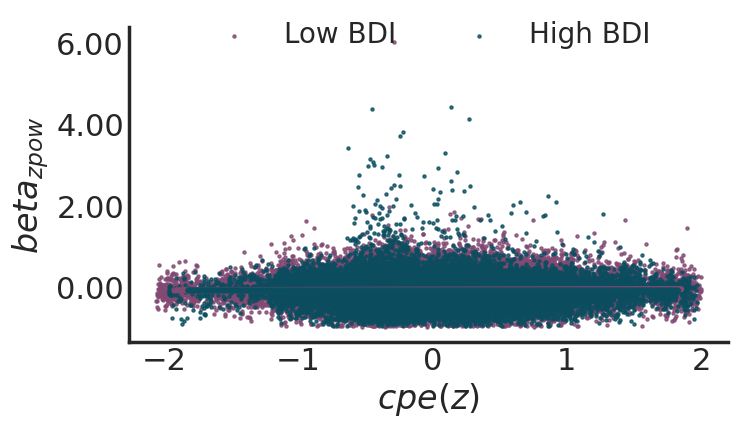

In [44]:
## X plot attempt 

sns.set_theme(style='ticks') 
sns.set_context("poster")

# from matplotlib import rc
# rc('text', usetex=False)


fig,ax = plt.subplots(figsize=(8,5))
# sns.set_context("poster",rc={'axes.linewidth': 2})
# sns.set_theme(style='ticks') 

# palette={'depression':"#3f2755",'no depression':"#054a6f"}

# palette={'high BDI':"#0b4e5f",'low BDI':"#824973"}


# ax = sns.lmplot(data=beta_reg_df,x='decisionCPE',y='band_pow',hue='Depression',scatter=False,ci=95,palette=palette)
# sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.1, 1),bbox_to_anchor=(-1, 0), ncol=2)

# sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1), borderaxespad=0.1,frameon=False,framealpha=0,
#                 fontsize='x-small',shadow=None,title=None,columnspacing=0.5,edgecolor=None,markerfirst=True,
#                 markerscale=4,labelcolor=None, ncol=2)


sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='Low BDI'],x='decisionCPE',y='band_pow',scatter=True,
           ci=95,color = '#824973',label='Low BDI',x_jitter = 0.15,scatter_kws={'s':5})
sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='High BDI'],x='decisionCPE',y='band_pow',scatter=True,
           ci=95,color='#0b4e5f',label='High BDI',x_jitter = 0.15,scatter_kws={'s':5})

plt.legend(fontsize=10)
# borderaxespad=0,frameon=False,framealpha=0,
sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1.1), frameon=False,framealpha=0,
                fontsize='small',shadow=None,
                columnspacing=2,ncol=2)


plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
plt.tight_layout()
plt.ylabel(r'$beta_{{{zpow}}}$')
plt.xlabel(r'$cpe(z)$')
sns.despine()
plt.tick_params(length=0)
# plt.text(7.25,0.07,f'rho: {np.round(r,3)} \n p: {np.round(p_r,6)}',fontsize=16)


# plt.savefig(f'{fig_save_dir}/all_lmplot_cpe_bpow_bdi_{date}.pdf', format='pdf', metadata=None,
# bbox_inches='tight', pad_inches=0.1,dpi=500,
# facecolor='auto', edgecolor='auto',
# backend=None)

In [27]:
beta_df['Depressed'] = ['High BDI' if bdi >=20 else 'Low BDI' for bdi in beta_df.bdi.tolist()]

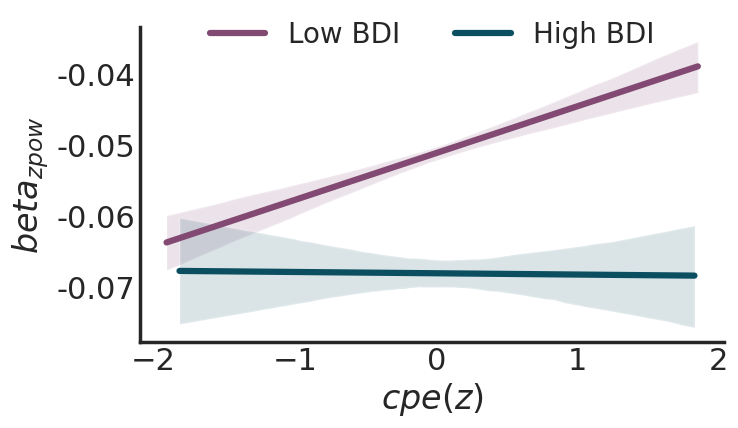

In [45]:
## X plot attempt 

sns.set_theme(style='ticks') 
sns.set_context("poster")

# from matplotlib import rc
# rc('text', usetex=False)


fig,ax = plt.subplots(figsize=(8,5))
# sns.set_context("poster",rc={'axes.linewidth': 2})
# sns.set_theme(style='ticks') 

# palette={'depression':"#3f2755",'no depression':"#054a6f"}

# palette={'high BDI':"#0b4e5f",'low BDI':"#824973"}


# ax = sns.lmplot(data=beta_reg_df,x='decisionCPE',y='band_pow',hue='Depression',scatter=False,ci=95,palette=palette)
# sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.1, 1),bbox_to_anchor=(-1, 0), ncol=2)

# sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1), borderaxespad=0.1,frameon=False,framealpha=0,
#                 fontsize='x-small',shadow=None,title=None,columnspacing=0.5,edgecolor=None,markerfirst=True,
#                 markerscale=4,labelcolor=None, ncol=2)


sns.regplot(data=beta_df[beta_df.Depressed=='Low BDI'],x='decisionCPE',y='band_pow',scatter=False,
           ci=95,color = '#824973',label='Low BDI')
sns.regplot(data=beta_df[beta_df.Depressed=='High BDI'],x='decisionCPE',y='band_pow',scatter=False,
           ci=95,color='#0b4e5f',label='High BDI')

plt.legend(fontsize=10)
# borderaxespad=0,frameon=False,framealpha=0,
sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1.1), frameon=False,framealpha=0,
                fontsize='small',shadow=None,
                columnspacing=2,ncol=2)


plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
plt.tight_layout()
plt.ylabel(r'$beta_{{{zpow}}}$')
plt.xlabel(r'$cpe(z)$')
sns.despine()
plt.tick_params(length=0)
# plt.text(7.25,0.07,f'rho: {np.round(r,3)} \n p: {np.round(p_r,6)}',fontsize=16)


# plt.savefig(f'{fig_save_dir}/all_lmplot_cpe_bpow_bdi_{date}.pdf', format='pdf', metadata=None,
# bbox_inches='tight', pad_inches=0.1,dpi=500,
# facecolor='auto', edgecolor='auto',
# backend=None)

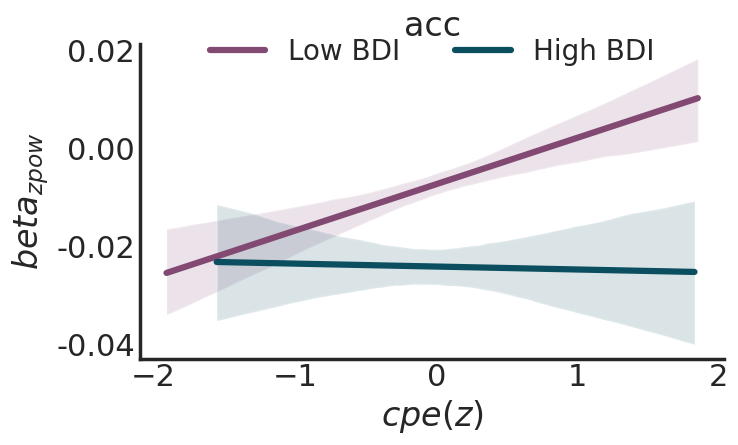

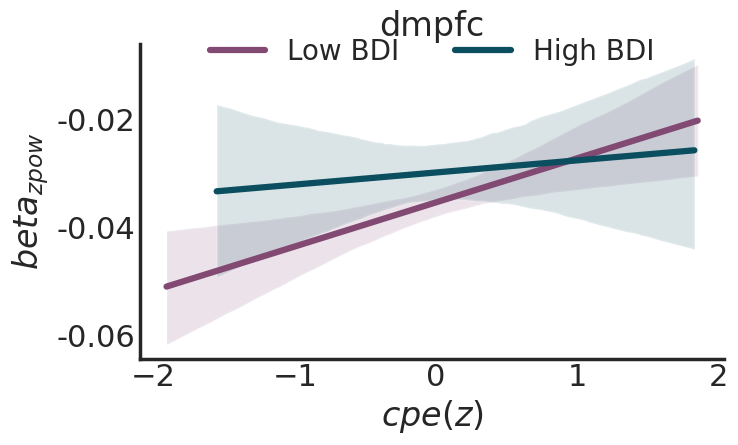

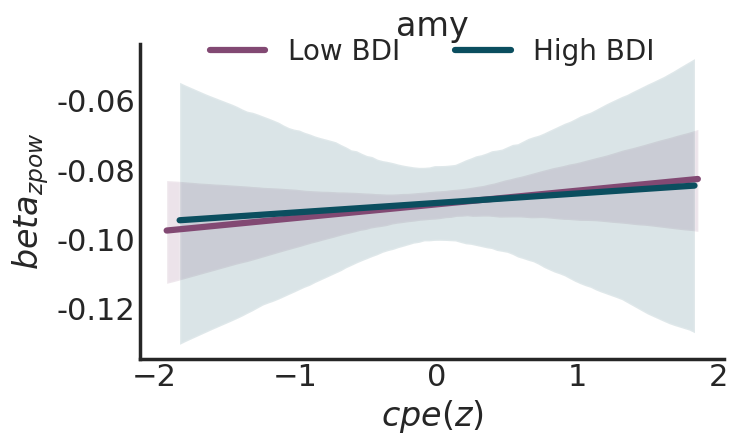

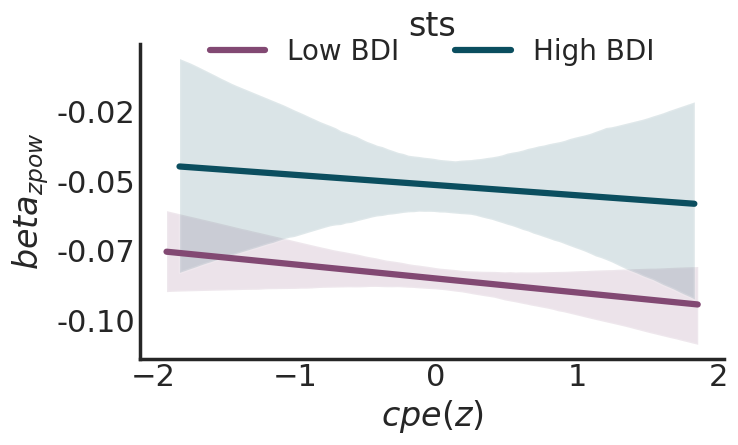

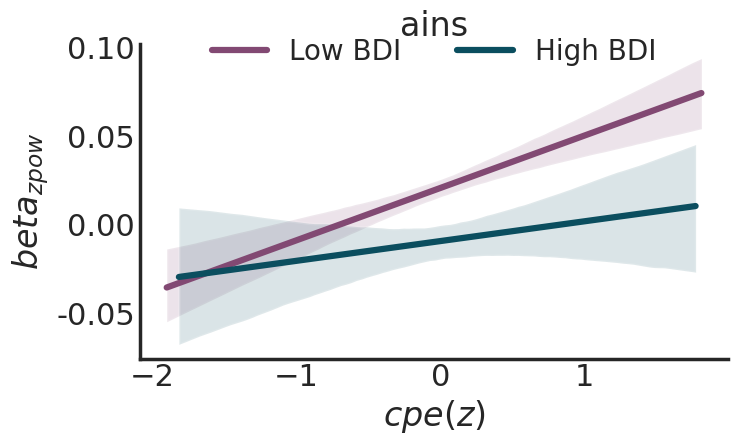

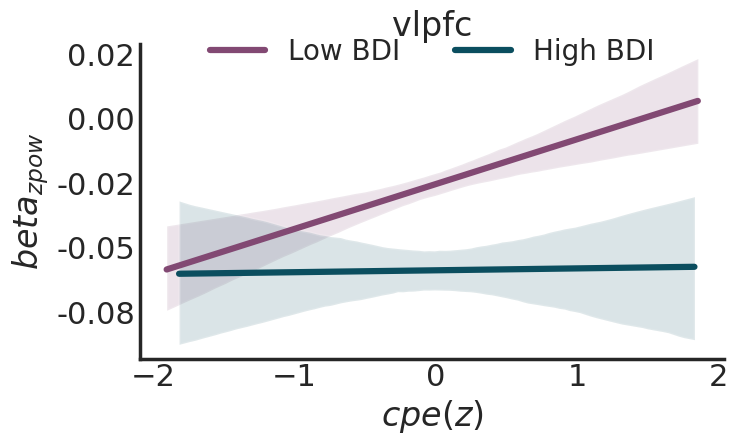

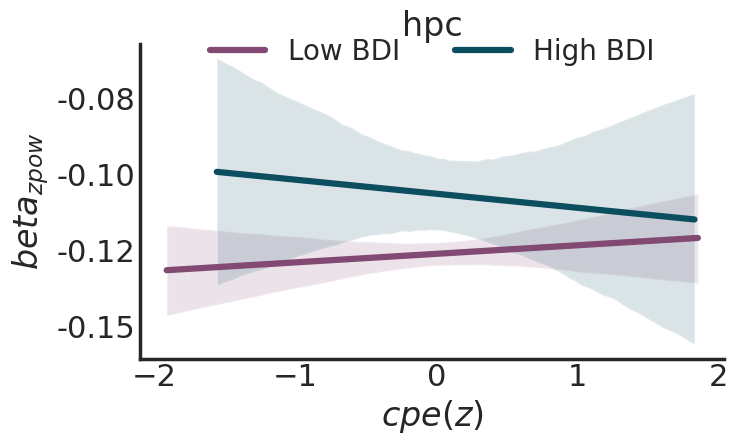

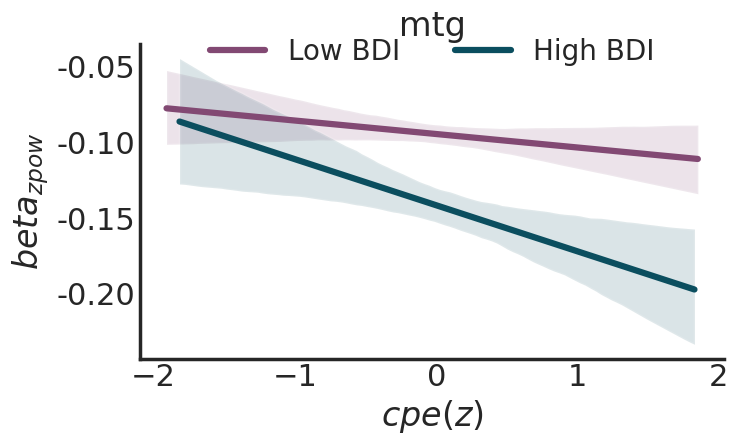

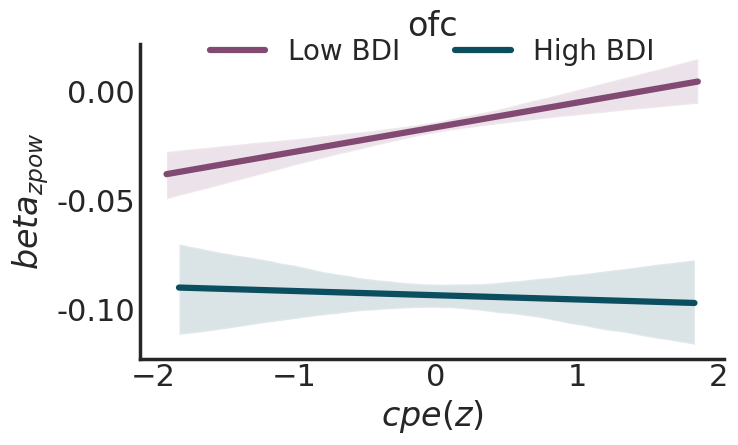

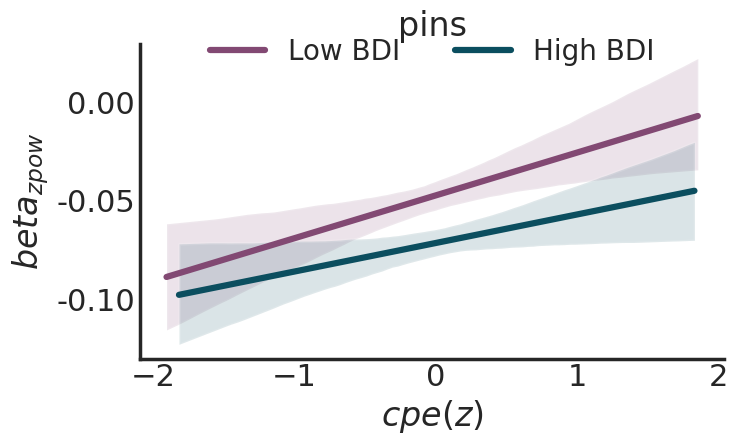

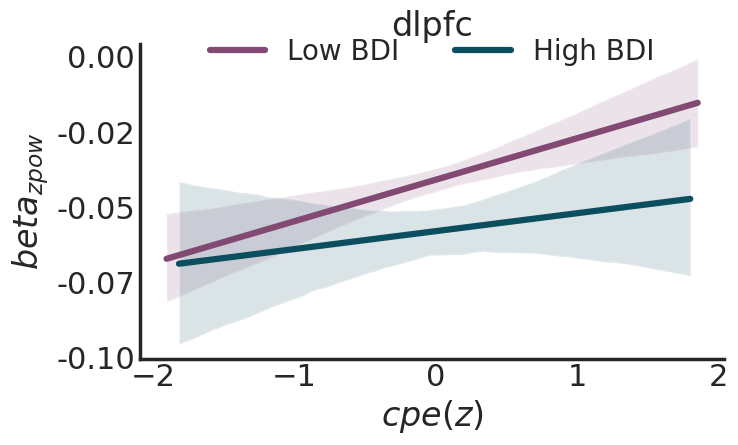

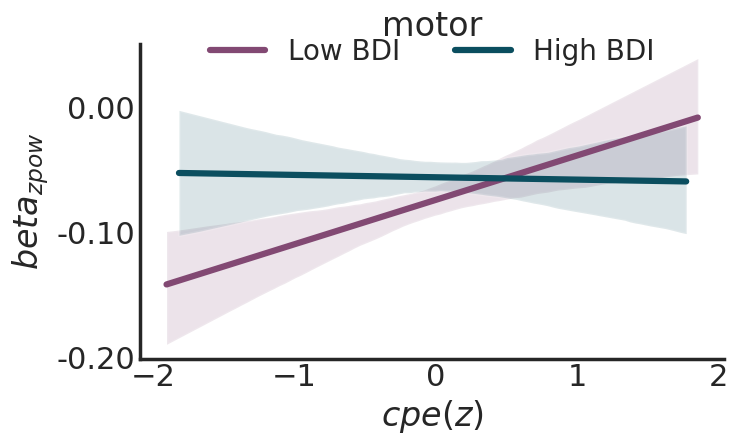

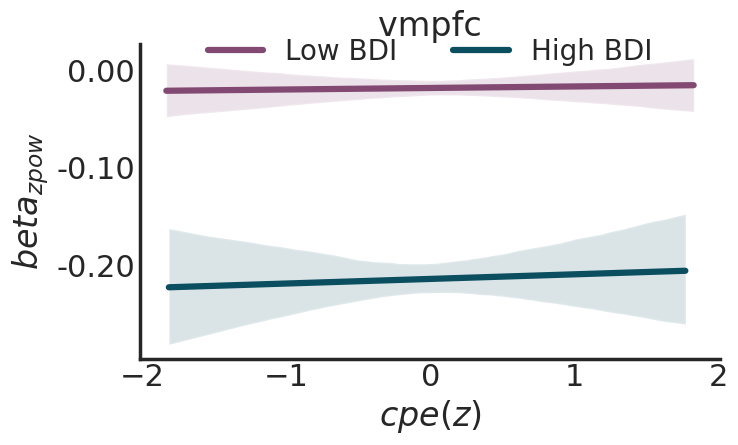

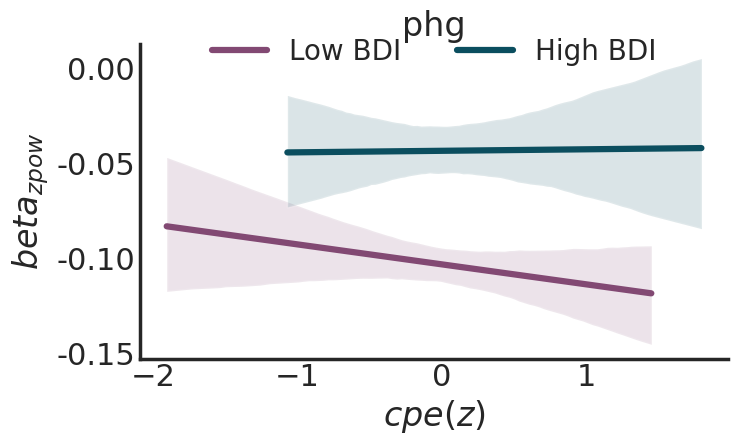

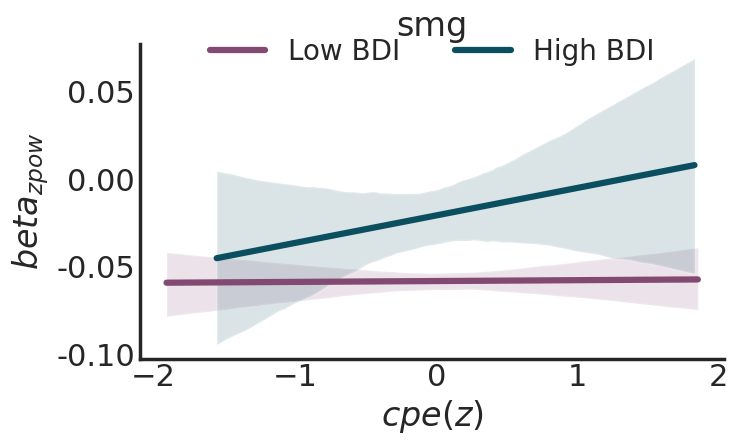

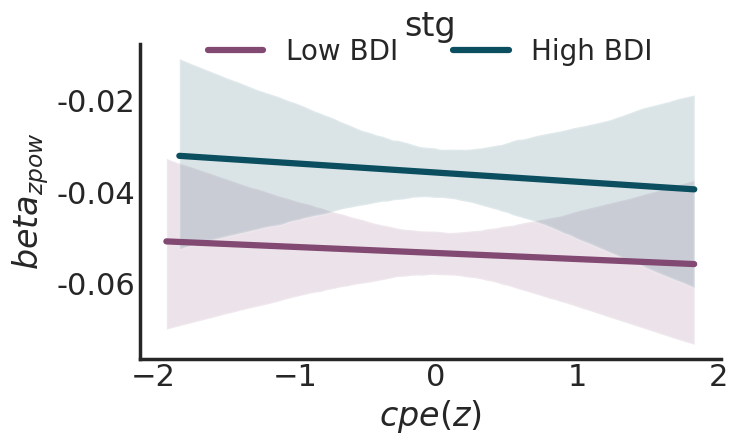

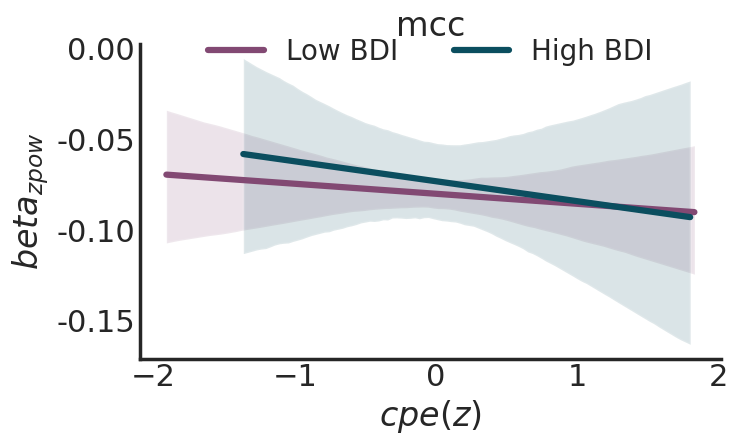

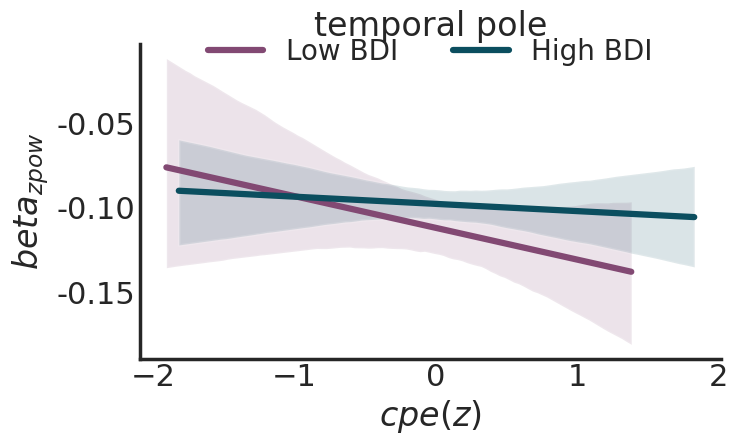

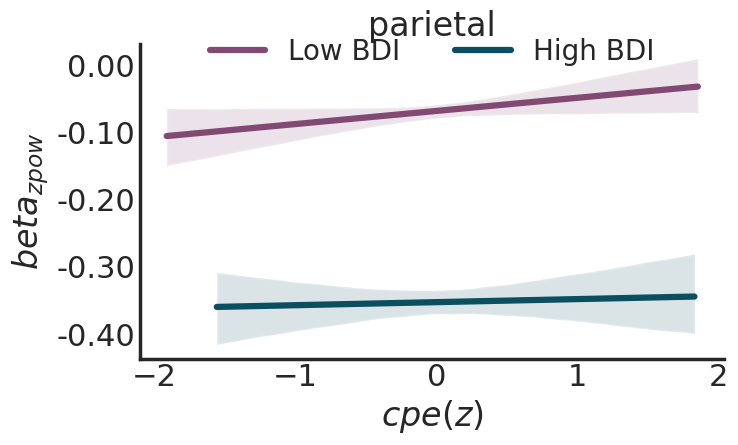

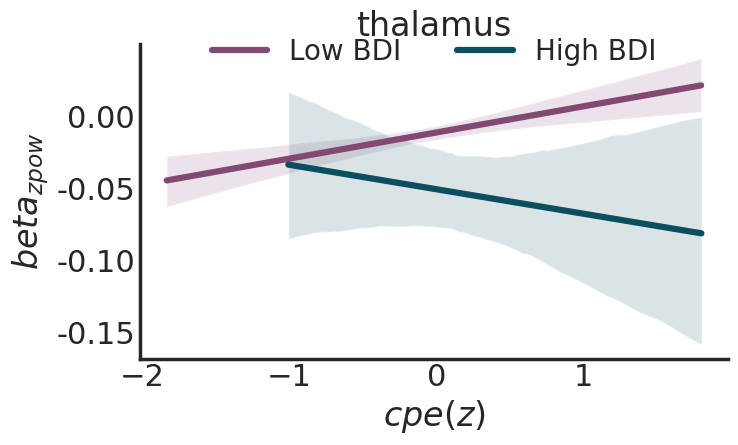

In [42]:
for roi in beta_reg_df.roi.unique().tolist():
    roi_reg_plot = beta_reg_df[beta_reg_df.roi== roi]
    fig,ax = plt.subplots(figsize=(8,5))

    sns.regplot(data=roi_reg_plot[roi_reg_plot.Depressed=='Low BDI'],x='decisionCPE',y='band_pow',scatter=False,
               ci=95,color = '#824973',label='Low BDI')#,scatter_kws={'s':2})
    sns.regplot(data=roi_reg_plot[roi_reg_plot.Depressed=='High BDI'],x='decisionCPE',y='band_pow',scatter=False,
               ci=95,color='#0b4e5f',label='High BDI')#,scatter_kws={'s':2})

    plt.legend(fontsize=10)
    # borderaxespad=0,frameon=False,framealpha=0,
    sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1.1), frameon=False,framealpha=0,
                    fontsize='small',shadow=None,
                    columnspacing=2,ncol=2)


    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
    plt.tight_layout()
    plt.ylabel(r'$beta_{{{zpow}}}$')
    plt.xlabel(r'$cpe(z)$')
    plt.title(f'{roi}')
    sns.despine()
    plt.tick_params(length=0)
    
    

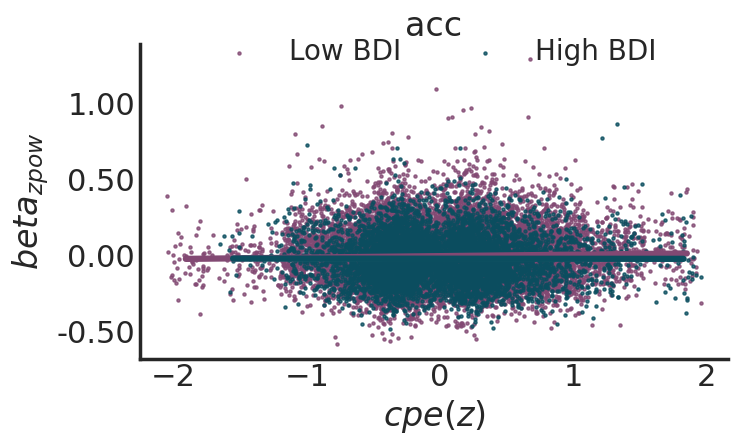

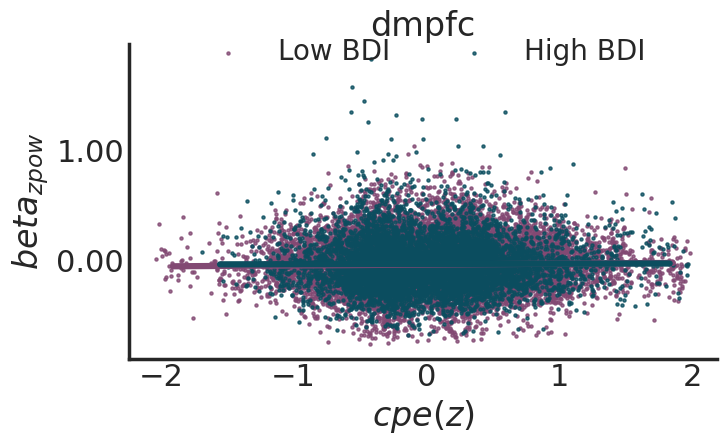

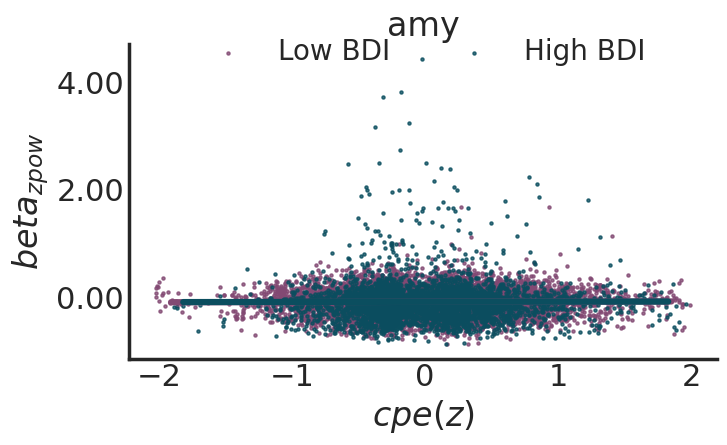

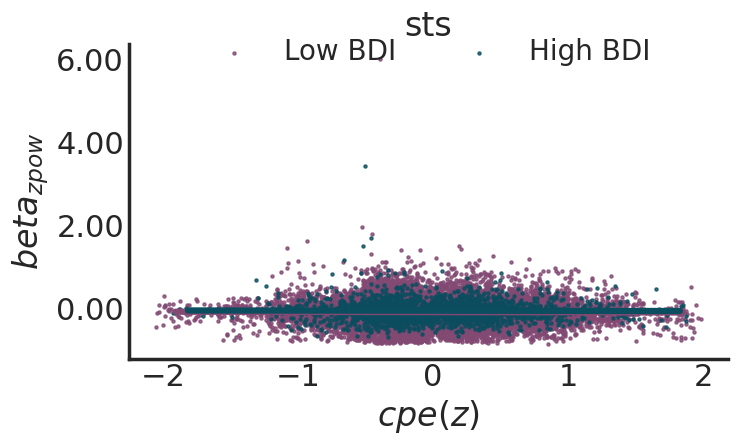

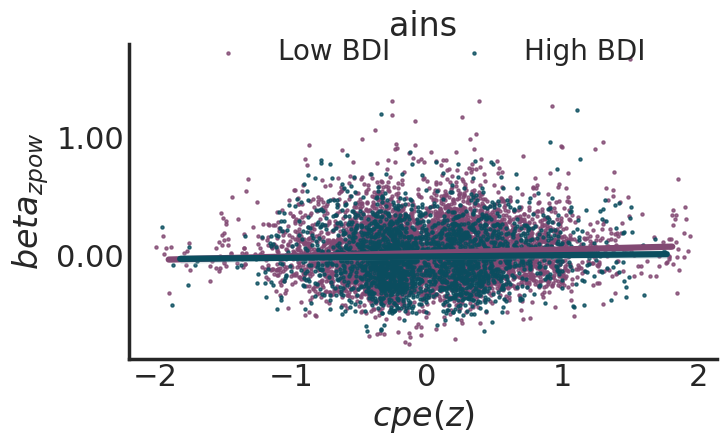

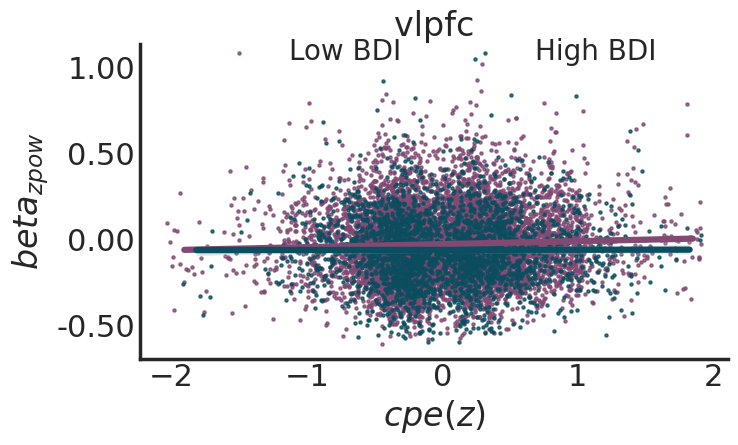

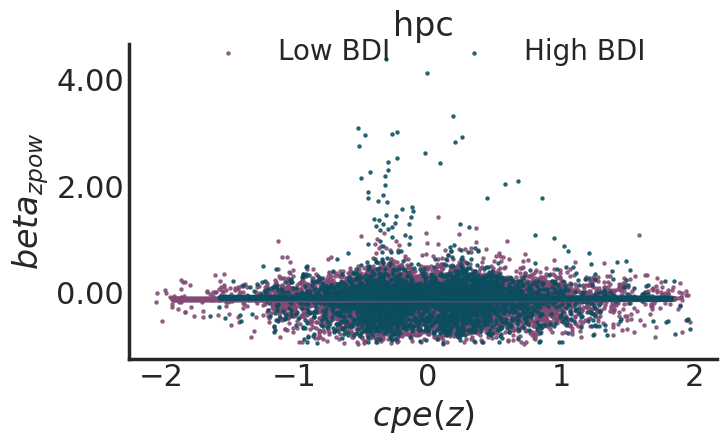

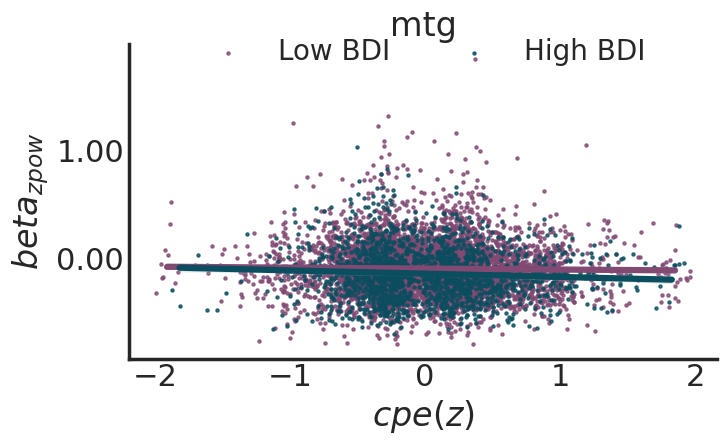

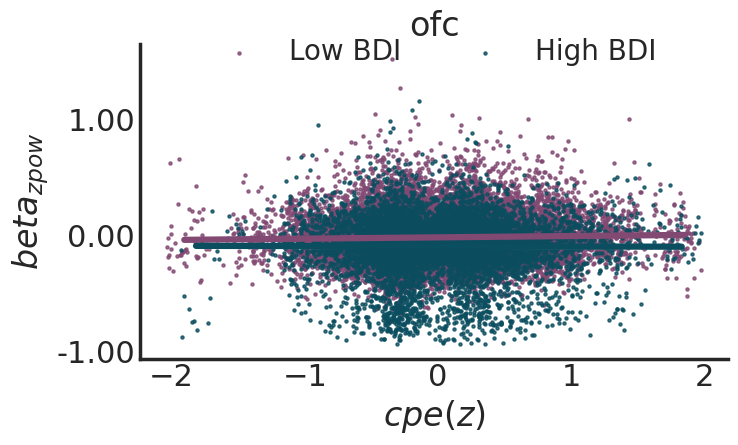

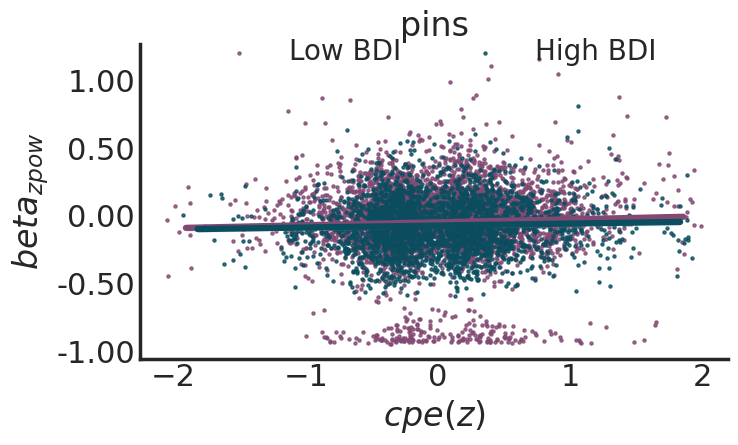

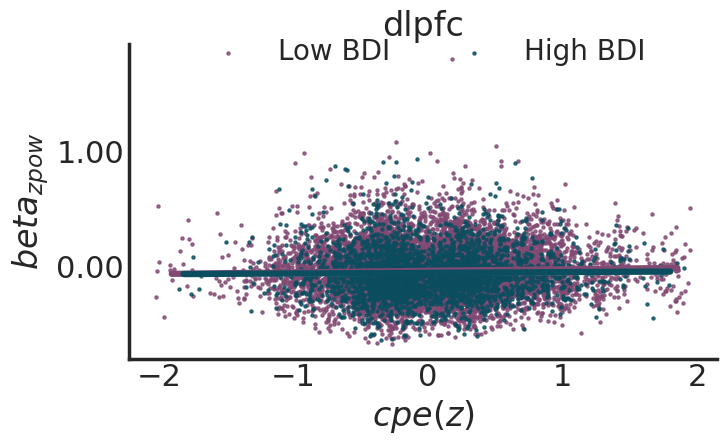

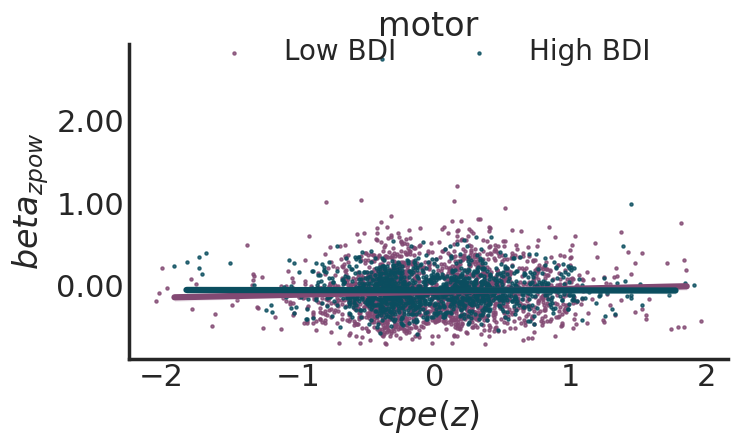

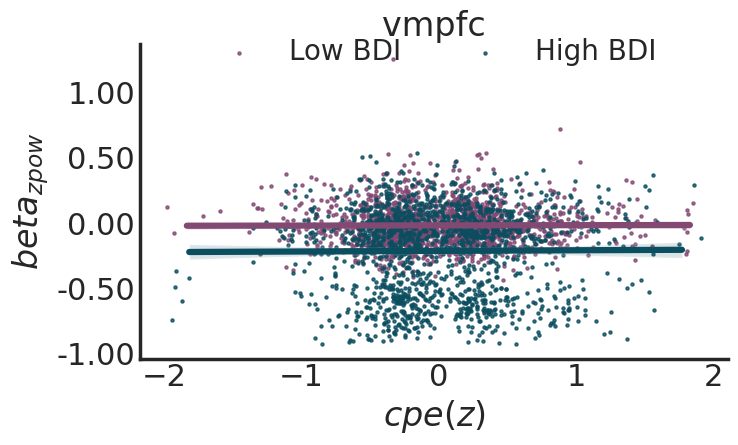

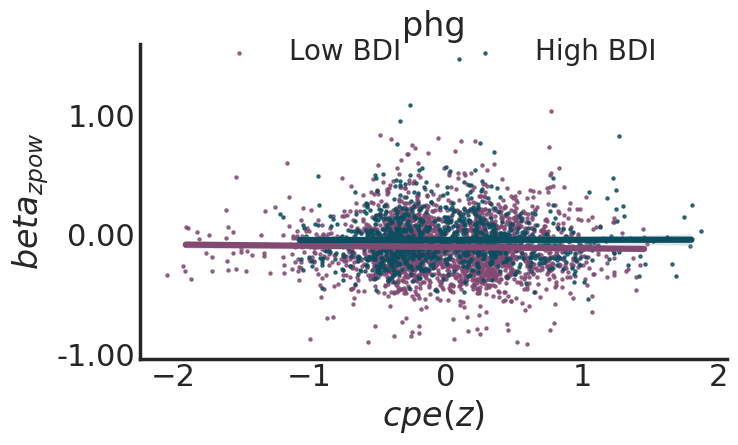

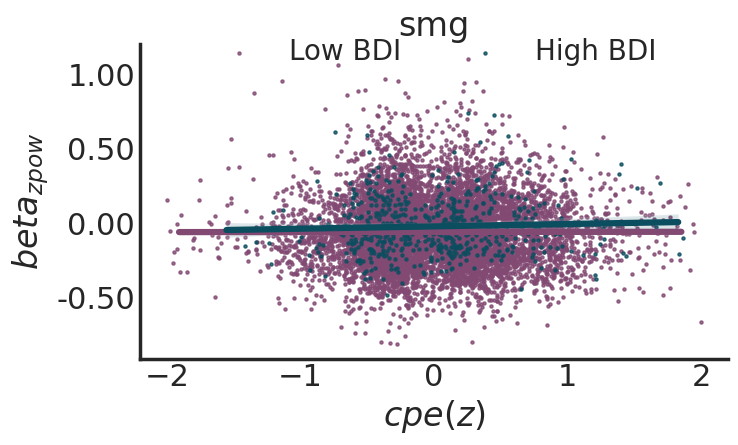

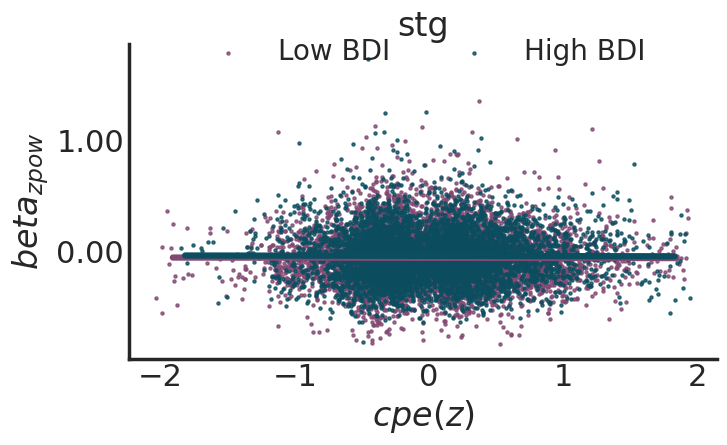

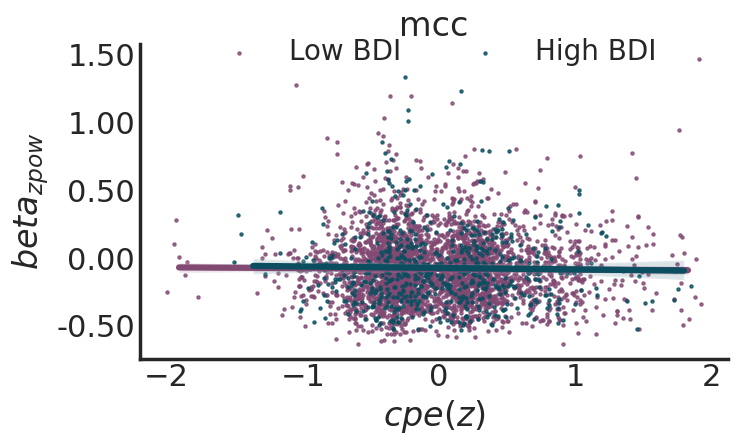

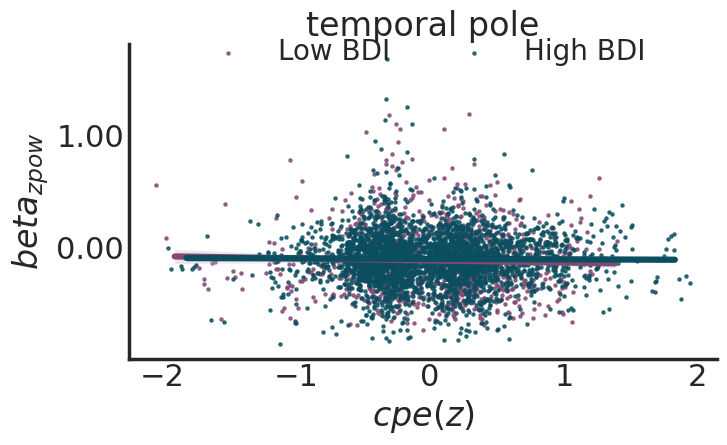

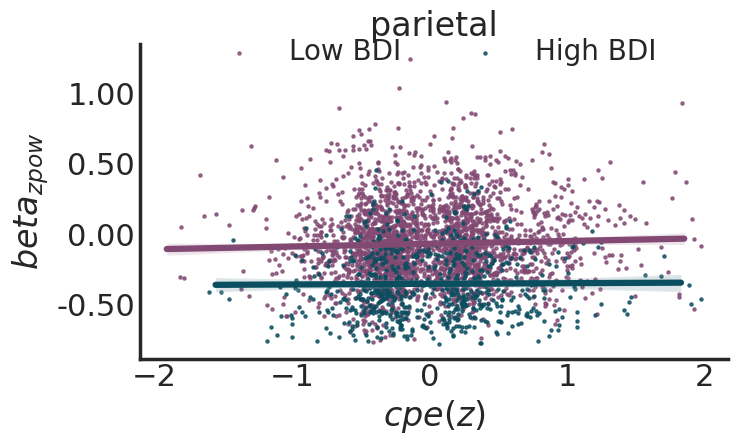

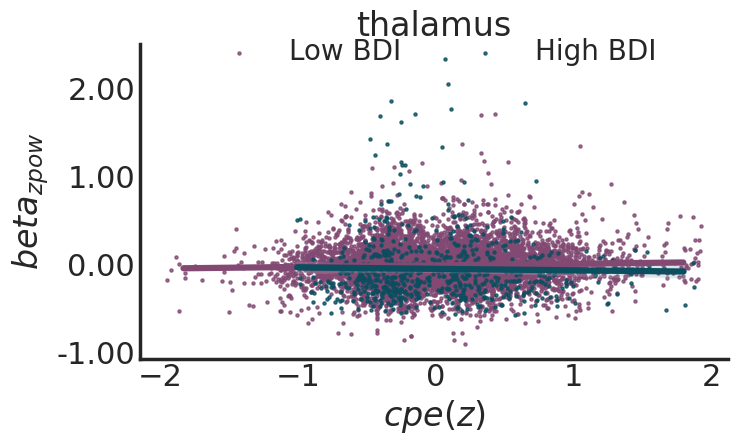

In [41]:
for roi in beta_reg_df.roi.unique().tolist():
    roi_reg_plot = beta_reg_df[beta_reg_df.roi== roi]
    fig,ax = plt.subplots(figsize=(8,5))

    sns.regplot(data=roi_reg_plot[roi_reg_plot.Depressed=='Low BDI'],x='decisionCPE',y='band_pow',scatter=True,
               ci=95,color = '#824973',label='Low BDI',x_jitter = 0.15,scatter_kws={'s':5})
    sns.regplot(data=roi_reg_plot[roi_reg_plot.Depressed=='High BDI'],x='decisionCPE',y='band_pow',scatter=True,
               ci=95,color='#0b4e5f',label='High BDI',x_jitter = 0.15,scatter_kws={'s':5})

    plt.legend(fontsize=10)
    # borderaxespad=0,frameon=False,framealpha=0,
    sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1.1), frameon=False,framealpha=0,
                    fontsize='small',shadow=None,
                    columnspacing=2,ncol=2)


    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
    plt.tight_layout()
    plt.ylabel(r'$beta_{{{zpow}}}$')
    plt.xlabel(r'$cpe(z)$')
    plt.title(f'{roi}')
    sns.despine()
    plt.tick_params(length=0)
    
    

In [36]:
# for roi in beta_reg_df.roi.unique().tolist():
#     roi_reg_plot = beta_reg_df[beta_reg_df.roi== roi]
#     fig,ax = plt.subplots(figsize=(8,5),dpi=500)

#     sns.regplot(data=roi_reg_plot[roi_reg_plot.Depressed=='Low BDI'],x='decisionCPE',y='band_pow',scatter=True,
#                ci=95,color = '#824973',label='Low BDI',x_jitter = 0.15)#,scatter_kws={'s':2})
#     sns.regplot(data=roi_reg_plot[roi_reg_plot.Depressed=='High BDI'],x='decisionCPE',y='band_pow',scatter=True,
#                ci=95,color='#0b4e5f',label='High BDI',x_jitter = 0.15)#,scatter_kws={'s':2})

#     plt.legend(fontsize=10)
#     # borderaxespad=0,frameon=False,framealpha=0,
#     sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1.1), frameon=False,framealpha=0,
#                     fontsize='small',shadow=None,
#                     columnspacing=2,ncol=2)


#     plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 

#     plt.ylabel(r'$beta_{{{zpow}}}$')
#     plt.xlabel(r'$cpe(z)$')
#     plt.title(f'{roi}')
#     sns.despine()
#     plt.tick_params(length=0)
    
    

In [ ]:
fig,ax = plt.subplots(figsize=(8,5),dpi=500)
# sns.set_context("poster",rc={'axes.linewidth': 2})
# sns.set_theme(style='ticks') 

# palette={'depression':"#3f2755",'no depression':"#054a6f"}

# palette={'high BDI':"#0b4e5f",'low BDI':"#824973"}


# ax = sns.lmplot(data=beta_reg_df,x='decisionCPE',y='band_pow',hue='Depression',scatter=False,ci=95,palette=palette)
# sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.1, 1),bbox_to_anchor=(-1, 0), ncol=2)

# sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1), borderaxespad=0.1,frameon=False,framealpha=0,
#                 fontsize='x-small',shadow=None,title=None,columnspacing=0.5,edgecolor=None,markerfirst=True,
#                 markerscale=4,labelcolor=None, ncol=2)


sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='Low BDI'],x='decisionCPE',y='band_pow',scatter=True,
           ci=95,color = '#824973',label='Low BDI',x_jitter = 0.15,scatter_kws={'s':2})
sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='High BDI'],x='decisionCPE',y='band_pow',scatter=True,
           ci=95,color='#0b4e5f',label='High BDI',x_jitter = 0.15,scatter_kws={'s':2})

plt.legend(fontsize=10)
# borderaxespad=0,frameon=False,framealpha=0,
sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1.1), frameon=False,framealpha=0,
                fontsize='small',shadow=None,
                columnspacing=2,ncol=2)


plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 

plt.ylabel(r'$beta_{{{zpow}}}$')
plt.xlabel(r'$cpe(z)$')
sns.despine()
plt.tick_params(length=0)
# plt.text(7.25,0.07,f'rho: {np.round(r,3)} \n p: {np.round(p_r,6)}',fontsize=16)



In [514]:
beta_reg_df.groupby('roi')

In [528]:
# beta_reg_df['BDI-II'] = ['Low' if bdi<20 else 'High' for bdi in beta_reg_df.bdi]
beta_reg_df

Unnamed: 0 subj_id  bdi reref_ch_names      unique_reref_ch  epoch  \
0                0   MS002   14  lacas1-lacas2  MS002_lacas1-lacas2      0   
1                1   MS002   14  lacas2-lacas3  MS002_lacas2-lacas3      0   
2                2   MS002   14  lacas3-lacas4  MS002_lacas3-lacas4      0   
3                3   MS002   14  lacas4-lacas5  MS002_lacas4-lacas5      0   
4                4   MS002   14  lacas5-lacas6  MS002_lacas5-lacas6      0   
...            ...     ...  ...            ...                  ...    ...   
258468      258468   DA039   22      rtp6-rtp7      DA039_rtp6-rtp7    148   
258469      258469   DA039   22      rtp7-rtp8      DA039_rtp7-rtp8    148   
258470      258470   DA039   22  rsgcc6-rsgcc7  DA039_rsgcc6-rsgcc7    148   
258471      258471   DA039   22  rsgcc7-rsgcc8  DA039_rsgcc7-rsgcc8    148   
258472      258472   DA039   22  rvmot6-rvmot7  DA039_rvmot6-rvmot7    148   

             freq  band  band_pow            roi  ... GambleChoice_t1  \
0       20.743342  beta -0.123971            acc  ...          gamble   
1       20.743342  beta -0.186139            acc  ...          gamble   
2       20.743342  beta -0.235353            acc  ...          gamble   
3       20.743342  beta -0.086471            acc  ...          gamble   
4       20.743342  beta -0.145393            acc  ...          gamble   
...           ...   ...       ...            ...  ...             ...   
258468  20.743342  beta -0.198057  temporal pole  ...          gamble   
258469  20.743342  beta -0.240000  temporal pole  ...          gamble   
258470  20.743342  beta -0.199545          vlpfc  ...          gamble   
258471  20.743342  beta -0.294459          vlpfc  ...          gamble   
258472  20.743342  beta  0.047316          motor  ...          gamble   

         TrialEV    Profit TotalProfit       RPE  decisionCPE  decisionRegret  \
0      -0.437011 -0.032900   -1.028523 -0.008746    -0.395746       -0.287638   
1      -0.437011 -0.032900   -1.028523 -0.008746    -0.395746       -0.287638   
2      -0.437011 -0.032900   -1.028523 -0.008746    -0.395746       -0.287638   
3      -0.437011 -0.032900   -1.028523 -0.008746    -0.395746       -0.287638   
4      -0.437011 -0.032900   -1.028523 -0.008746    -0.395746       -0.287638   
...          ...       ...         ...       ...          ...             ...   
258468 -0.359505 -0.042732    0.993053  0.022985    -0.272392       -0.115665   
258469 -0.359505 -0.042732    0.993053  0.022985    -0.272392       -0.115665   
258470 -0.359505 -0.042732    0.993053  0.022985    -0.272392       -0.115665   
258471 -0.359505 -0.042732    0.993053  0.022985    -0.272392       -0.115665   
258472 -0.359505 -0.042732    0.993053  0.022985    -0.272392       -0.115665   

        decisionRelief  BDI-II Depression  
0            -0.392122     Low    Low BDI  
1            -0.392122     Low    Low BDI  
2            -0.392122     Low    Low BDI  
3            -0.392122     Low    Low BDI  
4            -0.392122     Low    Low BDI  
...                ...     ...        ...  
258468       -0.334244    High   High BDI  
258469       -0.334244    High   High BDI  
258470       -0.334244    High   High BDI  
258471       -0.334244    High   High BDI  
258472       -0.334244    High   High BDI  

[244136 rows x 35 columns]

In [521]:
palette=dict(Low="#3f2755", High="#054a6f")
# sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)


In [518]:
from scipy import stats
# slope, intercept, r_value, p_value, std_err = stats.linregress(df.x,df.y)

In [526]:
# beta_reg_df['Depression'] = ['depressed' if bdi >=20 else 'not depressed' for bdi in beta_reg_df.bdi.tolist()]
beta_reg_df['Depression'] = ['High BDI' if bdi >=20 else 'Low BDI' for bdi in beta_reg_df.bdi.tolist()]

In [ ]:
# edgecolor=None,markerfirst=True,title=None,#title_fontsize='x-small',
#                 markerscale=0.2,labelcolor=None

In [ ]:
beta_reg_df

In [531]:
roi_order = ['dlpfc','vlpfc','ofc','ains','pins','acc','hpc','amy']

In [533]:
beta_lmplot

unique_reref_ch  Unnamed: 0   bdi      epoch       freq  band_pow  \
0         DA023_lac1-lac2    237545.5  14.0  73.205479  20.743342 -0.011737   
1       DA023_lac10-lac11    237552.5  14.0  73.205479  20.743342 -0.007978   
2         DA023_lac2-lac3    237546.5  14.0  73.205479  20.743342  0.001494   
3         DA023_lac3-lac4    237547.5  14.0  73.205479  20.743342 -0.000103   
4         DA023_lac4-lac5    237548.5  14.0  73.205479  20.743342  0.002259   
...                   ...         ...   ...        ...        ...       ...   
1771  MS050_rmoif4-rmoif5    223469.0   9.0  74.410959  20.743342 -0.003468   
1772  MS050_rmoif5-rmoif6    223470.0   9.0  74.410959  20.743342  0.012266   
1773  MS050_rmoif6-rmoif7    223471.0   9.0  74.410959  20.743342  0.019372   
1774  MS050_rmoif7-rmoif8    223472.0   9.0  74.410959  20.743342  0.009815   
1775  MS050_rmoif8-rmoif9    223473.0   9.0  74.410959  20.743342  0.019687   

      logRT_t1     logRT        RT      Round  ...   GambleEV_t1  \
0     0.898497  0.896727  2.732679  74.205479  ...  1.368768e-17   
1     0.898497  0.896727  2.732679  74.205479  ...  1.368768e-17   
2     0.898497  0.896727  2.732679  74.205479  ...  1.368768e-17   
3     0.898497  0.896727  2.732679  74.205479  ...  1.368768e-17   
4     0.898497  0.896727  2.732679  74.205479  ...  1.368768e-17   
...        ...       ...       ...        ...  ...           ...   
1771  1.277649  1.283255  3.877545  75.410959  ...  1.444811e-17   
1772  1.277649  1.283255  3.877545  75.410959  ...  1.444811e-17   
1773  1.277649  1.283255  3.877545  75.410959  ...  1.444811e-17   
1774  1.277649  1.283255  3.877545  75.410959  ...  1.444811e-17   
1775  1.277649  1.283255  3.877545  75.410959  ...  1.444811e-17   

           SafeBet       TrialEV        Profit   TotalProfit           RPE  \
0     8.364694e-18  1.064597e-17  1.763239e-17 -1.323143e-16  4.638603e-17   
1     8.364694e-18  1.064597e-17  1.763239e-17 -1.323143e-16  4.638603e-17   
2     8.364694e-18  1.064597e-17  1.763239e-17 -1.323143e-16  4.638603e-17   
3     8.364694e-18  1.064597e-17  1.763239e-17 -1.323143e-16  4.638603e-17   
4     8.364694e-18  1.064597e-17  1.763239e-17 -1.323143e-16  4.638603e-17   
...            ...           ...           ...           ...           ...   
1771 -1.901067e-18 -1.996120e-18  1.558875e-17 -1.239496e-16 -3.074084e-17   
1772 -1.901067e-18 -1.996120e-18  1.558875e-17 -1.239496e-16 -3.074084e-17   
1773 -1.901067e-18 -1.996120e-18  1.558875e-17 -1.239496e-16 -3.074084e-17   
1774 -1.901067e-18 -1.996120e-18  1.558875e-17 -1.239496e-16 -3.074084e-17   
1775 -1.901067e-18 -1.996120e-18  1.558875e-17 -1.239496e-16 -3.074084e-17   

       decisionCPE  decisionRegret  decisionRelief  Depressed  
0     8.744907e-18    4.638603e-17    1.133036e-16    Low BDI  
1     8.744907e-18    4.638603e-17    1.133036e-16    Low BDI  
2     8.744907e-18    4.638603e-17    1.133036e-16    Low BDI  
3     8.744907e-18    4.638603e-17    1.133036e-16    Low BDI  
4     8.744907e-18    4.638603e-17    1.133036e-16    Low BDI  
...            ...             ...             ...        ...  
1771 -2.918138e-17    0.000000e+00    2.984675e-17    Low BDI  
1772 -2.918138e-17    0.000000e+00    2.984675e-17    Low BDI  
1773 -2.918138e-17    0.000000e+00    2.984675e-17    Low BDI  
1774 -2.918138e-17    0.000000e+00    2.984675e-17    Low BDI  
1775 -2.918138e-17    0.000000e+00    2.984675e-17    Low BDI  

[1776 rows x 22 columns]

In [534]:
beta_reg_df

Unnamed: 0 subj_id  bdi reref_ch_names      unique_reref_ch  epoch  \
0                0   MS002   14  lacas1-lacas2  MS002_lacas1-lacas2      0   
1                1   MS002   14  lacas2-lacas3  MS002_lacas2-lacas3      0   
2                2   MS002   14  lacas3-lacas4  MS002_lacas3-lacas4      0   
3                3   MS002   14  lacas4-lacas5  MS002_lacas4-lacas5      0   
4                4   MS002   14  lacas5-lacas6  MS002_lacas5-lacas6      0   
...            ...     ...  ...            ...                  ...    ...   
258468      258468   DA039   22      rtp6-rtp7      DA039_rtp6-rtp7    148   
258469      258469   DA039   22      rtp7-rtp8      DA039_rtp7-rtp8    148   
258470      258470   DA039   22  rsgcc6-rsgcc7  DA039_rsgcc6-rsgcc7    148   
258471      258471   DA039   22  rsgcc7-rsgcc8  DA039_rsgcc7-rsgcc8    148   
258472      258472   DA039   22  rvmot6-rvmot7  DA039_rvmot6-rvmot7    148   

             freq  band  band_pow            roi  ... GambleChoice_t1  \
0       20.743342  beta -0.123971            acc  ...          gamble   
1       20.743342  beta -0.186139            acc  ...          gamble   
2       20.743342  beta -0.235353            acc  ...          gamble   
3       20.743342  beta -0.086471            acc  ...          gamble   
4       20.743342  beta -0.145393            acc  ...          gamble   
...           ...   ...       ...            ...  ...             ...   
258468  20.743342  beta -0.198057  temporal pole  ...          gamble   
258469  20.743342  beta -0.240000  temporal pole  ...          gamble   
258470  20.743342  beta -0.199545          vlpfc  ...          gamble   
258471  20.743342  beta -0.294459          vlpfc  ...          gamble   
258472  20.743342  beta  0.047316          motor  ...          gamble   

         TrialEV    Profit TotalProfit       RPE  decisionCPE  decisionRegret  \
0      -0.437011 -0.032900   -1.028523 -0.008746    -0.395746       -0.287638   
1      -0.437011 -0.032900   -1.028523 -0.008746    -0.395746       -0.287638   
2      -0.437011 -0.032900   -1.028523 -0.008746    -0.395746       -0.287638   
3      -0.437011 -0.032900   -1.028523 -0.008746    -0.395746       -0.287638   
4      -0.437011 -0.032900   -1.028523 -0.008746    -0.395746       -0.287638   
...          ...       ...         ...       ...          ...             ...   
258468 -0.359505 -0.042732    0.993053  0.022985    -0.272392       -0.115665   
258469 -0.359505 -0.042732    0.993053  0.022985    -0.272392       -0.115665   
258470 -0.359505 -0.042732    0.993053  0.022985    -0.272392       -0.115665   
258471 -0.359505 -0.042732    0.993053  0.022985    -0.272392       -0.115665   
258472 -0.359505 -0.042732    0.993053  0.022985    -0.272392       -0.115665   

        decisionRelief  BDI-II Depression  
0            -0.392122     Low    Low BDI  
1            -0.392122     Low    Low BDI  
2            -0.392122     Low    Low BDI  
3            -0.392122     Low    Low BDI  
4            -0.392122     Low    Low BDI  
...                ...     ...        ...  
258468       -0.334244    High   High BDI  
258469       -0.334244    High   High BDI  
258470       -0.334244    High   High BDI  
258471       -0.334244    High   High BDI  
258472       -0.334244    High   High BDI  

[244136 rows x 35 columns]

In [544]:
beta_lmplot = beta_reg_df.copy()
beta_lmplot = beta_lmplot.groupby('unique_reref_ch').agg('mean').reset_index()

# beta_lmplot['Depressed'] = ['Low BDI' if bdi =< 20 else 'High BDI' for bdi in beta_lmplot.bdi]


# beta_lmplot['raw_rt_coeff']  = [roi_bdi_plot_data[roi_bdi_plot_data.unique_reref_ch == elec][
#     'raw_decisionCPE:band_pow'].values[0] for elec in beta_lmplot.unique_reref_ch]

# beta_lmplot['elec_bCPE']  = [roi_bdi_plot_data[roi_bdi_plot_data.unique_reref_ch == elec][
#     'elec_bCPE'].values[0] for elec in beta_lmplot.unique_reref_ch]

beta_lmplot['roi']  = [beta_reg_df[beta_reg_df.unique_reref_ch == elec][
    'roi'].values[0] for elec in beta_lmplot.unique_reref_ch]

beta_lmplot = beta_lmplot[beta_lmplot.roi.isin(roi_order)]

beta_lmplot

unique_reref_ch  Unnamed: 0   bdi      epoch       freq  band_pow  \
0         DA023_lac1-lac2    237545.5  14.0  73.205479  20.743342 -0.011737   
2         DA023_lac2-lac3    237546.5  14.0  73.205479  20.743342  0.001494   
3         DA023_lac3-lac4    237547.5  14.0  73.205479  20.743342 -0.000103   
8         DA023_lah1-lah2    237553.5  14.0  73.205479  20.743342 -0.023835   
13        DA023_lah2-lah3    237554.5  14.0  73.205479  20.743342 -0.047408   
...                   ...         ...   ...        ...        ...       ...   
1771  MS050_rmoif4-rmoif5    223469.0   9.0  74.410959  20.743342 -0.003468   
1772  MS050_rmoif5-rmoif6    223470.0   9.0  74.410959  20.743342  0.012266   
1773  MS050_rmoif6-rmoif7    223471.0   9.0  74.410959  20.743342  0.019372   
1774  MS050_rmoif7-rmoif8    223472.0   9.0  74.410959  20.743342  0.009815   
1775  MS050_rmoif8-rmoif9    223473.0   9.0  74.410959  20.743342  0.019687   

      logRT_t1     logRT        RT      Round  ...   GambleEV_t1  \
0     0.898497  0.896727  2.732679  74.205479  ...  1.368768e-17   
2     0.898497  0.896727  2.732679  74.205479  ...  1.368768e-17   
3     0.898497  0.896727  2.732679  74.205479  ...  1.368768e-17   
8     0.898497  0.896727  2.732679  74.205479  ...  1.368768e-17   
13    0.898497  0.896727  2.732679  74.205479  ...  1.368768e-17   
...        ...       ...       ...        ...  ...           ...   
1771  1.277649  1.283255  3.877545  75.410959  ...  1.444811e-17   
1772  1.277649  1.283255  3.877545  75.410959  ...  1.444811e-17   
1773  1.277649  1.283255  3.877545  75.410959  ...  1.444811e-17   
1774  1.277649  1.283255  3.877545  75.410959  ...  1.444811e-17   
1775  1.277649  1.283255  3.877545  75.410959  ...  1.444811e-17   

           SafeBet       TrialEV        Profit   TotalProfit           RPE  \
0     8.364694e-18  1.064597e-17  1.763239e-17 -1.323143e-16  4.638603e-17   
2     8.364694e-18  1.064597e-17  1.763239e-17 -1.323143e-16  4.638603e-17   
3     8.364694e-18  1.064597e-17  1.763239e-17 -1.323143e-16  4.638603e-17   
8     8.364694e-18  1.064597e-17  1.763239e-17 -1.323143e-16  4.638603e-17   
13    8.364694e-18  1.064597e-17  1.763239e-17 -1.323143e-16  4.638603e-17   
...            ...           ...           ...           ...           ...   
1771 -1.901067e-18 -1.996120e-18  1.558875e-17 -1.239496e-16 -3.074084e-17   
1772 -1.901067e-18 -1.996120e-18  1.558875e-17 -1.239496e-16 -3.074084e-17   
1773 -1.901067e-18 -1.996120e-18  1.558875e-17 -1.239496e-16 -3.074084e-17   
1774 -1.901067e-18 -1.996120e-18  1.558875e-17 -1.239496e-16 -3.074084e-17   
1775 -1.901067e-18 -1.996120e-18  1.558875e-17 -1.239496e-16 -3.074084e-17   

       decisionCPE  decisionRegret  decisionRelief    roi  
0     8.744907e-18    4.638603e-17    1.133036e-16    acc  
2     8.744907e-18    4.638603e-17    1.133036e-16    acc  
3     8.744907e-18    4.638603e-17    1.133036e-16    acc  
8     8.744907e-18    4.638603e-17    1.133036e-16    hpc  
13    8.744907e-18    4.638603e-17    1.133036e-16    hpc  
...            ...             ...             ...    ...  
1771 -2.918138e-17    0.000000e+00    2.984675e-17    ofc  
1772 -2.918138e-17    0.000000e+00    2.984675e-17    ofc  
1773 -2.918138e-17    0.000000e+00    2.984675e-17    ofc  
1774 -2.918138e-17    0.000000e+00    2.984675e-17    ofc  
1775 -2.918138e-17    0.000000e+00    2.984675e-17  vlpfc  

[963 rows x 22 columns]

In [547]:
# beta_lmplot['Depressed'] = ['Low BDI' if bdi =< 20  for bdi in beta_lmplot.bdi]
beta_lmplot['Depressed'] = ['High BDI' if bdi >=20 else 'Low BDI' for bdi in beta_lmplot.bdi.tolist()]

In [548]:
beta_lmplot

unique_reref_ch  Unnamed: 0   bdi      epoch       freq  band_pow  \
0         DA023_lac1-lac2    237545.5  14.0  73.205479  20.743342 -0.011737   
2         DA023_lac2-lac3    237546.5  14.0  73.205479  20.743342  0.001494   
3         DA023_lac3-lac4    237547.5  14.0  73.205479  20.743342 -0.000103   
8         DA023_lah1-lah2    237553.5  14.0  73.205479  20.743342 -0.023835   
13        DA023_lah2-lah3    237554.5  14.0  73.205479  20.743342 -0.047408   
...                   ...         ...   ...        ...        ...       ...   
1771  MS050_rmoif4-rmoif5    223469.0   9.0  74.410959  20.743342 -0.003468   
1772  MS050_rmoif5-rmoif6    223470.0   9.0  74.410959  20.743342  0.012266   
1773  MS050_rmoif6-rmoif7    223471.0   9.0  74.410959  20.743342  0.019372   
1774  MS050_rmoif7-rmoif8    223472.0   9.0  74.410959  20.743342  0.009815   
1775  MS050_rmoif8-rmoif9    223473.0   9.0  74.410959  20.743342  0.019687   

      logRT_t1     logRT        RT      Round  ...       SafeBet  \
0     0.898497  0.896727  2.732679  74.205479  ...  8.364694e-18   
2     0.898497  0.896727  2.732679  74.205479  ...  8.364694e-18   
3     0.898497  0.896727  2.732679  74.205479  ...  8.364694e-18   
8     0.898497  0.896727  2.732679  74.205479  ...  8.364694e-18   
13    0.898497  0.896727  2.732679  74.205479  ...  8.364694e-18   
...        ...       ...       ...        ...  ...           ...   
1771  1.277649  1.283255  3.877545  75.410959  ... -1.901067e-18   
1772  1.277649  1.283255  3.877545  75.410959  ... -1.901067e-18   
1773  1.277649  1.283255  3.877545  75.410959  ... -1.901067e-18   
1774  1.277649  1.283255  3.877545  75.410959  ... -1.901067e-18   
1775  1.277649  1.283255  3.877545  75.410959  ... -1.901067e-18   

           TrialEV        Profit   TotalProfit           RPE   decisionCPE  \
0     1.064597e-17  1.763239e-17 -1.323143e-16  4.638603e-17  8.744907e-18   
2     1.064597e-17  1.763239e-17 -1.323143e-16  4.638603e-17  8.744907e-18   
3     1.064597e-17  1.763239e-17 -1.323143e-16  4.638603e-17  8.744907e-18   
8     1.064597e-17  1.763239e-17 -1.323143e-16  4.638603e-17  8.744907e-18   
13    1.064597e-17  1.763239e-17 -1.323143e-16  4.638603e-17  8.744907e-18   
...            ...           ...           ...           ...           ...   
1771 -1.996120e-18  1.558875e-17 -1.239496e-16 -3.074084e-17 -2.918138e-17   
1772 -1.996120e-18  1.558875e-17 -1.239496e-16 -3.074084e-17 -2.918138e-17   
1773 -1.996120e-18  1.558875e-17 -1.239496e-16 -3.074084e-17 -2.918138e-17   
1774 -1.996120e-18  1.558875e-17 -1.239496e-16 -3.074084e-17 -2.918138e-17   
1775 -1.996120e-18  1.558875e-17 -1.239496e-16 -3.074084e-17 -2.918138e-17   

      decisionRegret  decisionRelief    roi  Depressed  
0       4.638603e-17    1.133036e-16    acc    Low BDI  
2       4.638603e-17    1.133036e-16    acc    Low BDI  
3       4.638603e-17    1.133036e-16    acc    Low BDI  
8       4.638603e-17    1.133036e-16    hpc    Low BDI  
13      4.638603e-17    1.133036e-16    hpc    Low BDI  
...              ...             ...    ...        ...  
1771    0.000000e+00    2.984675e-17    ofc    Low BDI  
1772    0.000000e+00    2.984675e-17    ofc    Low BDI  
1773    0.000000e+00    2.984675e-17    ofc    Low BDI  
1774    0.000000e+00    2.984675e-17    ofc    Low BDI  
1775    0.000000e+00    2.984675e-17  vlpfc    Low BDI  

[963 rows x 23 columns]

In [ ]:
# # fig,ax = plt.subplots(figsize=(7,5),dpi=500)
# sns.set_context("poster",rc={'axes.linewidth': 1.5})

# sns.lmplot(data=lm_beta_reg_df,x='band_pow',y='logRT_t1',hue='Depressed',scatter=False,height=7, 
#            aspect=1.25,ci=95)

# #     sns.regplot(data = roi_temp_data.groupby('subj_id').agg('mean'),x='bdi',y='raw_decisionCPE:band_pow'
# #                 ,color='#3f2755') 
# # sns.regplot(data=lm_beta_reg_df[lm_beta_reg_df.Depressed=='Low BDI'],x='decisionCPE',y='raw_rt_coeff',
# #             scatter=False,
# #            ci=95,color = '#173b6f')
# # sns.regplot(data=lm_beta_reg_df[lm_beta_reg_df.Depressed=='High BDI'],x='decisionCPE',y='raw_rt_coeff',
# #             scatter=False,
# #            ci=95,color='#0b4e5f')


# plt.ylabel(r'$log(RT_t) \sim cpe:beta_{{{zpow}}}$')
# plt.xlabel(r'$cpe (z) $')
# sns.despine()
# plt.tick_params(length=0)
# # plt.text(7.25,0.07,f'rho: {np.round(r,3)} \n p: {np.round(p_r,6)}',fontsize=16)



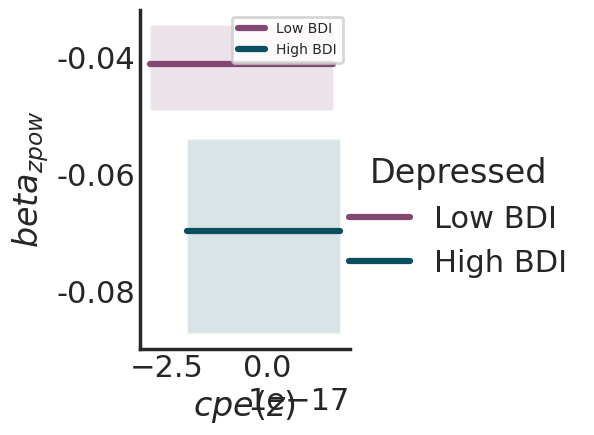

In [549]:
sns.set_theme(style='ticks') 
sns.set_context("poster")

# from matplotlib import rc
# rc('text', usetex=False)


# fig,ax = plt.subplots(figsize=(8,5),dpi=500)
# sns.set_context("poster",rc={'axes.linewidth': 2})
# sns.set_theme(style='ticks') 

# palette={'depression':"#3f2755",'no depression':"#054a6f"}

palette={'High BDI':"#0b4e5f",'Low BDI':"#824973"}


sns.lmplot(data=beta_lmplot,x='decisionCPE',y='band_pow',hue='Depressed',scatter=False,ci=95,palette=palette)
# sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.1, 1),bbox_to_anchor=(-1, 0), ncol=2)

# sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1), borderaxespad=0.1,frameon=False,framealpha=0,
#                 fontsize='x-small',shadow=None,title=None,columnspacing=0.5,edgecolor=None,markerfirst=True,
#                 markerscale=4,labelcolor=None, ncol=2)


# sns.regplot(data=beta_lmplot[beta_lmplot.Depressed=='Low BDI'],x='decisionCPE',y='band_pow',scatter=False,
#            ci=95,color = '#824973',label='Low BDI')
# sns.regplot(data=beta_lmplot[beta_lmplot.Depressed=='High BDI'],x='decisionCPE',y='band_pow',scatter=False,
#            ci=95,color='#0b4e5f',label='High BDI')

plt.legend(fontsize=10)
# borderaxespad=0,frameon=False,framealpha=0,
# sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1.1), frameon=False,framealpha=0,
#                 fontsize='small',shadow=None,
#                 columnspacing=2,ncol=2)


plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 

plt.ylabel(r'$beta_{{{zpow}}}$')
plt.xlabel(r'$cpe(z)$')
sns.despine()
plt.tick_params(length=0)
# plt.text(7.25,0.07,f'rho: {np.round(r,3)} \n p: {np.round(p_r,6)}',fontsize=16)


plt.savefig(f'{fig_save_dir}/all_lmplot_cpe_bpow_bdi_{date}.pdf', format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)

In [ ]:
roi_not_ains = ['notIns' if roi != 'ains' else 'ains' for roi in beta_reg_df.roi.tolist()]
roi_not_ains

In [ ]:
beta_reg_df['roi_not_ains'] = roi_not_ains

In [ ]:
sns.set_theme(style='ticks') 
sns.set_context("poster")

# from matplotlib import rc
# rc('text', usetex=False)


fig,ax = plt.subplots(figsize=(8,5),dpi=500)
# sns.set_context("poster",rc={'axes.linewidth': 2})
# sns.set_theme(style='ticks') 

# palette={'depression':"#3f2755",'no depression':"#054a6f"}

palette={'high BDI':"#0b4e5f",'low BDI':"#997690"}


# ax = sns.lmplot(data=beta_reg_df,x='decisionCPE',y='band_pow',hue='Depression',scatter=False,ci=95,palette=palette)
# sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.1, 1),bbox_to_anchor=(-1, 0), ncol=2)

# sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1), borderaxespad=0.1,frameon=False,framealpha=0,
#                 fontsize='x-small',shadow=None,title=None,columnspacing=0.5,edgecolor=None,markerfirst=True,
#                 markerscale=4,labelcolor=None, ncol=2)


sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='Low BDI'],x='decisionCPE',y='band_pow',scatter=False,
           ci=95,color = '#997690',label='Low BDI')
sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='High BDI'],x='decisionCPE',y='band_pow',scatter=False,
           ci=95,color='#173b6f',label='High BDI')

plt.legend(fontsize=10)
# borderaxespad=0,frameon=False,framealpha=0,
sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1.1), frameon=False,framealpha=0,
                fontsize='small',shadow=None,
                columnspacing=2,ncol=2)


plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 

plt.ylabel(r'$beta_{{{zpow}}}$')
plt.xlabel(r'$cpe(z)$')
sns.despine()
plt.tick_params(length=0)
# plt.text(7.25,0.07,f'rho: {np.round(r,3)} \n p: {np.round(p_r,6)}',fontsize=16)


plt.savefig(f'{fig_save_dir}/all_lmplot_cpe_bpow_bdi_{date}.pdf', format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)

In [ ]:
# fig,ax = plt.subplots(figsize=(7,5),dpi=500)
sns.set_context("poster",rc={'axes.linewidth': 2})
sns.set_theme(style='ticks',rc={"figure.dpi": 300}) 

palette={'ains':"#3f2755",'notIns':"#054a6f"}

# palette={'depressed':"#3f2755",'not depressed':"#173b6f"}


ax = sns.lmplot(data=beta_reg_df,x='bdi',y='band_pow',hue='roi_not_ains',scatter=False,palette=palette,
                height=4,aspect=1.2)
#                 ,height=9, 
#            aspect=1,ci=95,
# sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.1, 1),bbox_to_anchor=(-1, 0), ncol=2)

sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1.1), borderaxespad=0,frameon=False,framealpha=0,
                fontsize='x-small',shadow=None,title=None,columnspacing=0.5,edgecolor=None,markerfirst=True,
                markerscale=4,labelcolor=None, ncol=2)


# sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='Low BDI'],x='decisionCPE',y='band_pow',scatter=False,
#            ci=95,color = '#2a4d69')
# sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='High BDI'],x='decisionCPE',y='band_pow',scatter=False,
#            ci=95,color='#054a6f')

# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 

plt.ylabel(r'$beta_{{{zpow}}}$')
plt.xlabel(r'$bdi$')
sns.despine()
plt.tick_params(length=0)
# plt.text(7.25,0.07,f'rho: {np.round(r,3)} \n p: {np.round(p_r,6)}',fontsize=16)


plt.savefig(f'{fig_save_dir}/all_lm_powbybdi_ainsvsnot{date}.pdf', format='pdf', metadata=None,
bbox_inches=None, pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)

In [ ]:
# fig,ax = plt.subplots(figsize=(7,5),dpi=500)
sns.set_context("poster",rc={'axes.linewidth': 2})
sns.set_theme(style='ticks',rc={"figure.dpi": 300}) 

# palette={'depression':"#3f2755",'no depression':"#054a6f"}

# palette={'depressed':"#3f2755",'not depressed':"#173b6f"}


ax = sns.lmplot(data=beta_reg_df,x='bdi',y='band_pow',hue='roi_not_ains',scatter=False,height=4, 
           aspect=1,ci=95,palette='flare')
# sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.1, 1),bbox_to_anchor=(-1, 0), ncol=2)

sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1), borderaxespad=0.1,frameon=False,framealpha=0,
                fontsize='x-small',shadow=None,title=None,columnspacing=0.5,edgecolor=None,markerfirst=True,
                markerscale=4,labelcolor=None, ncol=2)


# sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='Low BDI'],x='decisionCPE',y='band_pow',scatter=False,
#            ci=95,color = '#2a4d69')
# sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='High BDI'],x='decisionCPE',y='band_pow',scatter=False,
#            ci=95,color='#054a6f')

# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 

plt.ylabel(r'$beta_{{{zpow}}}$')
plt.xlabel(r'$bdi$')
sns.despine()
plt.tick_params(length=0)
# plt.text(7.25,0.07,f'rho: {np.round(r,3)} \n p: {np.round(p_r,6)}',fontsize=16)


plt.savefig(f'{fig_save_dir}/all_lm_plotroibeta{date}.pdf', format='pdf', metadata=None,
bbox_inches=None, pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)

In [ ]:
final_vars = ['C(GambleChoice)', 'TotalProfit', 'decisionCPE']


In [ ]:

final_fit = fit_mixed_model(beta_reg_df,final_vars,outcome_var,rand_eff_var,reml=False)
print(final_fit.summary())
    

In [ ]:
final_fit.pvalues['decisionCPE']

In [ ]:
mixed_effects_ftest_ttest(final_fit)

In [ ]:
fe_param_names = list(final_fit.fe_params.index[1:])
fe_param_names

In [ ]:
plot_data = pd.concat([pd.DataFrame(
    {**{'subj_id':elec_id.split('_')[0],'reref_ch_names':elec_id.split('_')[1]},'unique_reref_ch':elec_id,
     **{f'raw_{param}':final_fit.random_effects[elec_id][param] for param in list(
            final_fit.random_effects[elec_id].index)}},index=[range(len(fe_param_names))])
        
    for elec_id in final_fit.random_effects.keys()]).reset_index(drop=True)

plot_data['roi'] = [beta_reg_df.roi[beta_reg_df.unique_reref_ch == row.unique_reref_ch].values[0]
                                for idx,row in plot_data.iterrows()]

plot_data['bdi'] = [subj_info_df.bdi[subj_info_df.subj_id == subj_id].values[0]
                                for subj_id in plot_data.subj_id]

In [ ]:
plot_data

In [ ]:
#### Get all results for Figs!!!!

fe_intercept   = final_fit.params['Intercept']
fe_cpe_beta    = final_fit.params['decisionCPE']
fe_cpe_beta


In [ ]:
#### add fixed effects data to all_elec_plot_data
plot_data['elec_b0']   = np.add(plot_data.raw_Group,fe_intercept)
plot_data['elec_bCPE'] = np.add(plot_data.raw_decisionCPE,fe_cpe_beta)
plot_data = plot_data[~plot_data.roi.isnull()]

In [ ]:
plot_data

In [ ]:
raw_roi_stats = {f'{roi}':ttest_1samp(plot_data.raw_decisionCPE[plot_data.roi == roi].unique(),
                 popmean=0) for roi in plot_data.roi.unique().tolist()}
raw_roi_stats

In [ ]:
roi_stats = {f'{roi}':ttest_1samp(plot_data.elec_bCPE[plot_data.roi == roi].unique(),
                 popmean=0) for roi in plot_data.roi.unique().tolist()}
roi_stats

In [ ]:
bonferr_alpha = 0.05/(len(plot_data.roi.unique().tolist()))
bonferr_alpha

In [ ]:
print('sig ROIs after multiple comp correction: ',[(roi,raw_roi_stats[roi].pvalue) for roi in raw_roi_stats.keys()
                                                   if raw_roi_stats[roi].pvalue< bonferr_alpha])
# print('sig ROI pvals: ',roi_stats.roi_cpe_pval[roi_beta_results.roi_cpe_pval<=bonferr_alpha].unique().tolist())


In [ ]:
print('sig ROIs after multiple comp correction: ',[(roi,roi_stats[roi].pvalue) for roi in roi_stats.keys()
                                                   if roi_stats[roi].pvalue< bonferr_alpha])
# print('sig ROI pvals: ',roi_stats.roi_cpe_pval[roi_beta_results.roi_cpe_pval<=bonferr_alpha].unique().tolist())




In [ ]:
roi_stats.keys()

In [ ]:
# roi_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','hpc','amy','mtg','motor','thalamus']
roi_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','hpc','amy','mtg']

In [ ]:
roi_plot_data = plot_data.copy()
roi_plot_data = roi_plot_data[roi_plot_data.roi.isin(roi_order)]

# roi_plot_names = {'thalamus':'THAL','hpc':'HPC','amy':'AMY','acc':'ACC','ofc':'OFC','ains':'aINS',
#                   'pins':'pINS','dmpfc':'dmPFC','dlpfc':'dlPFC','vlpfc':'vlPFC'}


In [ ]:
# roi_plot_data

In [ ]:
sns.set_context("poster",rc={'axes.linewidth': 1.5})
fig,ax = plt.subplots(figsize=(15, 6),dpi=500)

fig_save_dir = f'{base_dir}ephys_analysis/figs/beta_regressions/'
os.makedirs(fig_save_dir,exist_ok=True)

sns.barplot(data = roi_plot_data,
            x = 'roi',
#             y = 'elec_bCPE',
            y='raw_decisionCPE',
#             color = '#561C46',
#             color = '#00467e',
#             color = '#346a97',
            color = '#346a97',
            saturation=1,
            order=roi_order,
            errorbar=None) 


sns.stripplot(data = roi_plot_data,
            x = 'roi',
#             y = 'elec_bCPE',
              y='raw_decisionCPE',
#               color='#78496b', 
              color = '#00467e',
              alpha=.4,
              dodge=True,
              order=roi_order,
              size = 8)

ax.axhline(y=0,color='#00467e',linewidth=1.5)
plt.tick_params(length=0 )#,grid_linewidth=1)

# plt.ylim([-0.05,0.05])
ax.set(xlabel=None)
# plt.ylabel('CPE Encoding in Beta Power (z)')
# plt.ylabel('beta(z) cpe encoding')
plt.ylabel(r'$beta_{{{zpow}}}$'+ ' cpe encoding')
# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) 
# plt.locator_params(axis='y', nbins=5,tight=True)


sns.despine()
    
plt.savefig(f'{fig_save_dir}/Bpow_CPE_barplot_{date}.pdf', format='pdf', metadata=None,
bbox_inches=None, pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)


In [ ]:
rho_data = []
sig_rho = []

# BDI CORRELATIONS
for roi in plot_data.roi.unique().tolist()[:-1]:
    roi_temp_data = plot_data[plot_data.roi==roi]
    rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.raw_decisionCPE)
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
    rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':rho_p},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
    if rho_p < bonferr_alpha: 
        sig_rho.append((roi,rho,rho_p))
    print(f'{roi} pearsonr',rho,rho_p)
rho_data = pd.concat(rho_data).reset_index(drop=True)


In [ ]:
sig_rho

In [ ]:
rho_data['plot_p'] = [0.001 if roi.rho_p < 0.001 else np.round(roi.rho_p,4) for ix,roi in rho_data.iterrows()]

In [ ]:
new_plot_ps = []
for p in rho_data['plot_p']:
    new_p = 0
    
    for ix,val in enumerate(str(p)):
        if val == '0':
            continue
        elif val == '.':
            continue
        else: 
#             print(ix,val)
            new_p = str(p)[:ix+1]
            break
            
            

    new_plot_ps.append(float(new_p))
#         print(val)

In [ ]:
rho_data['round_p']   = new_plot_ps
rho_data['round_rho'] = np.round(rho_data.rho,2)
rho_data

In [ ]:

sns.set_context("poster",rc={'axes.linewidth': 1.5})

for roi in plot_data.roi.unique().tolist()[:-1]:
    roi_temp_data = plot_data[plot_data.roi==roi]

    rho   = rho_data[rho_data.roi == roi].round_rho.values[0]
    rho_p = rho_data[rho_data.roi == roi].round_p.values[0]
    
        
    fig = plt.figure(figsize=(7,5),dpi=300)

    sns.regplot(data=roi_temp_data,x='bdi',y='raw_decisionCPE',scatter=False,ci=95,
                fit_reg=True,color = '#00467e') #034975
    
    sns.scatterplot(data = roi_temp_data.groupby(['subj_id']).agg('mean'),x='bdi',
                    y='raw_decisionCPE',color = '#00467e',edgecolor=None,alpha=0.8)
    
#     plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
    plt.xlabel('BDI-II')
    
    plt.tick_params(length=0) 
    plt.ylabel('beta'+r'$_{{{zpow}}}$'+' cpe encoding')

    plt.text(np.max(roi_temp_data.bdi)-8,
             np.round(np.max(roi_temp_data.groupby(['subj_id']).agg('mean').raw_decisionCPE),3)-0.003,
             r'$rho$ = '+f'{rho} '+'\n '+r'$p < $'+f'{rho_p}',
             color='#00467e',fontsize=16)

    plt.title(f'{roi}',fontsize=24)


    
    sns.despine()
    
    plt.savefig(f'{fig_save_dir}/{roi}_{rho}_{rho_p}_roi_bdi_beta-cpe-slope.pdf', format='pdf', metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=300,
        facecolor='auto', edgecolor='auto',
        backend=None)
    

# Beta x BDI Interaction
- Rerun final mixed effects model on each ROI separately
- Correlate random effects slopes for each regressor with BDI

In [ ]:
rand_eff_var = 'unique_reref_ch'


In [ ]:
beta_reg_df

In [ ]:
bdi_vars    = ['decisionCPE','bdi','decisionCPE:bdi']
outcome_var = 'band_pow'

bdi_fit = fit_mixed_model(beta_reg_df,bdi_vars,outcome_var,rand_eff_var,reml=False)
print(bdi_fit.summary())
    

In [ ]:
fe_param_names = list(bdi_fit.fe_params.index[1:])
fe_param_names

In [ ]:
bdi_plot_data = pd.concat([pd.DataFrame(
    {**{'subj_id':elec_id.split('_')[0],'reref_ch_names':elec_id.split('_')[1]},'unique_reref_ch':elec_id,
     **{f'raw_{param}':bdi_fit.random_effects[elec_id][param] for param in list(
            bdi_fit.random_effects[elec_id].index)}},index=[range(len(fe_param_names))])
        
    for elec_id in bdi_fit.random_effects.keys()]).reset_index(drop=True)

bdi_plot_data['roi'] = [beta_reg_df.roi[beta_reg_df.unique_reref_ch == row.unique_reref_ch].values[0]
                                for idx,row in bdi_plot_data.iterrows()]

bdi_plot_data['bdi'] = [subj_info_df.bdi[subj_info_df.subj_id == subj_id].values[0]
                                for subj_id in bdi_plot_data.subj_id]

In [ ]:
bdi_plot_data

In [ ]:
#### Get all results for Figs!!!!

fe_intercept   = bdi_fit.params['Intercept']
fe_cpe_beta    = bdi_fit.params['decisionCPE:bdi']
fe_cpe_beta


In [ ]:
#### add fixed effects data to all_elec_plot_data
bdi_plot_data['elec_b0']   = np.add(bdi_plot_data.raw_Group,fe_intercept)
bdi_plot_data['elec_bCPE'] = np.add(bdi_plot_data['raw_decisionCPE:bdi'],fe_cpe_beta)
bdi_plot_data = bdi_plot_data[~bdi_plot_data.roi.isnull()]

In [ ]:
bdi_plot_data

In [ ]:
# raw_bdi

raw_roi_stats = {f'{roi}':ttest_1samp(bdi_plot_data['raw_bdi'][bdi_plot_data.roi == roi].unique(),
                 popmean=0) for roi in bdi_plot_data.roi.unique().tolist()}
raw_roi_stats

In [ ]:
raw_roi_stats = {f'{roi}':ttest_1samp(bdi_plot_data['raw_decisionCPE:bdi'][bdi_plot_data.roi == roi].unique(),
                 popmean=0) for roi in bdi_plot_data.roi.unique().tolist()}
raw_roi_stats

In [ ]:
roi_stats = {f'{roi}':ttest_1samp(bdi_plot_data.elec_bCPE[bdi_plot_data.roi == roi].unique(),
                 popmean=0) for roi in bdi_plot_data.roi.unique().tolist()}
roi_stats

In [ ]:
bonferr_alpha = 0.05/len(roi_stats)
# bonferr_alpha = 0.05/len(bdi_plot_data.roi.unique().tolist())
bonferr_alpha

In [ ]:
print('sig ROIs after multiple comp correction: ',[(roi,raw_roi_stats[roi].pvalue) for roi in raw_roi_stats.keys()
                                                   if raw_roi_stats[roi].pvalue< bonferr_alpha])
# print('sig ROI pvals: ',roi_stats.roi_cpe_pval[roi_beta_results.roi_cpe_pval<=bonferr_alpha].unique().tolist())


In [ ]:
print('sig ROIs after multiple comp correction: ',[(roi,roi_stats[roi].pvalue) for roi in roi_stats.keys()
                                                   if roi_stats[roi].pvalue< bonferr_alpha])
# print('sig ROI pvals: ',roi_stats.roi_cpe_pval[roi_beta_results.roi_cpe_pval<=bonferr_alpha].unique().tolist())




In [ ]:
roi_stats

In [ ]:
roi_stats.keys()

In [ ]:
# roi_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','hpc','amy','mtg','motor','thalamus']
roi_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','hpc','amy']

In [ ]:
roi_bdi_plot_data = bdi_plot_data.copy()
roi_bdi_plot_data = roi_bdi_plot_data[roi_bdi_plot_data.roi.isin(roi_order)]

# roi_plot_names = {'thalamus':'THAL','hpc':'HPC','amy':'AMY','acc':'ACC','ofc':'OFC','ains':'aINS',
#                   'pins':'pINS','dmpfc':'dmPFC','dlpfc':'dlPFC','vlpfc':'vlPFC'}


In [ ]:
roi_bdi_plot_data['raw_decisionCPE:bdi']

In [ ]:
sns.set_context("poster")
fig,ax = plt.subplots(figsize=(15, 6),dpi=500)

fig_save_dir = f'{base_dir}ephys_analysis/figs/beta_regressions/'
os.makedirs(fig_save_dir,exist_ok=True)

sns.barplot(data = roi_bdi_plot_data,
            x = 'roi',
            y = 'raw_decisionCPE:bdi',
#             y='elec_bCPE',
            color = '#561C46', #173b6f
            saturation=0.8,
            order=roi_order,
            errorbar=None) 


sns.stripplot(data = roi_bdi_plot_data,
            x = 'roi',
            y = 'raw_decisionCPE:bdi',
              color = '#561C46',
              alpha=.4,
              dodge=True,
              order=roi_order,
              size = 8)

ax.axhline(y=0,color='#561C46',linewidth=1.5)
plt.tick_params(length=0 )#,grid_linewidth=1)

# plt.ylim([-0.02,0.017])
ax.set(xlabel=None)

plt.ylabel(r'$beta_{{{zpow}}} \sim cpe:bdi$')
# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) 
plt.locator_params(axis='y', nbins=6,tight=True)



sns.despine()
    
plt.savefig(f'{fig_save_dir}/Bpow_CPEBDIINT{date}.pdf', format='pdf', metadata=None,
bbox_inches=None, pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)

In [ ]:
####### BDI ~ BPOW SIG FOR THESE ROIS!!!

In [ ]:
print('sig ROIs after multiple comp correction: ',[(roi,raw_roi_stats[roi].pvalue) for roi in raw_roi_stats.keys()
                                                   if raw_roi_stats[roi].pvalue< bonferr_alpha])
# print('sig ROI pvals: ',roi_stats.roi_cpe_pval[roi_beta_results.roi_cpe_pval<=bonferr_alpha].unique().tolist())


In [ ]:
roi_bdi_plot_data

In [ ]:
print('sig ROIs after multiple comp correction: ',[(roi,ttest_1samp(roi_bdi_plot_data[
    roi_bdi_plot_data.roi == roi]['raw_decisionCPE:bdi'].to_numpy(),
                                     popmean=0).pvalue) for roi in roi_bdi_plot_data.roi.unique().tolist()
                                                  if ttest_1samp(roi_bdi_plot_data[
    roi_bdi_plot_data.roi == roi]['raw_decisionCPE:bdi'].to_numpy(),
                                     popmean=0).pvalue < bonferr_alpha])




In [ ]:
print('sig ROIs after multiple comp correction: ',[(roi,ttest_1samp(roi_bdi_plot_data[
    roi_bdi_plot_data.roi == roi]['raw_bdi'].to_numpy(),
                                     popmean=0).pvalue) for roi in roi_bdi_plot_data.roi.unique().tolist()
                                                  if ttest_1samp(roi_bdi_plot_data[
    roi_bdi_plot_data.roi == roi]['raw_bdi'].to_numpy(),
                                     popmean=0).pvalue < bonferr_alpha])




In [ ]:
sns.set_context("poster")
fig,ax = plt.subplots(figsize=(15, 6),dpi=500)

fig_save_dir = f'{base_dir}ephys_analysis/figs/beta_regressions/'
os.makedirs(fig_save_dir,exist_ok=True)

sns.barplot(data = roi_bdi_plot_data,
            x = 'roi',
            y = 'raw_bdi',
#             y='elec_bCPE',
            color = '#173b6f', #173b6f
            saturation=0.8,
            order=roi_order,
            errorbar=None) 


sns.stripplot(data = roi_bdi_plot_data,
            x = 'roi',
            y = 'raw_bdi',
              color = '#173b6f',
              alpha=.4,
              dodge=True,
              order=roi_order,
              size = 8)

ax.axhline(y=0,color='#173b6f',linewidth=1.5)
plt.tick_params(length=0 )#,grid_linewidth=1)

# plt.ylim([-0.02,0.017])
ax.set(xlabel=None)

# plt.ylabel(r'$beta_{{{zpow}}} \sim cpe:bdi$')
plt.ylabel(r'$beta_{{{zpow}}} \sim bdi$')
# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) 
plt.locator_params(axis='y', nbins=6,tight=True)



sns.despine()
    
plt.savefig(f'{fig_save_dir}/BPOW~BDIbyROI{date}.pdf', format='pdf', metadata=None,
bbox_inches=None, pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)

In [ ]:
roi_bdi_plot_data

In [ ]:
# roi_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','hpc','amy']

In [ ]:
beta_reg_df.groupby('roi')

In [ ]:
beta_reg_df['BDI-II'] = ['Low' if bdi<20 else 'High' for bdi in beta_reg_df.bdi]
beta_reg_df

In [ ]:
palette=dict(Low="#3f2755", High="#054a6f")
# sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)


In [ ]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(df.x,df.y)

In [ ]:
# beta_reg_df['Depression'] = ['depressed' if bdi >=20 else 'not depressed' for bdi in beta_reg_df.bdi.tolist()]
beta_reg_df['Depression'] = ['high BDI' if bdi >=20 else 'low BDI' for bdi in beta_reg_df.bdi.tolist()]

In [ ]:
# edgecolor=None,markerfirst=True,title=None,#title_fontsize='x-small',
#                 markerscale=0.2,labelcolor=None

In [ ]:
sns.set_theme(style='ticks') 
sns.set_context("poster")

# from matplotlib import rc
# rc('text', usetex=False)


fig,ax = plt.subplots(figsize=(8,5),dpi=500)
# sns.set_context("poster",rc={'axes.linewidth': 2})
# sns.set_theme(style='ticks') 

# palette={'depression':"#3f2755",'no depression':"#054a6f"}

palette={'high BDI':"#0b4e5f",'low BDI':"#824973"}


# ax = sns.lmplot(data=beta_reg_df,x='decisionCPE',y='band_pow',hue='Depression',scatter=False,ci=95,palette=palette)
# sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.1, 1),bbox_to_anchor=(-1, 0), ncol=2)

# sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1), borderaxespad=0.1,frameon=False,framealpha=0,
#                 fontsize='x-small',shadow=None,title=None,columnspacing=0.5,edgecolor=None,markerfirst=True,
#                 markerscale=4,labelcolor=None, ncol=2)


sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='Low BDI'],x='decisionCPE',y='band_pow',scatter=False,
           ci=95,color = '#824973',label='Low BDI')
sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='High BDI'],x='decisionCPE',y='band_pow',scatter=False,
           ci=95,color='#0b4e5f',label='High BDI')

plt.legend(fontsize=10)
# borderaxespad=0,frameon=False,framealpha=0,
sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1.1), frameon=False,framealpha=0,
                fontsize='small',shadow=None,
                columnspacing=2,ncol=2)


plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 

plt.ylabel(r'$beta_{{{zpow}}}$')
plt.xlabel(r'$cpe(z)$')
sns.despine()
plt.tick_params(length=0)
# plt.text(7.25,0.07,f'rho: {np.round(r,3)} \n p: {np.round(p_r,6)}',fontsize=16)


plt.savefig(f'{fig_save_dir}/all_lmplot_cpe_bpow_bdi_{date}.pdf', format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)

In [ ]:
roi_not_ains = ['notIns' if roi != 'ains' else 'ains' for roi in beta_reg_df.roi.tolist()]
roi_not_ains

In [ ]:
beta_reg_df['roi_not_ains'] = roi_not_ains

In [ ]:
sns.set_theme(style='ticks') 
sns.set_context("poster")

# from matplotlib import rc
# rc('text', usetex=False)


fig,ax = plt.subplots(figsize=(8,5),dpi=500)
# sns.set_context("poster",rc={'axes.linewidth': 2})
# sns.set_theme(style='ticks') 

# palette={'depression':"#3f2755",'no depression':"#054a6f"}

palette={'high BDI':"#0b4e5f",'low BDI':"#997690"}


# ax = sns.lmplot(data=beta_reg_df,x='decisionCPE',y='band_pow',hue='Depression',scatter=False,ci=95,palette=palette)
# sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.1, 1),bbox_to_anchor=(-1, 0), ncol=2)

# sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1), borderaxespad=0.1,frameon=False,framealpha=0,
#                 fontsize='x-small',shadow=None,title=None,columnspacing=0.5,edgecolor=None,markerfirst=True,
#                 markerscale=4,labelcolor=None, ncol=2)


sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='Low BDI'],x='decisionCPE',y='band_pow',scatter=False,
           ci=95,color = '#997690',label='Low BDI')
sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='High BDI'],x='decisionCPE',y='band_pow',scatter=False,
           ci=95,color='#173b6f',label='High BDI')

plt.legend(fontsize=10)
# borderaxespad=0,frameon=False,framealpha=0,
sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1.1), frameon=False,framealpha=0,
                fontsize='small',shadow=None,
                columnspacing=2,ncol=2)


plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 

plt.ylabel(r'$beta_{{{zpow}}}$')
plt.xlabel(r'$cpe(z)$')
sns.despine()
plt.tick_params(length=0)
# plt.text(7.25,0.07,f'rho: {np.round(r,3)} \n p: {np.round(p_r,6)}',fontsize=16)


plt.savefig(f'{fig_save_dir}/all_lmplot_cpe_bpow_bdi_{date}.pdf', format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)

In [ ]:
# fig,ax = plt.subplots(figsize=(7,5),dpi=500)
sns.set_context("poster",rc={'axes.linewidth': 2})
sns.set_theme(style='ticks',rc={"figure.dpi": 300}) 

palette={'ains':"#3f2755",'notIns':"#054a6f"}

# palette={'depressed':"#3f2755",'not depressed':"#173b6f"}


ax = sns.lmplot(data=beta_reg_df,x='bdi',y='band_pow',hue='roi_not_ains',scatter=False,palette=palette,
                height=4,aspect=1.2)
#                 ,height=9, 
#            aspect=1,ci=95,
# sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.1, 1),bbox_to_anchor=(-1, 0), ncol=2)

sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1.1), borderaxespad=0,frameon=False,framealpha=0,
                fontsize='x-small',shadow=None,title=None,columnspacing=0.5,edgecolor=None,markerfirst=True,
                markerscale=4,labelcolor=None, ncol=2)


# sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='Low BDI'],x='decisionCPE',y='band_pow',scatter=False,
#            ci=95,color = '#2a4d69')
# sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='High BDI'],x='decisionCPE',y='band_pow',scatter=False,
#            ci=95,color='#054a6f')

# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 

plt.ylabel(r'$beta_{{{zpow}}}$')
plt.xlabel(r'$bdi$')
sns.despine()
plt.tick_params(length=0)
# plt.text(7.25,0.07,f'rho: {np.round(r,3)} \n p: {np.round(p_r,6)}',fontsize=16)


plt.savefig(f'{fig_save_dir}/all_lm_powbybdi_ainsvsnot{date}.pdf', format='pdf', metadata=None,
bbox_inches=None, pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)

In [ ]:
# fig,ax = plt.subplots(figsize=(7,5),dpi=500)
sns.set_context("poster",rc={'axes.linewidth': 2})
sns.set_theme(style='ticks',rc={"figure.dpi": 300}) 

# palette={'depression':"#3f2755",'no depression':"#054a6f"}

# palette={'depressed':"#3f2755",'not depressed':"#173b6f"}


ax = sns.lmplot(data=beta_reg_df,x='bdi',y='band_pow',hue='roi_not_ains',scatter=False,height=4, 
           aspect=1,ci=95,palette='flare')
# sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.1, 1),bbox_to_anchor=(-1, 0), ncol=2)

sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1), borderaxespad=0.1,frameon=False,framealpha=0,
                fontsize='x-small',shadow=None,title=None,columnspacing=0.5,edgecolor=None,markerfirst=True,
                markerscale=4,labelcolor=None, ncol=2)


# sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='Low BDI'],x='decisionCPE',y='band_pow',scatter=False,
#            ci=95,color = '#2a4d69')
# sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='High BDI'],x='decisionCPE',y='band_pow',scatter=False,
#            ci=95,color='#054a6f')

# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 

plt.ylabel(r'$beta_{{{zpow}}}$')
plt.xlabel(r'$bdi$')
sns.despine()
plt.tick_params(length=0)
# plt.text(7.25,0.07,f'rho: {np.round(r,3)} \n p: {np.round(p_r,6)}',fontsize=16)


plt.savefig(f'{fig_save_dir}/all_lm_plotroibeta{date}.pdf', format='pdf', metadata=None,
bbox_inches=None, pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)

In [20]:
beta_reg_df.roi.unique().tolist()

['acc',
 'dmpfc',
 'amy',
 'sts',
 'ains',
 'vlpfc',
 'hpc',
 'mtg',
 'ofc',
 'pins',
 'dlpfc',
 'motor',
 'vmpfc',
 'phg',
 'smg',
 'stg',
 'mcc',
 'temporal pole',
 'parietal',
 'thalamus']

In [ ]:
final_vars = ['C(GambleChoice)', 'TotalProfit', 'decisionCPE']


In [ ]:

final_fit = fit_mixed_model(beta_reg_df,final_vars,outcome_var,rand_eff_var,reml=False)
print(final_fit.summary())
    

In [ ]:
final_fit.pvalues['decisionCPE']

In [ ]:
mixed_effects_ftest_ttest(final_fit)

In [ ]:
fe_param_names = list(final_fit.fe_params.index[1:])
fe_param_names

In [ ]:
plot_data = pd.concat([pd.DataFrame(
    {**{'subj_id':elec_id.split('_')[0],'reref_ch_names':elec_id.split('_')[1]},'unique_reref_ch':elec_id,
     **{f'raw_{param}':final_fit.random_effects[elec_id][param] for param in list(
            final_fit.random_effects[elec_id].index)}},index=[range(len(fe_param_names))])
        
    for elec_id in final_fit.random_effects.keys()]).reset_index(drop=True)

plot_data['roi'] = [beta_reg_df.roi[beta_reg_df.unique_reref_ch == row.unique_reref_ch].values[0]
                                for idx,row in plot_data.iterrows()]

plot_data['bdi'] = [subj_info_df.bdi[subj_info_df.subj_id == subj_id].values[0]
                                for subj_id in plot_data.subj_id]

In [ ]:
plot_data

In [ ]:
#### Get all results for Figs!!!!

fe_intercept   = final_fit.params['Intercept']
fe_cpe_beta    = final_fit.params['decisionCPE']
fe_cpe_beta


In [ ]:
#### add fixed effects data to all_elec_plot_data
plot_data['elec_b0']   = np.add(plot_data.raw_Group,fe_intercept)
plot_data['elec_bCPE'] = np.add(plot_data.raw_decisionCPE,fe_cpe_beta)
plot_data = plot_data[~plot_data.roi.isnull()]

In [ ]:
plot_data

In [ ]:
raw_roi_stats = {f'{roi}':ttest_1samp(plot_data.raw_decisionCPE[plot_data.roi == roi].unique(),
                 popmean=0) for roi in plot_data.roi.unique().tolist()}
raw_roi_stats

In [ ]:
roi_stats = {f'{roi}':ttest_1samp(plot_data.elec_bCPE[plot_data.roi == roi].unique(),
                 popmean=0) for roi in plot_data.roi.unique().tolist()}
roi_stats

In [ ]:
bonferr_alpha = 0.05/(len(plot_data.roi.unique().tolist()))
bonferr_alpha

In [ ]:
print('sig ROIs after multiple comp correction: ',[(roi,raw_roi_stats[roi].pvalue) for roi in raw_roi_stats.keys()
                                                   if raw_roi_stats[roi].pvalue< bonferr_alpha])
# print('sig ROI pvals: ',roi_stats.roi_cpe_pval[roi_beta_results.roi_cpe_pval<=bonferr_alpha].unique().tolist())


In [ ]:
print('sig ROIs after multiple comp correction: ',[(roi,roi_stats[roi].pvalue) for roi in roi_stats.keys()
                                                   if roi_stats[roi].pvalue< bonferr_alpha])
# print('sig ROI pvals: ',roi_stats.roi_cpe_pval[roi_beta_results.roi_cpe_pval<=bonferr_alpha].unique().tolist())




In [ ]:
roi_stats.keys()

In [ ]:
# roi_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','hpc','amy','mtg','motor','thalamus']
roi_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','hpc','amy','mtg']

In [ ]:
roi_plot_data = plot_data.copy()
roi_plot_data = roi_plot_data[roi_plot_data.roi.isin(roi_order)]

# roi_plot_names = {'thalamus':'THAL','hpc':'HPC','amy':'AMY','acc':'ACC','ofc':'OFC','ains':'aINS',
#                   'pins':'pINS','dmpfc':'dmPFC','dlpfc':'dlPFC','vlpfc':'vlPFC'}


In [ ]:
# roi_plot_data

In [ ]:
sns.set_context("poster",rc={'axes.linewidth': 1.5})
fig,ax = plt.subplots(figsize=(15, 6),dpi=500)

fig_save_dir = f'{base_dir}ephys_analysis/figs/beta_regressions/'
os.makedirs(fig_save_dir,exist_ok=True)

sns.barplot(data = roi_plot_data,
            x = 'roi',
#             y = 'elec_bCPE',
            y='raw_decisionCPE',
#             color = '#561C46',
#             color = '#00467e',
#             color = '#346a97',
            color = '#346a97',
            saturation=1,
            order=roi_order,
            errorbar=None) 


sns.stripplot(data = roi_plot_data,
            x = 'roi',
#             y = 'elec_bCPE',
              y='raw_decisionCPE',
#               color='#78496b', 
              color = '#00467e',
              alpha=.4,
              dodge=True,
              order=roi_order,
              size = 8)

ax.axhline(y=0,color='#00467e',linewidth=1.5)
plt.tick_params(length=0 )#,grid_linewidth=1)

# plt.ylim([-0.05,0.05])
ax.set(xlabel=None)
# plt.ylabel('CPE Encoding in Beta Power (z)')
# plt.ylabel('beta(z) cpe encoding')
plt.ylabel(r'$beta_{{{zpow}}}$'+ ' cpe encoding')
# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) 
# plt.locator_params(axis='y', nbins=5,tight=True)


sns.despine()
    
plt.savefig(f'{fig_save_dir}/Bpow_CPE_barplot_{date}.pdf', format='pdf', metadata=None,
bbox_inches=None, pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)


In [ ]:
rho_data = []
sig_rho = []

# BDI CORRELATIONS
for roi in plot_data.roi.unique().tolist()[:-1]:
    roi_temp_data = plot_data[plot_data.roi==roi]
    rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.raw_decisionCPE)
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
    rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':rho_p},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
    if rho_p < bonferr_alpha: 
        sig_rho.append((roi,rho,rho_p))
    print(f'{roi} pearsonr',rho,rho_p)
rho_data = pd.concat(rho_data).reset_index(drop=True)


In [ ]:
sig_rho

In [ ]:
rho_data['plot_p'] = [0.001 if roi.rho_p < 0.001 else np.round(roi.rho_p,4) for ix,roi in rho_data.iterrows()]

In [ ]:
new_plot_ps = []
for p in rho_data['plot_p']:
    new_p = 0
    
    for ix,val in enumerate(str(p)):
        if val == '0':
            continue
        elif val == '.':
            continue
        else: 
#             print(ix,val)
            new_p = str(p)[:ix+1]
            break
            
            

    new_plot_ps.append(float(new_p))
#         print(val)

In [ ]:
rho_data['round_p']   = new_plot_ps
rho_data['round_rho'] = np.round(rho_data.rho,2)
rho_data

In [ ]:

sns.set_context("poster",rc={'axes.linewidth': 1.5})

for roi in plot_data.roi.unique().tolist()[:-1]:
    roi_temp_data = plot_data[plot_data.roi==roi]

    rho   = rho_data[rho_data.roi == roi].round_rho.values[0]
    rho_p = rho_data[rho_data.roi == roi].round_p.values[0]
    
        
    fig = plt.figure(figsize=(7,5),dpi=300)

    sns.regplot(data=roi_temp_data,x='bdi',y='raw_decisionCPE',scatter=False,ci=95,
                fit_reg=True,color = '#00467e') #034975
    
    sns.scatterplot(data = roi_temp_data.groupby(['subj_id']).agg('mean'),x='bdi',
                    y='raw_decisionCPE',color = '#00467e',edgecolor=None,alpha=0.8)
    
#     plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
    plt.xlabel('BDI-II')
    
    plt.tick_params(length=0) 
    plt.ylabel('beta'+r'$_{{{zpow}}}$'+' cpe encoding')

    plt.text(np.max(roi_temp_data.bdi)-8,
             np.round(np.max(roi_temp_data.groupby(['subj_id']).agg('mean').raw_decisionCPE),3)-0.003,
             r'$rho$ = '+f'{rho} '+'\n '+r'$p < $'+f'{rho_p}',
             color='#00467e',fontsize=16)

    plt.title(f'{roi}',fontsize=24)


    
    sns.despine()
    
    plt.savefig(f'{fig_save_dir}/{roi}_{rho}_{rho_p}_roi_bdi_beta-cpe-slope.pdf', format='pdf', metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=300,
        facecolor='auto', edgecolor='auto',
        backend=None)
    

# Beta x BDI Interaction
- Rerun final mixed effects model on each ROI separately
- Correlate random effects slopes for each regressor with BDI

In [ ]:
rand_eff_var = 'unique_reref_ch'


In [ ]:
beta_reg_df

In [ ]:
bdi_vars    = ['decisionCPE','bdi','decisionCPE:bdi']
outcome_var = 'band_pow'

bdi_fit = fit_mixed_model(beta_reg_df,bdi_vars,outcome_var,rand_eff_var,reml=False)
print(bdi_fit.summary())
    

In [ ]:
fe_param_names = list(bdi_fit.fe_params.index[1:])
fe_param_names

In [ ]:
bdi_plot_data = pd.concat([pd.DataFrame(
    {**{'subj_id':elec_id.split('_')[0],'reref_ch_names':elec_id.split('_')[1]},'unique_reref_ch':elec_id,
     **{f'raw_{param}':bdi_fit.random_effects[elec_id][param] for param in list(
            bdi_fit.random_effects[elec_id].index)}},index=[range(len(fe_param_names))])
        
    for elec_id in bdi_fit.random_effects.keys()]).reset_index(drop=True)

bdi_plot_data['roi'] = [beta_reg_df.roi[beta_reg_df.unique_reref_ch == row.unique_reref_ch].values[0]
                                for idx,row in bdi_plot_data.iterrows()]

bdi_plot_data['bdi'] = [subj_info_df.bdi[subj_info_df.subj_id == subj_id].values[0]
                                for subj_id in bdi_plot_data.subj_id]

In [ ]:
bdi_plot_data

In [ ]:
#### Get all results for Figs!!!!

fe_intercept   = bdi_fit.params['Intercept']
fe_cpe_beta    = bdi_fit.params['decisionCPE:bdi']
fe_cpe_beta


In [ ]:
#### add fixed effects data to all_elec_plot_data
bdi_plot_data['elec_b0']   = np.add(bdi_plot_data.raw_Group,fe_intercept)
bdi_plot_data['elec_bCPE'] = np.add(bdi_plot_data['raw_decisionCPE:bdi'],fe_cpe_beta)
bdi_plot_data = bdi_plot_data[~bdi_plot_data.roi.isnull()]

In [ ]:
bdi_plot_data

In [ ]:
# raw_bdi

raw_roi_stats = {f'{roi}':ttest_1samp(bdi_plot_data['raw_bdi'][bdi_plot_data.roi == roi].unique(),
                 popmean=0) for roi in bdi_plot_data.roi.unique().tolist()}
raw_roi_stats

In [ ]:
raw_roi_stats = {f'{roi}':ttest_1samp(bdi_plot_data['raw_decisionCPE:bdi'][bdi_plot_data.roi == roi].unique(),
                 popmean=0) for roi in bdi_plot_data.roi.unique().tolist()}
raw_roi_stats

In [ ]:
roi_stats = {f'{roi}':ttest_1samp(bdi_plot_data.elec_bCPE[bdi_plot_data.roi == roi].unique(),
                 popmean=0) for roi in bdi_plot_data.roi.unique().tolist()}
roi_stats

In [ ]:
bonferr_alpha = 0.05/len(roi_stats)
# bonferr_alpha = 0.05/len(bdi_plot_data.roi.unique().tolist())
bonferr_alpha

In [ ]:
print('sig ROIs after multiple comp correction: ',[(roi,raw_roi_stats[roi].pvalue) for roi in raw_roi_stats.keys()
                                                   if raw_roi_stats[roi].pvalue< bonferr_alpha])
# print('sig ROI pvals: ',roi_stats.roi_cpe_pval[roi_beta_results.roi_cpe_pval<=bonferr_alpha].unique().tolist())


In [ ]:
print('sig ROIs after multiple comp correction: ',[(roi,roi_stats[roi].pvalue) for roi in roi_stats.keys()
                                                   if roi_stats[roi].pvalue< bonferr_alpha])
# print('sig ROI pvals: ',roi_stats.roi_cpe_pval[roi_beta_results.roi_cpe_pval<=bonferr_alpha].unique().tolist())




In [ ]:
roi_stats

In [ ]:
roi_stats.keys()

In [ ]:
# roi_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','hpc','amy','mtg','motor','thalamus']
roi_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','hpc','amy']

In [ ]:
roi_bdi_plot_data = bdi_plot_data.copy()
roi_bdi_plot_data = roi_bdi_plot_data[roi_bdi_plot_data.roi.isin(roi_order)]

# roi_plot_names = {'thalamus':'THAL','hpc':'HPC','amy':'AMY','acc':'ACC','ofc':'OFC','ains':'aINS',
#                   'pins':'pINS','dmpfc':'dmPFC','dlpfc':'dlPFC','vlpfc':'vlPFC'}


In [ ]:
roi_bdi_plot_data['raw_decisionCPE:bdi']

In [ ]:
sns.set_context("poster")
fig,ax = plt.subplots(figsize=(15, 6),dpi=500)

fig_save_dir = f'{base_dir}ephys_analysis/figs/beta_regressions/'
os.makedirs(fig_save_dir,exist_ok=True)

sns.barplot(data = roi_bdi_plot_data,
            x = 'roi',
            y = 'raw_decisionCPE:bdi',
#             y='elec_bCPE',
            color = '#561C46', #173b6f
            saturation=0.8,
            order=roi_order,
            errorbar=None) 


sns.stripplot(data = roi_bdi_plot_data,
            x = 'roi',
            y = 'raw_decisionCPE:bdi',
              color = '#561C46',
              alpha=.4,
              dodge=True,
              order=roi_order,
              size = 8)

ax.axhline(y=0,color='#561C46',linewidth=1.5)
plt.tick_params(length=0 )#,grid_linewidth=1)

# plt.ylim([-0.02,0.017])
ax.set(xlabel=None)

plt.ylabel(r'$beta_{{{zpow}}} \sim cpe:bdi$')
# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) 
plt.locator_params(axis='y', nbins=6,tight=True)



sns.despine()
    
plt.savefig(f'{fig_save_dir}/Bpow_CPEBDIINT{date}.pdf', format='pdf', metadata=None,
bbox_inches=None, pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)

In [ ]:
####### BDI ~ BPOW SIG FOR THESE ROIS!!!

In [ ]:
print('sig ROIs after multiple comp correction: ',[(roi,raw_roi_stats[roi].pvalue) for roi in raw_roi_stats.keys()
                                                   if raw_roi_stats[roi].pvalue< bonferr_alpha])
# print('sig ROI pvals: ',roi_stats.roi_cpe_pval[roi_beta_results.roi_cpe_pval<=bonferr_alpha].unique().tolist())


In [ ]:
roi_bdi_plot_data

In [ ]:
print('sig ROIs after multiple comp correction: ',[(roi,ttest_1samp(roi_bdi_plot_data[
    roi_bdi_plot_data.roi == roi]['raw_decisionCPE:bdi'].to_numpy(),
                                     popmean=0).pvalue) for roi in roi_bdi_plot_data.roi.unique().tolist()
                                                  if ttest_1samp(roi_bdi_plot_data[
    roi_bdi_plot_data.roi == roi]['raw_decisionCPE:bdi'].to_numpy(),
                                     popmean=0).pvalue < bonferr_alpha])




In [ ]:
print('sig ROIs after multiple comp correction: ',[(roi,ttest_1samp(roi_bdi_plot_data[
    roi_bdi_plot_data.roi == roi]['raw_bdi'].to_numpy(),
                                     popmean=0).pvalue) for roi in roi_bdi_plot_data.roi.unique().tolist()
                                                  if ttest_1samp(roi_bdi_plot_data[
    roi_bdi_plot_data.roi == roi]['raw_bdi'].to_numpy(),
                                     popmean=0).pvalue < bonferr_alpha])




In [ ]:
sns.set_context("poster")
fig,ax = plt.subplots(figsize=(15, 6),dpi=500)

fig_save_dir = f'{base_dir}ephys_analysis/figs/beta_regressions/'
os.makedirs(fig_save_dir,exist_ok=True)

sns.barplot(data = roi_bdi_plot_data,
            x = 'roi',
            y = 'raw_bdi',
#             y='elec_bCPE',
            color = '#173b6f', #173b6f
            saturation=0.8,
            order=roi_order,
            errorbar=None) 


sns.stripplot(data = roi_bdi_plot_data,
            x = 'roi',
            y = 'raw_bdi',
              color = '#173b6f',
              alpha=.4,
              dodge=True,
              order=roi_order,
              size = 8)

ax.axhline(y=0,color='#173b6f',linewidth=1.5)
plt.tick_params(length=0 )#,grid_linewidth=1)

# plt.ylim([-0.02,0.017])
ax.set(xlabel=None)

# plt.ylabel(r'$beta_{{{zpow}}} \sim cpe:bdi$')
plt.ylabel(r'$beta_{{{zpow}}} \sim bdi$')
# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) 
plt.locator_params(axis='y', nbins=6,tight=True)



sns.despine()
    
plt.savefig(f'{fig_save_dir}/BPOW~BDIbyROI{date}.pdf', format='pdf', metadata=None,
bbox_inches=None, pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)

In [ ]:
roi_bdi_plot_data

In [ ]:
# roi_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','hpc','amy']

In [ ]:
beta_reg_df.groupby('roi')

In [ ]:
beta_reg_df['BDI-II'] = ['Low' if bdi<20 else 'High' for bdi in beta_reg_df.bdi]
beta_reg_df

In [ ]:
palette=dict(Low="#3f2755", High="#054a6f")
# sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)


In [ ]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(df.x,df.y)

In [ ]:
# beta_reg_df['Depression'] = ['depressed' if bdi >=20 else 'not depressed' for bdi in beta_reg_df.bdi.tolist()]
beta_reg_df['Depression'] = ['high BDI' if bdi >=20 else 'low BDI' for bdi in beta_reg_df.bdi.tolist()]

In [ ]:
# edgecolor=None,markerfirst=True,title=None,#title_fontsize='x-small',
#                 markerscale=0.2,labelcolor=None

In [ ]:
sns.set_theme(style='ticks') 
sns.set_context("poster")

# from matplotlib import rc
# rc('text', usetex=False)


fig,ax = plt.subplots(figsize=(8,5),dpi=500)
# sns.set_context("poster",rc={'axes.linewidth': 2})
# sns.set_theme(style='ticks') 

# palette={'depression':"#3f2755",'no depression':"#054a6f"}

palette={'high BDI':"#0b4e5f",'low BDI':"#824973"}


# ax = sns.lmplot(data=beta_reg_df,x='decisionCPE',y='band_pow',hue='Depression',scatter=False,ci=95,palette=palette)
# sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.1, 1),bbox_to_anchor=(-1, 0), ncol=2)

# sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1), borderaxespad=0.1,frameon=False,framealpha=0,
#                 fontsize='x-small',shadow=None,title=None,columnspacing=0.5,edgecolor=None,markerfirst=True,
#                 markerscale=4,labelcolor=None, ncol=2)


sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='Low BDI'],x='decisionCPE',y='band_pow',scatter=False,
           ci=95,color = '#824973',label='Low BDI')
sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='High BDI'],x='decisionCPE',y='band_pow',scatter=False,
           ci=95,color='#0b4e5f',label='High BDI')

plt.legend(fontsize=10)
# borderaxespad=0,frameon=False,framealpha=0,
sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1.1), frameon=False,framealpha=0,
                fontsize='small',shadow=None,
                columnspacing=2,ncol=2)


plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 

plt.ylabel(r'$beta_{{{zpow}}}$')
plt.xlabel(r'$cpe(z)$')
sns.despine()
plt.tick_params(length=0)
# plt.text(7.25,0.07,f'rho: {np.round(r,3)} \n p: {np.round(p_r,6)}',fontsize=16)


plt.savefig(f'{fig_save_dir}/all_lmplot_cpe_bpow_bdi_{date}.pdf', format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)

In [ ]:
roi_not_ains = ['notIns' if roi != 'ains' else 'ains' for roi in beta_reg_df.roi.tolist()]
roi_not_ains

In [ ]:
beta_reg_df['roi_not_ains'] = roi_not_ains

In [ ]:
sns.set_theme(style='ticks') 
sns.set_context("poster")

# from matplotlib import rc
# rc('text', usetex=False)


fig,ax = plt.subplots(figsize=(8,5),dpi=500)
# sns.set_context("poster",rc={'axes.linewidth': 2})
# sns.set_theme(style='ticks') 

# palette={'depression':"#3f2755",'no depression':"#054a6f"}

palette={'high BDI':"#0b4e5f",'low BDI':"#997690"}


# ax = sns.lmplot(data=beta_reg_df,x='decisionCPE',y='band_pow',hue='Depression',scatter=False,ci=95,palette=palette)
# sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.1, 1),bbox_to_anchor=(-1, 0), ncol=2)

# sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1), borderaxespad=0.1,frameon=False,framealpha=0,
#                 fontsize='x-small',shadow=None,title=None,columnspacing=0.5,edgecolor=None,markerfirst=True,
#                 markerscale=4,labelcolor=None, ncol=2)


sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='Low BDI'],x='decisionCPE',y='band_pow',scatter=False,
           ci=95,color = '#997690',label='Low BDI')
sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='High BDI'],x='decisionCPE',y='band_pow',scatter=False,
           ci=95,color='#173b6f',label='High BDI')

plt.legend(fontsize=10)
# borderaxespad=0,frameon=False,framealpha=0,
sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1.1), frameon=False,framealpha=0,
                fontsize='small',shadow=None,
                columnspacing=2,ncol=2)


plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 

plt.ylabel(r'$beta_{{{zpow}}}$')
plt.xlabel(r'$cpe(z)$')
sns.despine()
plt.tick_params(length=0)
# plt.text(7.25,0.07,f'rho: {np.round(r,3)} \n p: {np.round(p_r,6)}',fontsize=16)


plt.savefig(f'{fig_save_dir}/all_lmplot_cpe_bpow_bdi_{date}.pdf', format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)

In [ ]:
# fig,ax = plt.subplots(figsize=(7,5),dpi=500)
sns.set_context("poster",rc={'axes.linewidth': 2})
sns.set_theme(style='ticks',rc={"figure.dpi": 300}) 

palette={'ains':"#3f2755",'notIns':"#054a6f"}

# palette={'depressed':"#3f2755",'not depressed':"#173b6f"}


ax = sns.lmplot(data=beta_reg_df,x='bdi',y='band_pow',hue='roi_not_ains',scatter=False,palette=palette,
                height=4,aspect=1.2)
#                 ,height=9, 
#            aspect=1,ci=95,
# sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.1, 1),bbox_to_anchor=(-1, 0), ncol=2)

sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1.1), borderaxespad=0,frameon=False,framealpha=0,
                fontsize='x-small',shadow=None,title=None,columnspacing=0.5,edgecolor=None,markerfirst=True,
                markerscale=4,labelcolor=None, ncol=2)


# sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='Low BDI'],x='decisionCPE',y='band_pow',scatter=False,
#            ci=95,color = '#2a4d69')
# sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='High BDI'],x='decisionCPE',y='band_pow',scatter=False,
#            ci=95,color='#054a6f')

# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 

plt.ylabel(r'$beta_{{{zpow}}}$')
plt.xlabel(r'$bdi$')
sns.despine()
plt.tick_params(length=0)
# plt.text(7.25,0.07,f'rho: {np.round(r,3)} \n p: {np.round(p_r,6)}',fontsize=16)


plt.savefig(f'{fig_save_dir}/all_lm_powbybdi_ainsvsnot{date}.pdf', format='pdf', metadata=None,
bbox_inches=None, pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)

In [ ]:
# fig,ax = plt.subplots(figsize=(7,5),dpi=500)
sns.set_context("poster",rc={'axes.linewidth': 2})
sns.set_theme(style='ticks',rc={"figure.dpi": 300}) 

# palette={'depression':"#3f2755",'no depression':"#054a6f"}

# palette={'depressed':"#3f2755",'not depressed':"#173b6f"}


ax = sns.lmplot(data=beta_reg_df,x='bdi',y='band_pow',hue='roi_not_ains',scatter=False,height=4, 
           aspect=1,ci=95,palette='flare')
# sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.1, 1),bbox_to_anchor=(-1, 0), ncol=2)

sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1), borderaxespad=0.1,frameon=False,framealpha=0,
                fontsize='x-small',shadow=None,title=None,columnspacing=0.5,edgecolor=None,markerfirst=True,
                markerscale=4,labelcolor=None, ncol=2)


# sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='Low BDI'],x='decisionCPE',y='band_pow',scatter=False,
#            ci=95,color = '#2a4d69')
# sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='High BDI'],x='decisionCPE',y='band_pow',scatter=False,
#            ci=95,color='#054a6f')

# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 

plt.ylabel(r'$beta_{{{zpow}}}$')
plt.xlabel(r'$bdi$')
sns.despine()
plt.tick_params(length=0)
# plt.text(7.25,0.07,f'rho: {np.round(r,3)} \n p: {np.round(p_r,6)}',fontsize=16)


plt.savefig(f'{fig_save_dir}/all_lm_plotroibeta{date}.pdf', format='pdf', metadata=None,
bbox_inches=None, pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)

In [22]:
beta_reg_df.columns

Index(['Unnamed: 0', 'subj_id', 'bdi', 'reref_ch_names', 'unique_reref_ch',
       'epoch', 'freq', 'band', 'band_pow', 'roi', 'hemi', 'ch_label4roi',
       'ch_type4roi', 'loc4roi', 'logRT_t1', 'logRT', 'RT', 'Round',
       'Round_t1', 'TrialType', 'TrialType_t1', 'GambleEV', 'GambleEV_t1',
       'SafeBet', 'GambleChoice', 'GambleChoice_t1', 'TrialEV', 'Profit',
       'TotalProfit', 'RPE', 'decisionCPE', 'decisionRegret',
       'decisionRelief'],
      dtype='object')

# INTERACTION FEATURE SELECTION

In [ ]:
######## make all possible variable combinations for regressions 
main_var  = ['decisionCPE','band_pow','decisionCPE:band_pow']

### iter vars for RT prediction dfs > 
iter_vars = ['C(GambleChoice)','TrialEV','TotalProfit',
             'C(GambleChoice_t1)','TrialEV_t1']


In [ ]:
iter_vars

In [ ]:
var_combos = [[v]+main_var for v in iter_vars]

for i in range(1,len(iter_vars)-1):
    iter_list = [list(tup)+main_var for tup in list(itertools.combinations(iter_vars,i+1))]
    var_combos.extend(iter_list)

# remove var combos that contain Choice + Trial Type for the *same trial* only bc they are collinear
var_combos = [combo for combo in var_combos if ('C(GambleChoice_t1)' in combo and 'C(TrialType_t1)' not in combo)|
              ('C(GambleChoice_t1)' not in combo and 'C(TrialType_t1)' in combo)|('C(GambleChoice_t1)'not in combo and 'C(TrialType_t1)' not in combo)]

var_combos = [combo for combo in var_combos if ('C(GambleChoice)' in combo and 'C(TrialType)' not in combo)|
              ('C(GambleChoice)' not in combo and 'C(TrialType)' in combo)|('C(GambleChoice)'not in combo and 'C(TrialType)' not in combo)]


var_combos = [combo for combo in var_combos if ('C(GambleChoice)' in combo and 'TrialEV' not in combo)|
              ('C(GambleChoice)' not in combo and 'TrialEV' in combo)|('C(GambleChoice)'not in combo and 'TrialEV' not in combo)]


var_combos = [combo for combo in var_combos if ('TrialEV' in combo and 'C(TrialType)' not in combo)|
              ('TrialEV' not in combo and 'C(TrialType)' in combo)|('TrialEV'not in combo and 'C(TrialType)' not in combo)]

var_combos = [combo for combo in var_combos if ('C(GambleChoice_t1)' in combo and 'TrialEV_t1' not in combo)|
              ('C(GambleChoice_t1)' not in combo and 'TrialEV_t1' in combo)|('C(GambleChoice_t1)'not in combo and 'TrialEV_t1' not in combo)]

var_combos = [combo for combo in var_combos if ('TrialEV_t1' in combo and 'C(TrialType_t1)' not in combo)|
              ('TrialEV_t1' not in combo and 'C(TrialType_t1)' in combo)|('TrialEV_t1'not in combo and 'C(TrialType_t1)' not in combo)]
var_combos

In [ ]:
len(var_combos)

In [ ]:
# import time 
start = time.time() # start timer

all_models = {}
all_rsq    = {}
all_stats  = {}
all_keys   = {}
no_conv    = []

for test_vars in var_combos:
    model_key = ''.join(test_vars[:-1]) ### make string of covariate var names to use as dict key
    model_fit = fit_mixed_model(beta_reg_df,test_vars,outcome_var,rand_eff_var,reml=False)
    # check if model converged
    if model_fit.converged:
        
        print(model_key,' converged!')
        
        all_models[model_key] = model_fit
        all_rsq[model_key]    = compute_marginal_rsq(model_fit)
        all_stats[model_key]  = mixed_effects_ftest_ttest(model_fit)
        all_keys[model_key]   = test_vars
        
    else:
        print(model_key,' did not converge :(')
        no_conv.append(model_key)
    del model_fit

end = time.time()
print('{:.4f} s'.format(end-start)) # print time elapsed for computation (approx 20 seconds per channel)    

In [ ]:
no_conv

In [ ]:
list(all_models.keys())

In [ ]:
all_models['TrialEVdecisionCPEband_pow'].bic

In [ ]:
model_summary = {key:all_models[key].bic for key in all_models.keys()}
model_summary

In [ ]:
bic_list = [model_summary[key] for key in model_summary.keys()]
bic_list.sort()

ordered_list = [list(model_summary.keys())[np.where(list(model_summary.values()) == bic)[0][0]] for bic in bic_list]
list(zip(ordered_list,bic_list))


In [ ]:
all_models['TotalProfitTrialEV_t1decisionCPEband_pow'].pvalues

In [ ]:
[(key,bic,all_models[key].pvalues['decisionCPE:band_pow']) for key,bic in list(zip(ordered_list,bic_list))]  


In [ ]:
print('worst bic model: ',list(model_summary.keys())[np.where(list(model_summary.values())==np.max(list(model_summary.values())))[0][0]])


In [ ]:
print('best bic model: ',list(model_summary.keys())[np.where(list(model_summary.values())==np.min(list(model_summary.values())))[0][0]])


In [ ]:
print(list(model_summary.keys())[np.where(list(model_summary.values())==np.min(list(model_summary.values())))[0][0]])
print(np.min(list(model_summary.values())))
      
      

In [ ]:
[(key,all_models[key].pvalues['decisionCPE:band_pow']) for key in ordered_list if all_models[key].pvalues['decisionCPE:band_pow'] < 0.05]  



In [ ]:
[(key,all_models[key].pvalues['decisionCPE:band_pow']) for key in ordered_list if all_models[key].pvalues['decisionCPE:band_pow'] > 0.05]  


In [ ]:
all_models['TrialEVTotalProfitdecisionCPEband_pow'].pvalues

In [ ]:
all_models['TrialEVTotalProfitdecisionCPEband_pow'].params

In [ ]:
all_models['TotalProfitTrialEV_t1decisionCPEband_pow'].summary()

In [ ]:
all_rsq

In [ ]:
all_models

In [ ]:
all_stats['TrialEVdecisionCPEband_pow']

In [ ]:
all_stats

In [ ]:
#### FOR NOW JUST SAVE CPE STATS!
t_test_results_summary = [pd.DataFrame({'ttest_fe_tval':stats[0].t.tolist()[-1],
                                        'ttest_fe_coef' :stats[0].coef.tolist()[-1],
                                        'ttest_fe_pval':stats[0]['P>|t|'].tolist()[-1],
                                        'model_id':idx},index=[0]) 
                          for idx,stats in all_stats.items()]


t_test_results_summary = pd.concat(t_test_results_summary).reset_index(drop=True)
t_test_results_summary



In [ ]:
f_test_results_summary = [pd.DataFrame({'ftest_fvalue':stats[1].fvalue,
                                        'ftest_re_df':stats[1].df_num,
                                        'ftest_f_pval':stats[1].pvalue,
                                        'model_id':idx},index=[0]) 
                          for idx,stats in all_stats.items()]

f_test_results_summary = pd.concat(f_test_results_summary).reset_index(drop=True)
f_test_results_summary

In [ ]:
tstat_fstat_df = pd.merge(t_test_results_summary,f_test_results_summary,left_on=['model_id'],
                          right_on=['model_id']).reset_index(drop=True)

tstat_fstat_df = tstat_fstat_df[['model_id','ttest_fe_tval', 'ttest_fe_coef', 'ttest_fe_pval',
                                 'ftest_fvalue', 'ftest_re_df', 'ftest_f_pval']]
tstat_fstat_df



In [ ]:
tstat_fstat_df['rsq'] = [val for key,val in all_rsq.items()]

In [ ]:
tstat_fstat_df

In [ ]:
all_rsq

In [ ]:

tstat_fstat_df['bic']         = [all_models[key].bic for key in all_models.keys()]


In [ ]:
tstat_fstat_df

In [ ]:
tstat_fstat_df['fe_cpe_est'] = [all_models[key].params['decisionCPE:band_pow'] for key in all_models.keys()]

In [ ]:
tstat_fstat_df['fe_cpe_pval'] = [all_models[key].pvalues['decisionCPE:band_pow'] for key in all_models.keys()]

In [ ]:
tstat_fstat_df



In [ ]:
#### multiple comparisons correction!!!!
bonferr_alpha = 0.05/len(tstat_fstat_df)
bonferr_alpha

In [ ]:

tstat_fstat_df.sort_values(by='fe_cpe_pval')

In [ ]:
# tstat_fstat_df = tstat_fstat_df[tstat_fstat_df.fe_cpe_pval < bonferr_alpha]
tstat_fstat_df.sort_values(by='ttest_fe_pval')

In [ ]:
save_df = tstat_fstat_df.copy()

In [ ]:
tstat_fstat_df.sort_values(by='ttest_fe_pval')

In [ ]:
tstat_fstat_df.ttest_fe_pval

In [ ]:
print('Best BIC model: ',tstat_fstat_df.model_id[tstat_fstat_df.bic == np.min(tstat_fstat_df.bic)].values[0])


In [ ]:
print('Best fe_cpe_pval model: ',tstat_fstat_df.model_id[tstat_fstat_df.fe_cpe_pval == np.min(tstat_fstat_df.fe_cpe_pval)].values[0])


In [ ]:
print('Best rsq model: ',tstat_fstat_df.model_id[tstat_fstat_df.rsq == np.max(tstat_fstat_df.rsq)].values[0])


In [ ]:
print('Best ttest pval: ',tstat_fstat_df.model_id[tstat_fstat_df.ttest_fe_pval == 
                                                  np.min(tstat_fstat_df.ttest_fe_pval)].values[0])


In [ ]:
print('Best tstat: ',tstat_fstat_df.model_id[tstat_fstat_df.ttest_fe_tval == 
                                                  np.max(tstat_fstat_df.ttest_fe_tval)].values[0])


In [ ]:
print('Best ftest pval: ',tstat_fstat_df.model_id[tstat_fstat_df.ftest_f_pval == 
                                                  np.min(tstat_fstat_df.ftest_f_pval)].values[0])

In [ ]:
print('Best Fstat model: ',tstat_fstat_df.model_id[tstat_fstat_df.ftest_fvalue == 
                                                  np.max(tstat_fstat_df.ftest_fvalue)].values[0])

In [ ]:
all_models_fe_data   = {}

for key in all_models.keys():
#     model_unique_elecs = all_models[key].random_effects.keys()
    model_fe_params = {f'{param}':all_models[key].fe_params[param] for param in all_models[key].fe_params.index}
    model_fe_params['model_id'] = key
    all_models_fe_data[key] = model_fe_params



In [ ]:
all_models_fe_data

In [ ]:
model_plot_data = {}

for key in all_models.keys():
    fe_param_names = list(all_models[key].fe_params.index)
    
    plot_data = pd.concat([pd.DataFrame(
    {**{'subj_id':elec_id.split('_')[0],'reref_ch_names':elec_id.split('_')[1]},'unique_reref_ch':elec_id,
     **{f'raw_{param}':all_models[key].random_effects[elec_id][param] for param in list(
            all_models[key].random_effects[elec_id].index)}},index=[range(len(fe_param_names))])
    for elec_id in all_models[key].random_effects.keys()]).reset_index(drop=True)
    
    plot_data['roi'] = [beta_reg_df.roi[beta_reg_df.unique_reref_ch == row.unique_reref_ch].values[0]
                                for idx,row in plot_data.iterrows()]

    plot_data['bdi'] = [subj_info_df.bdi[subj_info_df.subj_id == subj_id].values[0]
                                for subj_id in plot_data.subj_id]
    model_plot_data[key] = plot_data



In [ ]:
plot_data

In [ ]:
# plot_data = pd.concat([pd.DataFrame(
#     {**{'subj_id':elec_id.split('_')[0],'reref_ch_names':elec_id.split('_')[1]},'unique_reref_ch':elec_id,
#      **{f'raw_{param}':interaction_fit.random_effects[elec_id][param] for param in list(
#             interaction_fit.random_effects[elec_id].index)}},index=[range(len(fe_param_names))])
        
#     for elec_id in interaction_fit.random_effects.keys()]).reset_index(drop=True)

# plot_data['roi'] = [beta_reg_df.roi[beta_reg_df.unique_reref_ch == row.unique_reref_ch].values[0]
#                                 for idx,row in plot_data.iterrows()]

# plot_data['bdi'] = [subj_info_df.bdi[subj_info_df.subj_id == subj_id].values[0]
#                                 for subj_id in plot_data.subj_id]

In [ ]:
all_models_fe_data

In [ ]:
all_models_fe_data[key]

In [ ]:
plot_data

In [ ]:

for key in model_plot_data.keys():
    plot_data = model_plot_data[key]
    fe_params = all_models_fe_data[key]
    fe_intercept = fe_params['Intercept']
    fe_cpe_beta  = fe_params['decisionCPE:band_pow']
    elec_b0      =  np.add(plot_data.raw_Group,fe_intercept)
    elec_bCPE    =  np.add(plot_data['raw_decisionCPE:band_pow'],fe_cpe_beta)
    plot_data['elec_b0']   = elec_b0
    plot_data['elec_bCPE'] = elec_bCPE
    plot_data = plot_data.reset_index(drop=True)
    model_plot_data[key] = plot_data
    
    
    

In [ ]:
model_plot_data['TrialEVdecisionCPEband_pow']

In [ ]:
ttest_1samp(model_plot_data[key][model_plot_data[key].roi == 'ains']['raw_decisionCPE:band_pow'].to_numpy(),popmean=0)

In [ ]:
RAW_model_roi_stats_data = {f'{key}':{f'{roi}':ttest_1samp(model_plot_data[key][model_plot_data[key].roi == roi]['raw_decisionCPE:band_pow'].to_numpy(),
                                     popmean=0).pvalue for roi in model_plot_data[key].roi.unique().tolist()
                                  } for key in model_plot_data.keys()}

In [ ]:
RAW_model_roi_stats_data

In [ ]:
model_roi_stats_data = {f'{key}':{f'{roi}':ttest_1samp(model_plot_data[key][model_plot_data[key].roi == roi].elec_bCPE.to_numpy(),
                                     popmean=0).pvalue for roi in model_plot_data[key].roi.unique().tolist()
                                  } for key in model_plot_data.keys()}


In [ ]:
model_roi_stats_data

In [ ]:
bonferr_alpha = 0.05/len(np.unique(plot_data.roi))
# bonferr_alpha = 0.05/len(bdi_plot_data.roi.unique().tolist())
bonferr_alpha

In [ ]:
roi = 'ains'

In [ ]:
roi in roi_order

In [ ]:
print([[(roi,RAW_model_roi_stats_data[model][roi]) for 
                                                    roi in RAW_model_roi_stats_data[model].keys()
                                                    if roi in roi_order]
                                                   for model in RAW_model_roi_stats_data.keys()
                                                   ])

In [ ]:
print('sig ROIs after multiple comp correction: ',[[(roi,RAW_model_roi_stats_data[model][roi]) for 
                                                    roi in RAW_model_roi_stats_data[model].keys()
                                                    if RAW_model_roi_stats_data[model][roi]< bonferr_alpha]
                                                   for model in RAW_model_roi_stats_data.keys()
                                                   ])


In [ ]:
print('sig ROIs after multiple comp correction: ',[[(roi,model_roi_stats_data[model][roi]) for 
                                                    roi in model_roi_stats_data[model].keys()
                                                    if model_roi_stats_data[model][roi]< bonferr_alpha]
                                                   for model in model_roi_stats_data.keys()
                                                   ])




In [ ]:
model_roi_stats_data.keys()

In [ ]:
roi_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','hpc','amy']

In [ ]:
print([[(model,RAW_model_roi_stats_data[model][roi]) for  roi in RAW_model_roi_stats_data[model].keys()
                                                    if roi =='ains']
                                                   for model in RAW_model_roi_stats_data.keys()
                                                   ])

In [ ]:
print([[(model,model_roi_stats_data[model][roi]) for roi in model_roi_stats_data[model].keys()
                                                    if roi =='ains']
                                                   for model in model_roi_stats_data.keys()
                                                   ])

In [ ]:
test_model = 'TrialEVdecisionCPEband_pow'
# 'TrialEVTotalProfitdecisionCPEband_pow'


In [ ]:
roi_bdi_plot_data = model_plot_data[test_model]
roi_bdi_plot_data = roi_bdi_plot_data[roi_bdi_plot_data.roi.isin(roi_order)]

roi_bdi_plot_data

In [ ]:
roi_bdi_plot_data

In [ ]:
[roi_bdi_plot_data]

In [ ]:
print('sig ROIs after multiple comp correction: ',[(roi,ttest_1samp(roi_bdi_plot_data[
    roi_bdi_plot_data.roi == roi]['raw_decisionCPE:band_pow'].to_numpy(),
                                     popmean=0).pvalue) for roi in roi_bdi_plot_data.roi.unique().tolist()
                                                  if ttest_1samp(roi_bdi_plot_data[
    roi_bdi_plot_data.roi == roi]['raw_decisionCPE:band_pow'].to_numpy(),
                                     popmean=0).pvalue < bonferr_alpha])




In [ ]:
print('sig ROIs after multiple comp correction: ',[(roi,ttest_1samp(roi_bdi_plot_data[
    roi_bdi_plot_data.roi == roi]['elec_bCPE'].to_numpy(),
                                     popmean=0).pvalue) for roi in roi_bdi_plot_data.roi.unique().tolist()
                                                  if ttest_1samp(roi_bdi_plot_data[
    roi_bdi_plot_data.roi == roi]['elec_bCPE'].to_numpy(),
                                     popmean=0).pvalue < bonferr_alpha])




In [ ]:
sns.set_context("poster")
fig,ax = plt.subplots(figsize=(15, 6),dpi=500)

fig_save_dir = f'{base_dir}ephys_analysis/figs/beta_regressions/'
os.makedirs(fig_save_dir,exist_ok=True)

sns.barplot(data = roi_bdi_plot_data,
            x = 'roi',
            y = 'raw_decisionCPE:band_pow',
#             y='elec_bCPE',
            color = '#125549',
            saturation=0.8,
            order=roi_order,
            errorbar=None) 


sns.stripplot(data = roi_bdi_plot_data,
            x = 'roi',
            y = 'raw_decisionCPE:band_pow',                          
#               y='elec_bCPE',
              color = '#125549',
              alpha=.4,
              dodge=True,
              order=roi_order,
              size = 8)

ax.axhline(y=0,color='#125549',linewidth=1.5)
plt.tick_params(length=0 )#,grid_linewidth=1)

# plt.ylim([-0.02,0.017])
ax.set(xlabel=None)

# plt.ylabel(r'$beta_{{{zpow}}} \sim cpe:bdi$')
plt.ylabel(r'$log(RT_t) \sim cpe:beta_{{{zpow}}}$')

# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) 
plt.locator_params(axis='y', nbins=6,tight=True)



sns.despine()
    
plt.savefig(f'{fig_save_dir}/rt_interactionbetas{date}.pdf', format='pdf', metadata=None,
bbox_inches=None, pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)

In [ ]:
roi_bdi_plot_data


In [ ]:
raw_decisionCPE:band_pow

In [ ]:
roi_bdi_plot_data[roi_bdi_plot_data.roi==roi]

In [ ]:
rho_data = []
for roi in roi_bdi_plot_data.roi.unique().tolist()[:-1]:
    roi_temp_data = roi_bdi_plot_data[roi_bdi_plot_data.roi==roi]
    rho,rho_p = pearsonr(roi_temp_data.bdi,roi_temp_data['raw_decisionCPE:band_pow'])
    rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':rho_p},index=[0]))
rho_data = pd.concat(rho_data).reset_index(drop=True)

In [ ]:
rho_data

In [ ]:
rho_data[rho_data.roi=='pins']

In [ ]:
rho_data['plot_p'] = [0.0001 if roi != 'pins' else 0.0003 for roi in rho_data.roi ]

In [ ]:
rho_data['plot_rho'] = np.round(rho_data.rho,2)

In [ ]:
rho_data

In [ ]:

# sns.set_context("poster",rc={'axes.linewidth': 2})

for roi in roi_bdi_plot_data.roi.unique().tolist()[:-1]:
    roi_temp_data = roi_bdi_plot_data[roi_bdi_plot_data.roi==roi]
#     rho,rho_p = pearsonr(roi_temp_data.bdi,roi_temp_data['raw_decisionCPE:band_pow'])

    rho   = rho_data[rho_data.roi == roi].plot_rho.values[0]
    rho_p = rho_data[rho_data.roi == roi].plot_p.values[0]
    
        
    fig = plt.figure(figsize=(7,5),dpi=300)

#     sns.regplot(data=roi_temp_data,x='bdi',y='raw_decisionCPE:band_pow',scatter=False,ci=95,
#                 fit_reg=True,color = '#0b4e5f') #034975 0b4e5f 00467e 3f2755
    
    sns.regplot(data = roi_temp_data.groupby('subj_id').agg('mean'),x='bdi',y='raw_decisionCPE:band_pow'
                ,color='#135546') #0b4e5f #135546  0b4e5f

    
#     plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 

    plt.xlabel('BDI-II')
    
    plt.tick_params(length=0) 
#     plt.ylabel('beta'+r'$_{{{zpow}}}$'+' cpe encoding')
    plt.ylabel(r'$RT_t \sim cpe:beta_{{{zpow}}}$')


    plt.text(np.min(roi_temp_data['bdi'])+1.25,
             np.round(np.max(roi_temp_data.groupby(['subj_id']).agg('mean')[
        'raw_decisionCPE:band_pow']),3)-0.01,
             r'$rho$ = '+f'{rho} '+'\n '+r'$p < 0.001$',
             color='#135546',fontsize=18)
# +f'{np.round(rho_p,3)}',
#     plt.title(f'{roi}',fontsize=24)    

#     plt.text(5, np.round(np.max(roi_temp_data.groupby(['subj_id']).agg('mean')[
#         'raw_decisionCPE:band_pow']),3)-0.003,
#              r'$rho$ = '+f'{np.round(rho,2)} '+'\n '+r'$p < 0.0001$'
#              color='#0b4e5f',fontsize=16)
# # +f'{np.round(rho_p,3)}',
    
    plt.title(f'{roi}',fontsize=24)


    
    sns.despine()
    
    plt.savefig(f'{fig_save_dir}/rt_cpebeta_bdi_2{roi}_{date}.pdf', format='pdf', metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=300,
        facecolor='auto', edgecolor='auto',
        backend=None)
    

In [ ]:
roi_bdi_plot_data

In [ ]:
beta_reg_df['Depressed'] = ['Low BDI' if bdi<20 else 'High BDI' for bdi in beta_reg_df.bdi]
beta_reg_df

In [ ]:
roi_bdi_plot_data.unique_reref_ch.unique().tolist()

In [ ]:
beta_lmplot = beta_reg_df.copy()
beta_lmplot = beta_lmplot.groupby('unique_reref_ch').agg('mean').reset_index()
beta_lmplot['Depressed'] = ['Low BDI' if bdi<20 else 'High BDI' for bdi in beta_lmplot.bdi]
beta_lmplot = beta_lmplot[beta_lmplot.unique_reref_ch.isin(roi_bdi_plot_data.unique_reref_ch.unique().tolist())]

beta_lmplot['raw_rt_coeff']  = [roi_bdi_plot_data[roi_bdi_plot_data.unique_reref_ch == elec][
    'raw_decisionCPE:band_pow'].values[0] for elec in beta_lmplot.unique_reref_ch]

beta_lmplot['elec_bCPE']  = [roi_bdi_plot_data[roi_bdi_plot_data.unique_reref_ch == elec][
    'elec_bCPE'].values[0] for elec in beta_lmplot.unique_reref_ch]

beta_lmplot['roi']  = [roi_bdi_plot_data[roi_bdi_plot_data.unique_reref_ch == elec][
    'roi'].values[0] for elec in beta_lmplot.unique_reref_ch]
beta_lmplot

In [ ]:
lm_beta_reg_df['band_pow']

In [ ]:
lm_beta_reg_df = beta_reg_df.copy()
lm_beta_reg_df = lm_beta_reg_df[lm_beta_reg_df.unique_reref_ch.isin(
    roi_bdi_plot_data.unique_reref_ch.unique().tolist())]


lm_beta_reg_df['raw_rt_coeff']  = [roi_bdi_plot_data[roi_bdi_plot_data.unique_reref_ch == elec][
    'raw_decisionCPE:band_pow'].values[0] for elec in lm_beta_reg_df.unique_reref_ch]

lm_beta_reg_df['elec_bCPE']  = [roi_bdi_plot_data[roi_bdi_plot_data.unique_reref_ch == elec][
    'elec_bCPE'].values[0] for elec in lm_beta_reg_df.unique_reref_ch]
lm_beta_reg_df
# beta_reg_df

In [ ]:
lm_beta_reg_df['Beta_Power_Thresh'] = ['High' if beta_pow > np.mean(lm_beta_reg_df['band_pow']) 
                                       else 'Low' for beta_pow in lm_beta_reg_df['band_pow']]

lm_beta_reg_df['BDI-II'] = ['Low' if bdi<20 else 'High' for bdi in lm_beta_reg_df.bdi]
lm_beta_reg_df

In [ ]:
lm_beta_reg_df['Beta_Power_Thresh'] = ['High' if beta_pow > np.mean(lm_beta_reg_df['band_pow']) 
                                       else 'Low' for beta_pow in lm_beta_reg_df['band_pow']]

In [ ]:

palette=dict(Low="#591a48", High="#125549")
824973
sns.regplot(ax=ax,data = all_behav.groupby('subj_id').agg('mean'),x='bdi',y='logRT_t1',color='#0b4e5f') #,color='#0b4e5f')


In [ ]:

lm_beta_reg_df['interaction_thresh'] = ['High' if elec_bCPE > np.mean(lm_beta_reg_df['elec_bCPE']) 
                                       else 'Low' for elec_bCPE in lm_beta_reg_df['elec_bCPE']]

In [ ]:
# fig,ax = plt.subplots(figsize=(7,5),dpi=500)
sns.set_context("poster",rc={'axes.linewidth': 1.5})
sns.set_theme(style='ticks',rc={"figure.dpi": 500}) 


ax = sns.lmplot(data=lm_beta_reg_df,x='decisionCPE',y='logRT_t1',hue='Beta_Power_Thresh',scatter=False,height=4, 
           aspect=1.25,ci=95,palette=palette)
sns.move_legend(ax, "center right")

#     sns.regplot(data = roi_temp_data.groupby('subj_id').agg('mean'),x='bdi',y='raw_decisionCPE:band_pow'
#                 ,color='#3f2755') 
# sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='Low BDI'],x='decisionCPE',y='band_pow',scatter=False,
#            ci=95,color = '#173b6f')
# sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='High BDI'],x='decisionCPE',y='band_pow',scatter=False,
#            ci=95,color='#0b4e5f')


plt.ylabel(r'$log(RT_t) \sim cpe:beta_{{{zpow}}}$')
# plt.xlabel(r'$cpe (z) $')
sns.despine()
plt.tick_params(length=0)
# plt.text(7.25,0.07,f'rho: {np.round(r,3)} \n p: {np.round(p_r,6)}',fontsize=16)




In [ ]:
sns.set_theme(style='ticks') 
sns.set_context("poster")

# from matplotlib import rc
# rc('text', usetex=False)


fig,ax = plt.subplots(figsize=(8,5),dpi=500)
# sns.set_context("poster",rc={'axes.linewidth': 2})
# sns.set_theme(style='ticks') 

# palette={'depression':"#3f2755",'no depression':"#054a6f"}

palette={'high BDI':"#125549",'low BDI':"#824973"}


# ax = sns.lmplot(data=beta_reg_df,x='decisionCPE',y='band_pow',hue='Depression',scatter=False,ci=95,palette=palette)
# sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.1, 1),bbox_to_anchor=(-1, 0), ncol=2)

# sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1), borderaxespad=0.1,frameon=False,framealpha=0,
#                 fontsize='x-small',shadow=None,title=None,columnspacing=0.5,edgecolor=None,markerfirst=True,
#                 markerscale=4,labelcolor=None, ncol=2)


sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='Low BDI'],x='band_pow',y='logRT_t1',scatter=False,
           ci=95,color = '#824973',label='Low BDI')
sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='High BDI'],x='band_pow',y='logRT_t1',scatter=False,
           ci=95,color='#125549',label='High BDI')

plt.legend(fontsize=10)
# borderaxespad=0,frameon=False,framealpha=0,
sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1.1), frameon=False,framealpha=0,
                fontsize='small',shadow=None,
                columnspacing=2,ncol=2)


plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 

# plt.ylabel(r'$beta_{{{zpow}}}$')
plt.ylabel(r'$log(RT_t)$')
# plt.xlabel(r'$cpe(z)$')
sns.despine()
plt.tick_params(length=0)
# plt.text(7.25,0.07,f'rho: {np.round(r,3)} \n p: {np.round(p_r,6)}',fontsize=16)


plt.savefig(f'{fig_save_dir}/rt_CPE_bdibandpow{date}.pdf', format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)

In [ ]:
sns.set_theme(style='ticks') 
sns.set_context("poster")

# from matplotlib import rc
# rc('text', usetex=False)


fig,ax = plt.subplots(figsize=(8,5),dpi=500)
# sns.set_context("poster",rc={'axes.linewidth': 2})
# sns.set_theme(style='ticks') 

# palette={'depression':"#3f2755",'no depression':"#054a6f"}

palette={'high BDI':"#125549",'low BDI':"#ffb243"}


# ax = sns.lmplot(data=beta_reg_df,x='decisionCPE',y='band_pow',hue='Depression',scatter=False,ci=95,palette=palette)
# sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.1, 1),bbox_to_anchor=(-1, 0), ncol=2)

# sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1), borderaxespad=0.1,frameon=False,framealpha=0,
#                 fontsize='x-small',shadow=None,title=None,columnspacing=0.5,edgecolor=None,markerfirst=True,
#                 markerscale=4,labelcolor=None, ncol=2)


sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='Low BDI'],x='decisionCPE',y='logRT_t1',scatter=False,
           ci=95,color = '#ffb243',label='Low BDI')
sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='High BDI'],x='decisionCPE',y='logRT_t1',scatter=False,
           ci=95,color='#125549',label='High BDI')

plt.legend(fontsize=10)
# borderaxespad=0,frameon=False,framealpha=0,
sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1.1), frameon=False,framealpha=0,
                fontsize='small',shadow=None,
                columnspacing=2,ncol=2)


plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 

# plt.ylabel(r'$beta_{{{zpow}}}$')
plt.ylabel(r'$log(RT_t)$')
plt.xlabel(r'$cpe(z)$')
sns.despine()
plt.tick_params(length=0)
# plt.text(7.25,0.07,f'rho: {np.round(r,3)} \n p: {np.round(p_r,6)}',fontsize=16)


plt.savefig(f'{fig_save_dir}/rt_CPE_bdi{date}.pdf', format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)

In [ ]:
lm_beta_reg_df

In [ ]:
sns.set_theme(style='ticks') 
sns.set_context("poster")

# from matplotlib import rc
# rc('text', usetex=False)


fig,ax = plt.subplots(figsize=(8,5),dpi=500)
# sns.set_context("poster",rc={'axes.linewidth': 2})
# sns.set_theme(style='ticks') 

# palette={'depression':"#3f2755",'no depression':"#054a6f"}

palette={'high BDI':"#125549",'low BDI':"#824973"}


# ax = sns.lmplot(data=beta_reg_df,x='decisionCPE',y='band_pow',hue='Depression',scatter=False,ci=95,palette=palette)
# sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.1, 1),bbox_to_anchor=(-1, 0), ncol=2)

# sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1), borderaxespad=0.1,frameon=False,framealpha=0,
#                 fontsize='x-small',shadow=None,title=None,columnspacing=0.5,edgecolor=None,markerfirst=True,
#                 markerscale=4,labelcolor=None, ncol=2)


sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='Low BDI'],x='decisionCPE',y='logRT_t1',scatter=False,
           ci=95,color = '#824973',label='Low BDI')
sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='High BDI'],x='decisionCPE',y='logRT_t1',scatter=False,
           ci=95,color='#125549',label='High BDI')

plt.legend(fontsize=10)
# borderaxespad=0,frameon=False,framealpha=0,
sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1.1), frameon=False,framealpha=0,
                fontsize='small',shadow=None,
                columnspacing=2,ncol=2)


plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 

# plt.ylabel(r'$beta_{{{zpow}}}$')
plt.ylabel(r'$log(RT_t)$')
plt.xlabel(r'$cpe(z)$')
sns.despine()
plt.tick_params(length=0)
# plt.text(7.25,0.07,f'rho: {np.round(r,3)} \n p: {np.round(p_r,6)}',fontsize=16)


plt.savefig(f'{fig_save_dir}/rt_CPE_bdi{date}.pdf', format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)

In [ ]:
raw_rt_coeff
054a6f
824973

In [ ]:
# fig,ax = plt.subplots(figsize=(7,5),dpi=500)
sns.set_context("poster",rc={'axes.linewidth': 1.5})

sns.lmplot(data=lm_beta_reg_df,x='band_pow',y='logRT_t1',hue='Depressed',scatter=False,height=7, 
           aspect=1.25,ci=95)

#     sns.regplot(data = roi_temp_data.groupby('subj_id').agg('mean'),x='bdi',y='raw_decisionCPE:band_pow'
#                 ,color='#3f2755') 
# sns.regplot(data=lm_beta_reg_df[lm_beta_reg_df.Depressed=='Low BDI'],x='decisionCPE',y='raw_rt_coeff',
#             scatter=False,
#            ci=95,color = '#173b6f')
# sns.regplot(data=lm_beta_reg_df[lm_beta_reg_df.Depressed=='High BDI'],x='decisionCPE',y='raw_rt_coeff',
#             scatter=False,
#            ci=95,color='#0b4e5f')


plt.ylabel(r'$log(RT_t) \sim cpe:beta_{{{zpow}}}$')
plt.xlabel(r'$cpe (z) $')
sns.despine()
plt.tick_params(length=0)
# plt.text(7.25,0.07,f'rho: {np.round(r,3)} \n p: {np.round(p_r,6)}',fontsize=16)




In [ ]:
# fig,ax = plt.subplots(figsize=(7,5),dpi=500)
sns.set_context("poster",rc={'axes.linewidth': 1.5})

sns.lmplot(data=lm_beta_reg_df,x='decisionCPE',y='logRT_t1',hue='Beta_Power_Thresh',scatter=False,height=7, 
           aspect=1.5,ci=95)

#     sns.regplot(data = roi_temp_data.groupby('subj_id').agg('mean'),x='bdi',y='raw_decisionCPE:band_pow'
#                 ,color='#3f2755') 
# sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='Low BDI'],x='decisionCPE',y='band_pow',scatter=False,
#            ci=95,color = '#173b6f')
# sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='High BDI'],x='decisionCPE',y='band_pow',scatter=False,
#            ci=95,color='#0b4e5f')


plt.ylabel(r'$log(RT_t) \sim cpe:beta_{{{zpow}}}$')
plt.xlabel(r'$cpe (z) $')
sns.despine()
plt.tick_params(length=0)
# plt.text(7.25,0.07,f'rho: {np.round(r,3)} \n p: {np.round(p_r,6)}',fontsize=16)

